## Content
1. Introduction
2. Dataset
2. Training and Inference
3. Conclusion

### Introduction

We use sflow data to come up with a graph representation where each node in the graph is an asset. Since sflow data is directional, we use `source` as the target asset. The feature matrix for this asset is created using derived and aggregated features from sflow data and armis data. The adjacency matrix is derived using the graph representation of the devices from sflow data. Each row in the resulting dataset is an asset and can be uniquely identified by the mac address.

The model uses a graph clustering approach which assigns each host present in the dataset to a cluster based on 
1. Aggregated and derived features from sflow Logs of that particular host
2. The host connectivity to adjacent assets in the graphical representation (derived from sflow logs)

### Dataset
Simulated sample sflow data from ~3000 internal Armis device and application data. All data are processed using `faker` to remove any identity information. 

In [4]:
%load_ext autoreload
%autoreload 2
from data_loader import *
from model import EGAE, GAE
import torch
import warnings
import pickle
import numpy as np
import os
from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pacmap
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
import networkx as nx
from scipy import sparse
from pyvis.network import Network

#from catboost import *
from catboost import Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from numpy.random import randint
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load sflow network data

In [16]:
name = 'sflow'
data_path = "../dataset"
features, adjacency, feat_df, mac_dict, sflow_raw, G, adj_raw = load_data(name, data_path)

Loading from raw data file...
(19998, 17)
unique source mac : 763
unique dest mac : 169
Calculating adjacency matrix
[(0, ['19:12:53:98:9a:d0']), (1, ['3b:44:19:f7:0a:a9']), (2, ['3b:44:19:f7:0a:a9']), (3, ['56:61:73:b8:73:db']), (4, ['3b:44:19:f7:0a:a9'])]
[(0, [755]), (1, [384]), (2, [384]), (3, [675]), (4, [384])]
adj type : <class 'scipy.sparse._arrays.csr_array'>


In [17]:
feat_df[['raw_mac','mac_id']].to_csv(os.path.join(data_path, 'raw_mac_address_v2.csv'))

Read ARMIS enrichment data for the sflow

In [18]:
#Read Armis data

armis_data_device = pd.read_csv(os.path.join(data_path, 'armis_enrichment_device_v3.csv'))
armis_data_device['mac_address'] = armis_data_device['mac_address'].str.lower()
armis_data_device['mac_address'] = armis_data_device['mac_address'].str.replace(" ", "")

armis_data_app = pd.read_csv(os.path.join(data_path,'armis_enrichment_app_v3.csv'))
armis_data_app['mac_address'] = armis_data_app['mac_address'].str.lower()

Port function list

In [19]:
port_func_list = ['net_bios_ports',
 'ftps_port',
 'sql_port',
 'FileTransferProtocol(FTP)controlconnection_Port_21',
 'SecureShell,securelogins,filetransfers(scp,sftp),andportforwarding_Port_22',
 'DomainNameSystemnameresolver_Port_53',
 'HypertextTransferProtocol(HTTP)inTCP.HTTP/3usesQUIC,atransportprotocolontopofUDP_Port_80',
 'Networkauthenticationsystem_Port_88',
 'NetworkTimeProtocol(NTP)_Port_123',
 'MicrosoftEPMAP(EndPointMapper),alsoknownasDCE/RPCLocatorservice,usedtoremotelymanageservicesincludingDHCPserver,DNSserver,andWINS.AlsousedbyDCOM_Port_135',
 'NetBIOSNameService,usedfornameregistrationandresolution_Port_137',
 'SimpleNetworkManagementProtocol(SNMP)_Port_161',
 'HypertextTransferProtocolSecure(HTTPS)usesTCPinversions1.xand2.HTTP/3usesQUIC,atransportprotocolontopofUDP._Port_443',
 'SMB.AllowAppsnServicesTotalk.ExFilePrintSharing_Port_445',
 'LightweightDirectoryAccessProtocoloverTLS/SSL_Port_636',
 'MSExchangeRouting_Port_691',
 'VMwareESXi_Port_902',
 'FTPSProtocol(data),FTPoverTLS/SSL_Port_989',
 'FTPSProtocol(control),FTPoverTLS/SSL_Port_990',
 'InternetMessageAccessProtocoloverTLS/SSL(IMAPS)_Port_993',
 'PostOfficeProtocol3overTLS/SSL_Port_995',
 'SQLPort_Port_1433',
 'DatagramProtocol.ConnectionlessNoGuaranteeReliableComm.PossiblePastVirus_Port_1900',
 'MySQLdatabasesystem_Port_3306',
 'MulticastDNS.AbsenceOfUnicastDNS.SourceDestinationPortboth5353_Port_5353',
 'PostgreSQLdatabasesystem_Port_5434',
 'AdvancedMessageQueuingProtocol.RabbitMQ.MessageBroker._Port_5672',
 'virtualNetworkComputing(VNC)RemoteFrameBufferRFBprotocol_Port_5900',
 'QuickTimeStreamingServer_Port_6970',
 'VMwareServerManagementUserInterface(insecureWebinterface)._Port_8222',
 'PDLDataStream,usedforprintingtocertainnetworkprinters[1_Port_9100',
 'Webmin,Web-basedUnix/Linuxsystemadministrationtool(defaultport)_Port_10000']

In [15]:
# Plot utilities
class Radar(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)
        
        self.axes = [figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]
        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=title, fontsize=14, backgroundcolor="white",zorder=999) # Feature names
        self.ax.set_yticklabels([])
        
        for ax in self.axes[1:]:
            ax.xaxis.set_visible(False)
            ax.set_yticklabels([])
            ax.set_zorder(-99)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.spines['polar'].set_color('black')
            ax.spines['polar'].set_zorder(-99)
                     
    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)
        kw['label'] = '_noLabel'
        self.ax.fill(angle, values,*args,**kw)
# Cluster analysis and plotting libraries
def cluster_comparison_bar(X_comparison, colors, deviation=True ,title="Cluster results"):
    
    features = X_comparison.index
    ncols = 5
    # calculate number of rows
    nrows = len(features) // ncols + (len(features) % ncols > 0)
    # set figure size
    fig = plt.figure(figsize=(15,15), dpi=200)
    #interate through every feature
    for n, feature in enumerate(features):
        # create chart
        ax = plt.subplot(nrows, ncols, n + 1)
        X_comparison[X_comparison.index==feature].plot(kind='bar', ax=ax, title=feature, 
                                                             color=colors[0:feat_df.cluster.nunique()],
                                                             legend=False
                                                            )
        plt.axhline(y=0)
        x_axis = ax.axes.get_xaxis()
        x_axis.set_visible(False)

    c_labels = X_comparison.columns.to_list()
    c_colors = colors[0:3]
    mpats = [mpatches.Patch(color=c, label=l) for c,l in list(zip(colors[0:feat_df.cluster.nunique()],
                                                                  X_comparison.columns.to_list()))]

    fig.legend(handles=mpats,
               ncol=ncols,
               loc="upper center",
               fancybox=True,
               bbox_to_anchor=(0.5, 0.98)
              )
    axes = fig.get_axes()
    
    fig.suptitle(title, fontsize=18, y=1)
    fig.supylabel('Deviation from overall mean in %')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()


def analyze_cluster(alpha, predictions, km, X):
    print('========== reg={} =========='.format(alpha))
    cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
    '''
    alpha = r_dict['alpha'],
    predictions = r_dict['predictions']
    feat_df = r_dict['feat_df'],
    mac_dict = r_dict['mac_dict'],
    adjacency = r_dict['adjacency'],
    sflow_raw = r_dict['sflow_raw'],
    km = r_dict['km'],
    X = r_dict['X']
    '''
    
    #print(feat_df.head())
    feat_df['cluster'] = predictions
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

    plot_cluster_cardinality(km.labels_,
                             ax=ax1,
                             title="Cardinality",
                             color=cluster_colors
                            )

    plot_cluster_magnitude(X,
                           km.labels_,
                           km.cluster_centers_,
                           euclidean,
                           ax=ax2,
                           title="Magnitude",
                           color=cluster_colors
                          )

    plot_magnitude_vs_cardinality(X,
                                  km.labels_,
                                  km.cluster_centers_,
                                  euclidean,
                                  color=cluster_colors[0:km.n_clusters],
                                  ax=ax3, 
                                  title="Magnitude vs. Cardinality")

    fig.autofmt_xdate(rotation=0)
    plt.tight_layout()
    plt.show()
    
    

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4), dpi=200)

    # PCA
    pca_scaled_std = PCA(n_components=2,random_state=42)
    X_std_pca = pca_scaled_std.fit_transform(X)

    for l, c, m in zip(range(0, 5), cluster_colors[0:km.n_clusters], ('^', 's', 'o', '+', '*')):
        ax1.scatter(X_std_pca[predictions == l, 0],
                    X_std_pca[predictions == l, 1],
                    color=c,
                    label='cluster %s' % l,
                    alpha=0.9,
                    marker=m
                    )

    # PACMAP
    embedding = pacmap.PaCMAP(random_state=42)
    X_std_pacmap = embedding.fit_transform(X)

    for l, c, m in zip(range(0, 5), cluster_colors[0:km.n_clusters], ('^', 's', 'o', '+', '*')):
        ax2.scatter(X_std_pacmap[predictions == l, 0],
                    X_std_pacmap[predictions == l, 1],
                    color=c,
                    label='cluster %s' % l,
                    alpha=0.9,
                    marker=m
                    )

    ax1.set_title("PCA Visualization")
    ax2.set_title("PACMAP Visualization")

    labels = np.unique(km.labels_)
    labels = ["cluster "+str(l) for l in labels]
    fig.legend(labels, loc='lower center',ncol=len(labels), bbox_transform=(1,0),borderaxespad=-0.5)
    plt.tight_layout()
    plt.show()
    
    features = feat_df.columns.tolist()[2:-1]
    ncols = 4
    nrows = len(features) // ncols + (len(features) % ncols > 0)
    fig = plt.figure(figsize=(15,15))

    for n, feature in enumerate(features):
        ax = plt.subplot(nrows, ncols, n + 1)
        box = feat_df[[feature, 'cluster']].boxplot(by='cluster',ax=ax,return_type='both',patch_artist = True)

        for row_key, (ax,row) in box.iteritems():
            ax.set_xlabel('cluster')
            ax.set_title(feature,fontweight="bold")
            for i,box in enumerate(row['boxes']):
                box.set_facecolor(cluster_colors[i])

    fig.suptitle('Feature distributions per cluster', fontsize=18, y=1)   
    plt.tight_layout()
    plt.show()
    
    # Merge feature dataframe with armis device data
    feat_df_2 = pd.merge(left=feat_df, right=armis_data_device, left_on=['raw_mac'], right_on=['mac_address'], how='left')
    assert feat_df.shape[0]==feat_df_2.shape[0], "shape incorrect"

    # Merge feature-armis device dataframe with armis app data
    feat_df_3 = pd.merge(left=feat_df_2, right=armis_data_app, left_on=['raw_mac'], right_on=['mac_address'], how='left')
    assert feat_df_3.shape[0]==feat_df_2.shape[0], "shape incorrect"

    # Drop duplicate mac address columns as a result of merge
    feat_df_3.drop(columns=['mac_address_x','mac_address_y'], inplace=True)
    
    # Display category (armis) distributions per cluster
    print(pd.DataFrame(feat_df_3[['cluster','category']].groupby(['cluster','category']).size()*100 / (feat_df_3[['cluster']].groupby(['cluster']).size())))
    
    # Display mtype (armis) distributions per cluster
    print(pd.DataFrame(feat_df_3[['cluster','mtype']].groupby(['cluster','mtype']).size()*100 / (feat_df_3[['cluster']].groupby(['cluster']).size())))
    
    # Comparison of mean per cluster to overall mean in percent
    X_new = feat_df.iloc[:,2:]
    X_mean = pd.concat([pd.DataFrame(X_new.mean().drop('cluster'), columns=['mean']), 
                       X_new.groupby('cluster').mean().T], axis=1)

    X_dev_rel = X_mean.apply(lambda x: round((x-x['mean'])/x['mean'],2)*100, axis = 1)
    X_dev_rel.drop(columns=['mean'], inplace=True)
    X_mean.drop(columns=['mean'], inplace=True)
    
    scaler = StandardScaler()
    X_std = scaler.fit_transform(feat_df.iloc[:,2:-1])
    X_std = pd.DataFrame(X_std, columns=feat_df.iloc[:,2:-1].columns)
    X_std['cluster'] = feat_df['cluster']
    X_std.insert(loc=0, column='raw_mac', value=feat_df['raw_mac'])
    X_std.insert(loc=1, column='mac_id', value=feat_df['mac_id'])
    
    X_std_new =  X_std.iloc[:,2:]
    X_std_mean = pd.concat([pd.DataFrame(X_std_new.mean().drop('cluster'), columns=['mean']), 
                       X_std_new.groupby('cluster').mean().T], axis=1)

    X_std_dev_rel = X_std_mean.apply(lambda x: round((x-x['mean'])/x['mean'],2)*100, axis = 1)
    X_std_dev_rel.drop(columns=['mean'], inplace=True)
    X_std_mean.drop(columns=['mean'], inplace=True)
    
    cluster_comparison_bar(X_dev_rel, cluster_colors, title="Comparison of the mean per cluster to overall mean in percent")
    
    # Radial Comparison plot
    fig = plt.figure(figsize=(8, 8))
    features = feat_df.columns.tolist()[2:-1]
    no_features = len(features)
    radar = Radar(fig, features, np.unique(km.labels_))

    for k in range(0,km.n_clusters):
        cluster_data = X_std_mean[k].values.tolist()
        radar.plot(cluster_data,  '-', lw=2, color=cluster_colors[k], alpha=0.7, label='cluster {}'.format(k))

    radar.ax.legend()
    radar.ax.set_title("Cluster characteristics: Feature means per cluster", size=22, pad=60)
    plt.show()
    


#### Training and Inference

##### Model archictecture
The model architecture was proposed in the EGAE paper [1]. Inputs of EGAE consist of two parts, graph and features. After encoding, data are mapped into a latent feature space as part of the encoder module. There are two decoder modules: 
1. Decoder for clustering: Relaxed k-means is embedded into GAE to induce it to generate preferable embeddings. 
2. Decoder for Graph : Optimize (minimize) reconstruction error



##### Training
Train EGAE model using features and adjacency matrix.

In [20]:
# Parameters
max_epoch = 10 # suggested 50
layers = [256, 128]
acts = [torch.nn.functional.relu] * len(layers)
learning_rate = 10**-4*4
pretrain_learning_rate = 0.001
results_dict = {}

In [21]:

def main_s():

    i = 0
    for coeff_reg in [0.001]:
        for alpha in [0.01, 0.1, 1, 10, 100]:
            print('========== alpha={}, reg={} =========='.format(alpha, coeff_reg))
            gae = EGAE(features, adjacency, 5, alpha, layers=layers, acts=acts,
                       max_epoch=max_epoch, max_iter=4, coeff_reg=coeff_reg, learning_rate=learning_rate)
            gae.pretrain(10, learning_rate=pretrain_learning_rate)
            losses, predictions, km, X = gae.run()
            '''
            results_dict.append({
                'alpha': alpha,
                'predictions': predictions,
                'feat_df': feat_df,
                'mac_dict': mac_dict,
                'adjacency': adjacency,
                'sflow_raw': sflow_raw,
                'km': km,
                'X': X
            })
            '''
            analyze_cluster(alpha, predictions, km, X)
            results_dict[alpha] = {
                'predictions': predictions,
                'km': km,
                'X': X
            }
            i += 1 
            
    
    return results_dict


========== alpha=0.01, reg=0.001 ==========
Start pretraining (totally 10 iterations) ......
6.009363174438477
loss: 5.5553
loss: 5.2160
loss: 4.7640
loss: 4.4786
loss: 4.4152
loss: 4.6453
loss: 4.7058
loss: 4.6729
loss: 4.6122


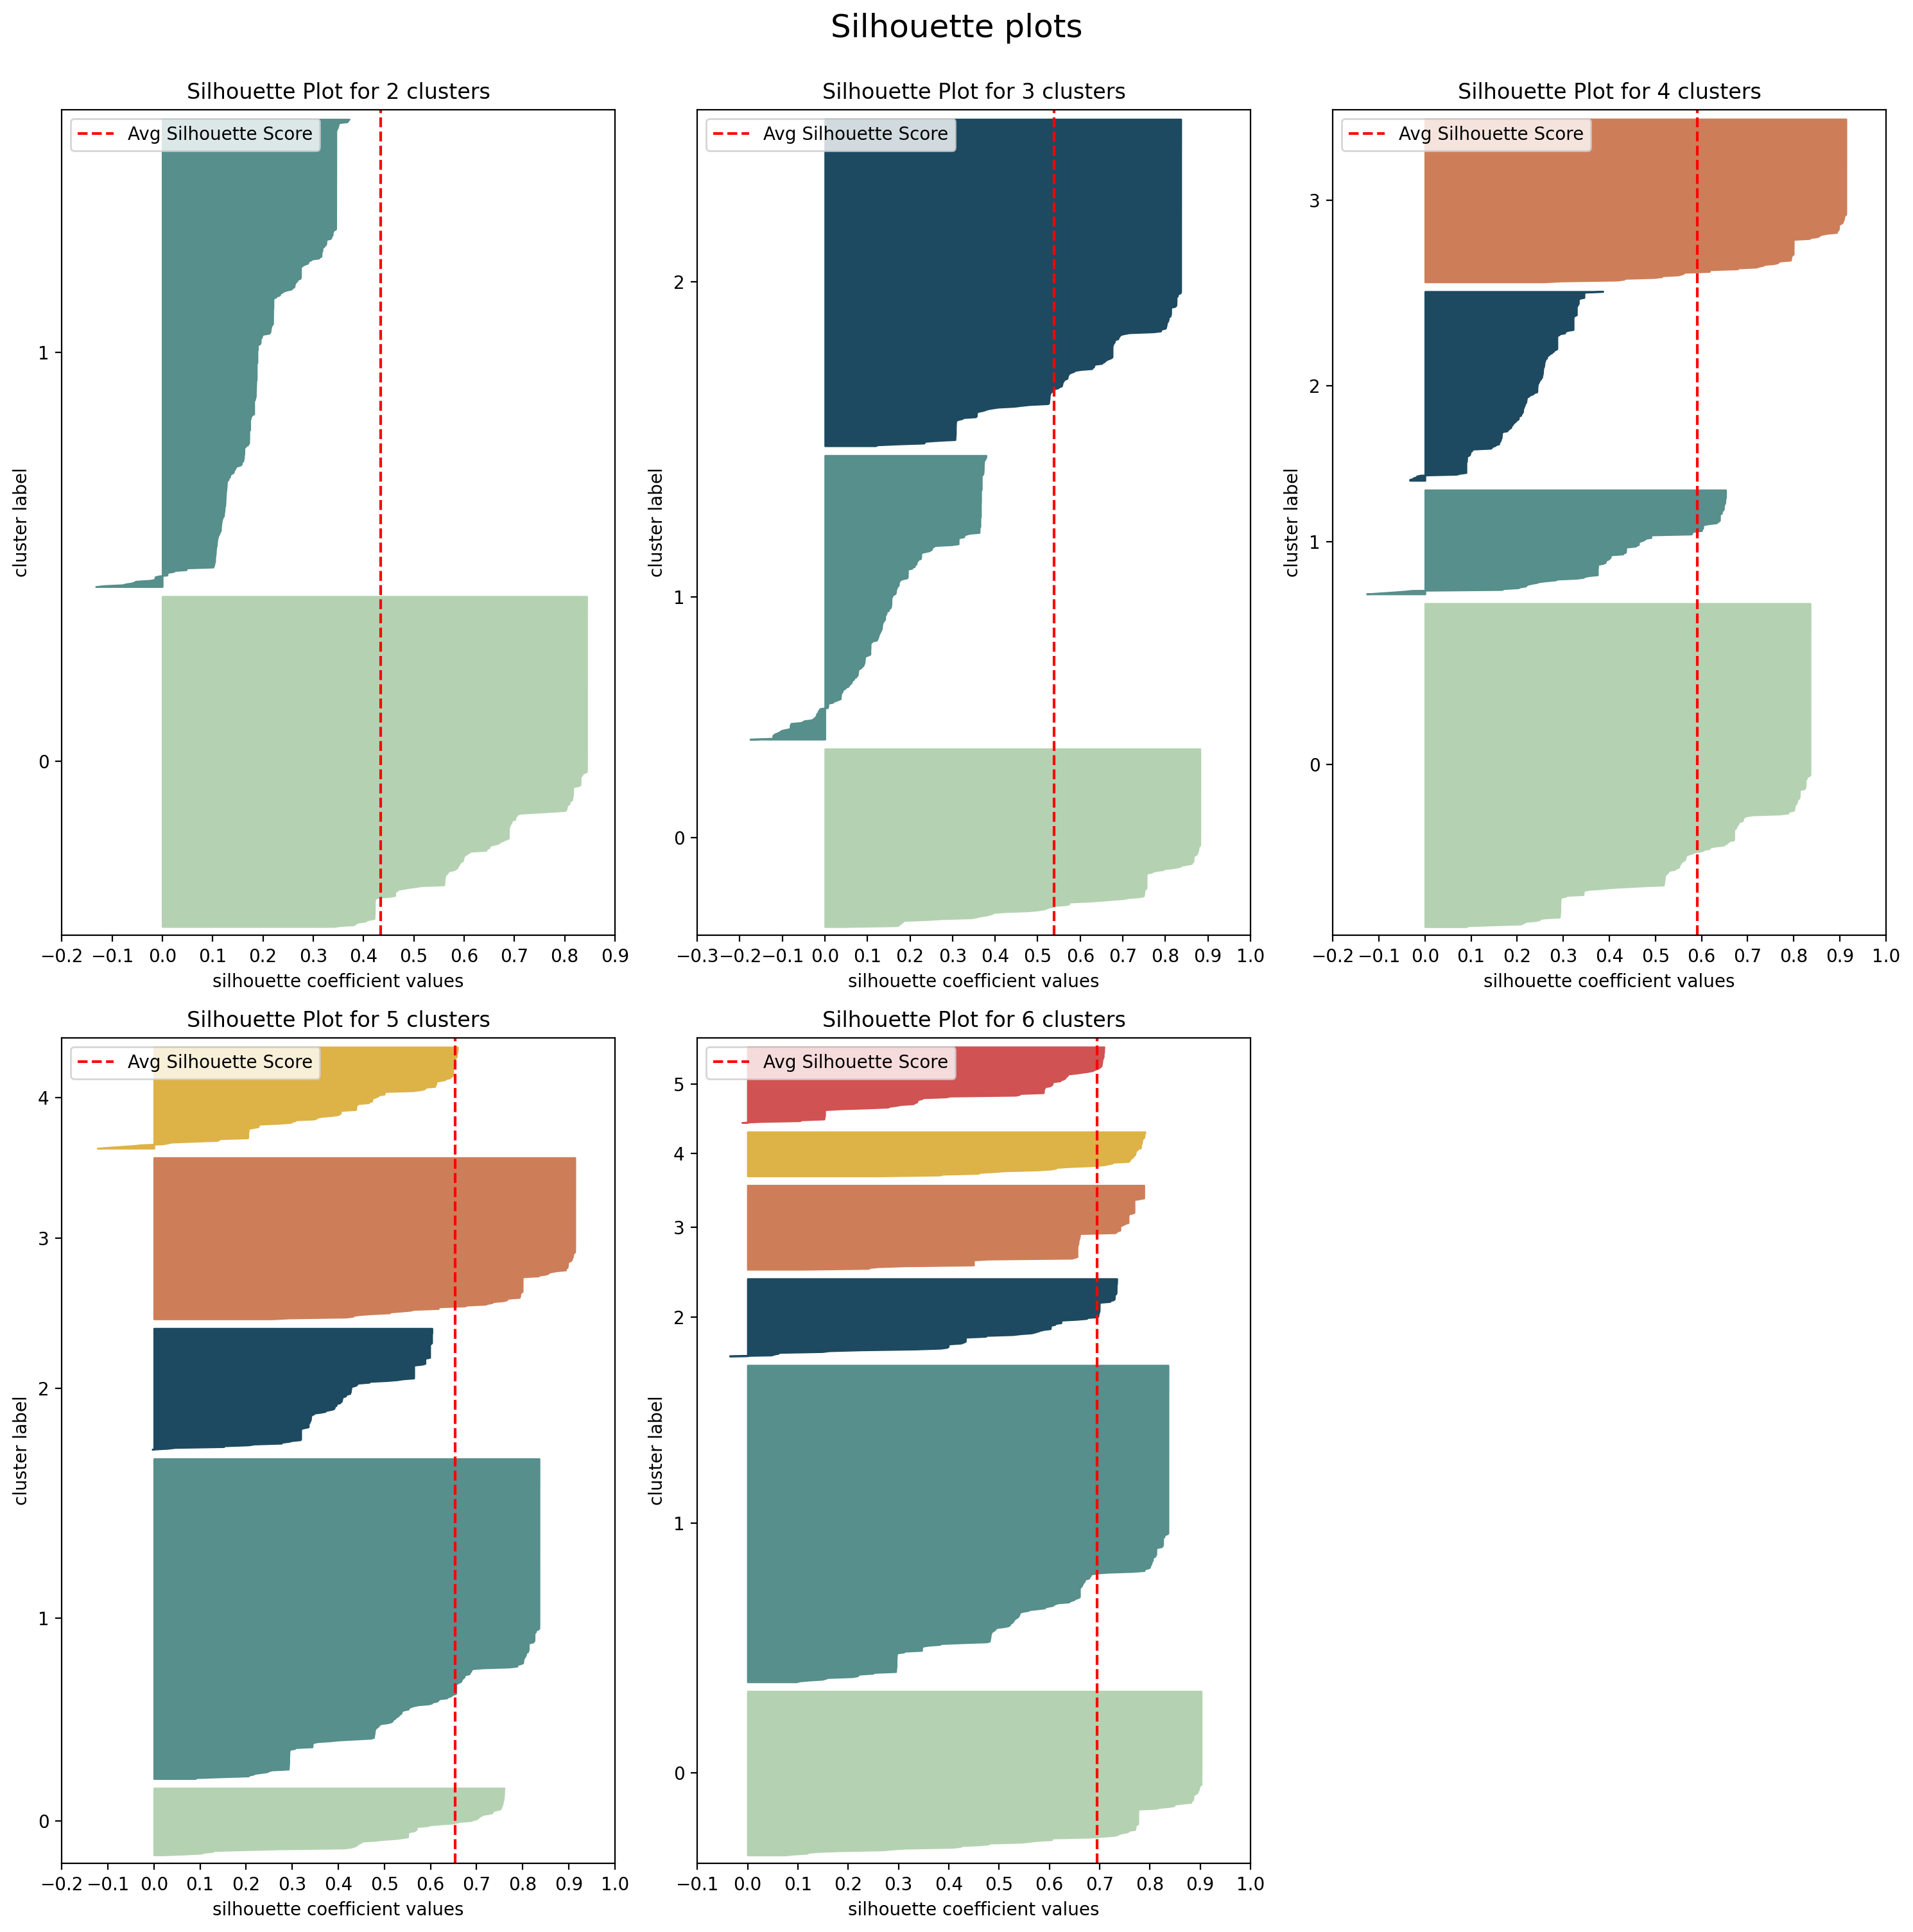

loss: 4.4982
========== reg=0.01 ==========


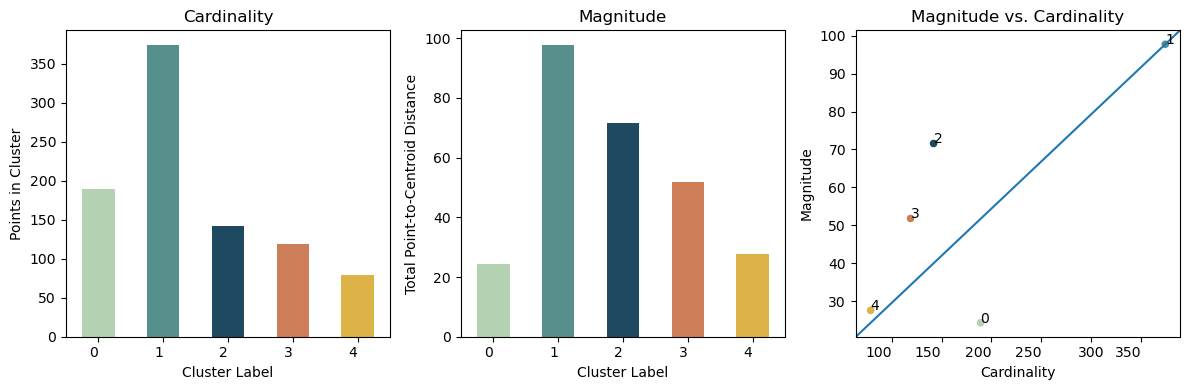

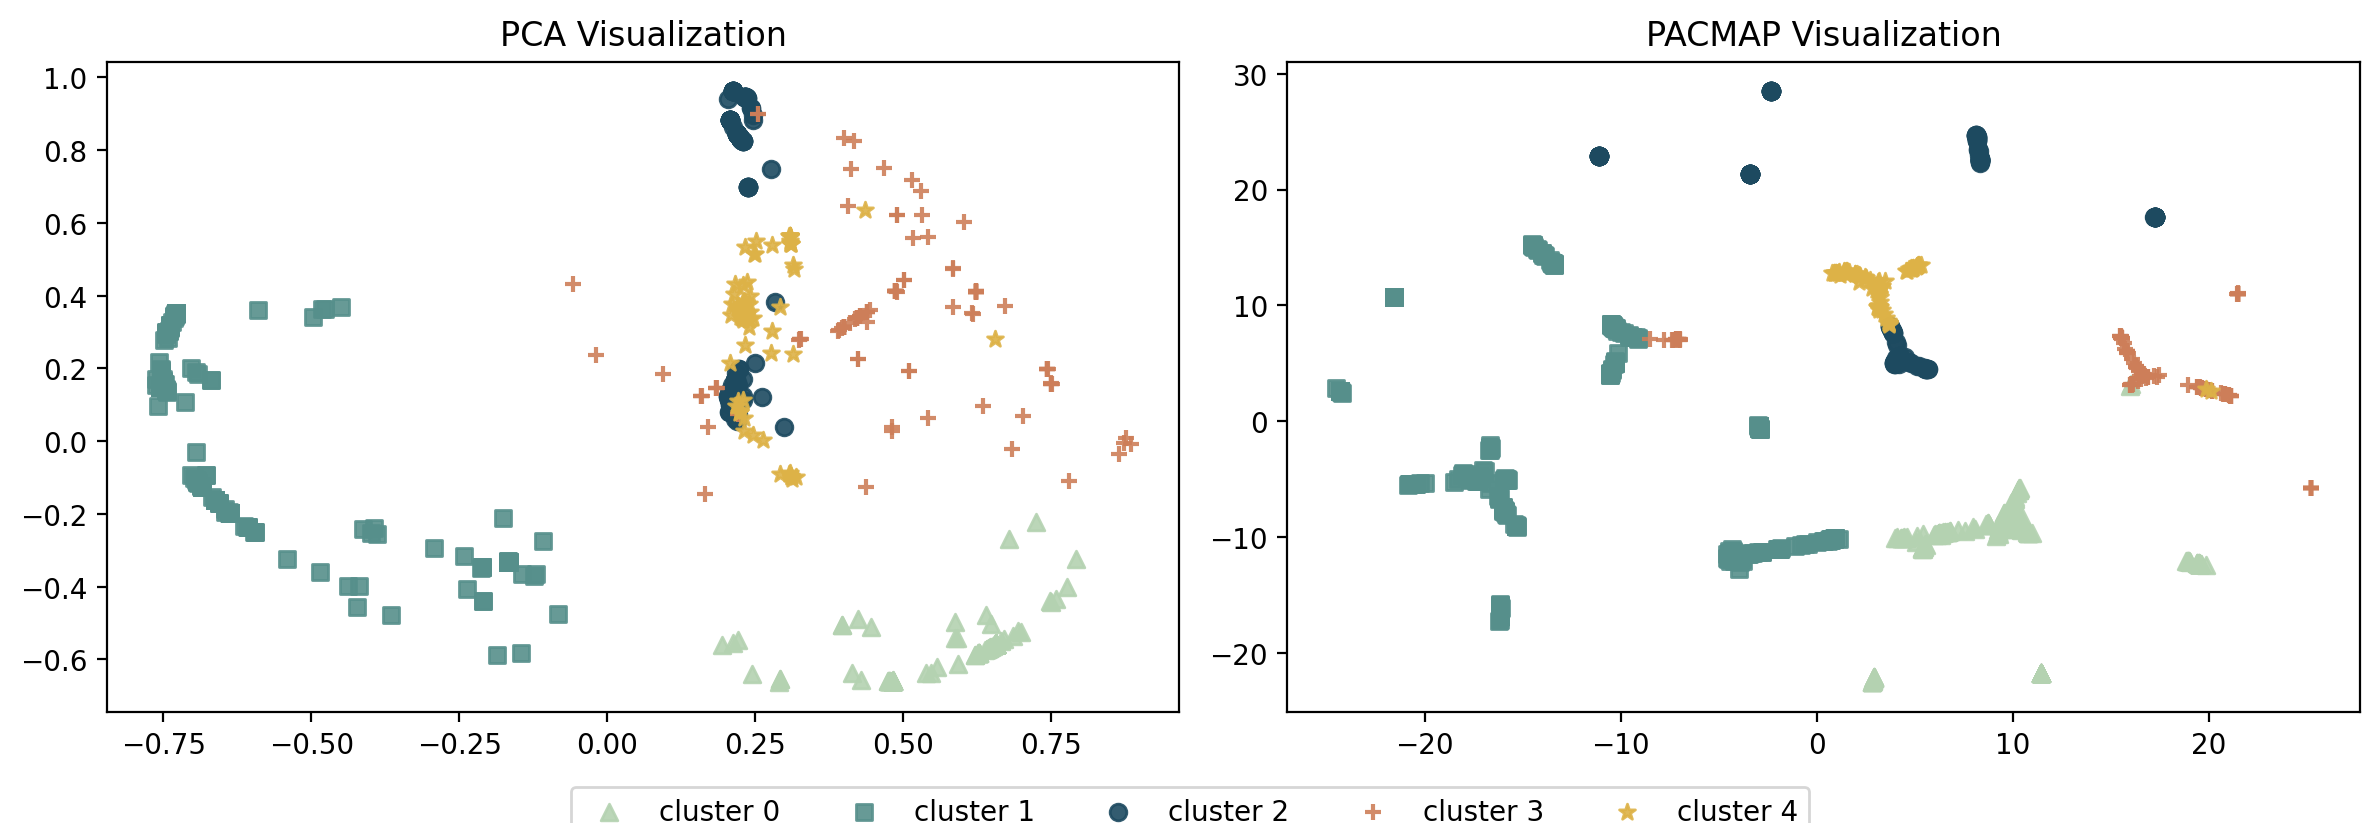

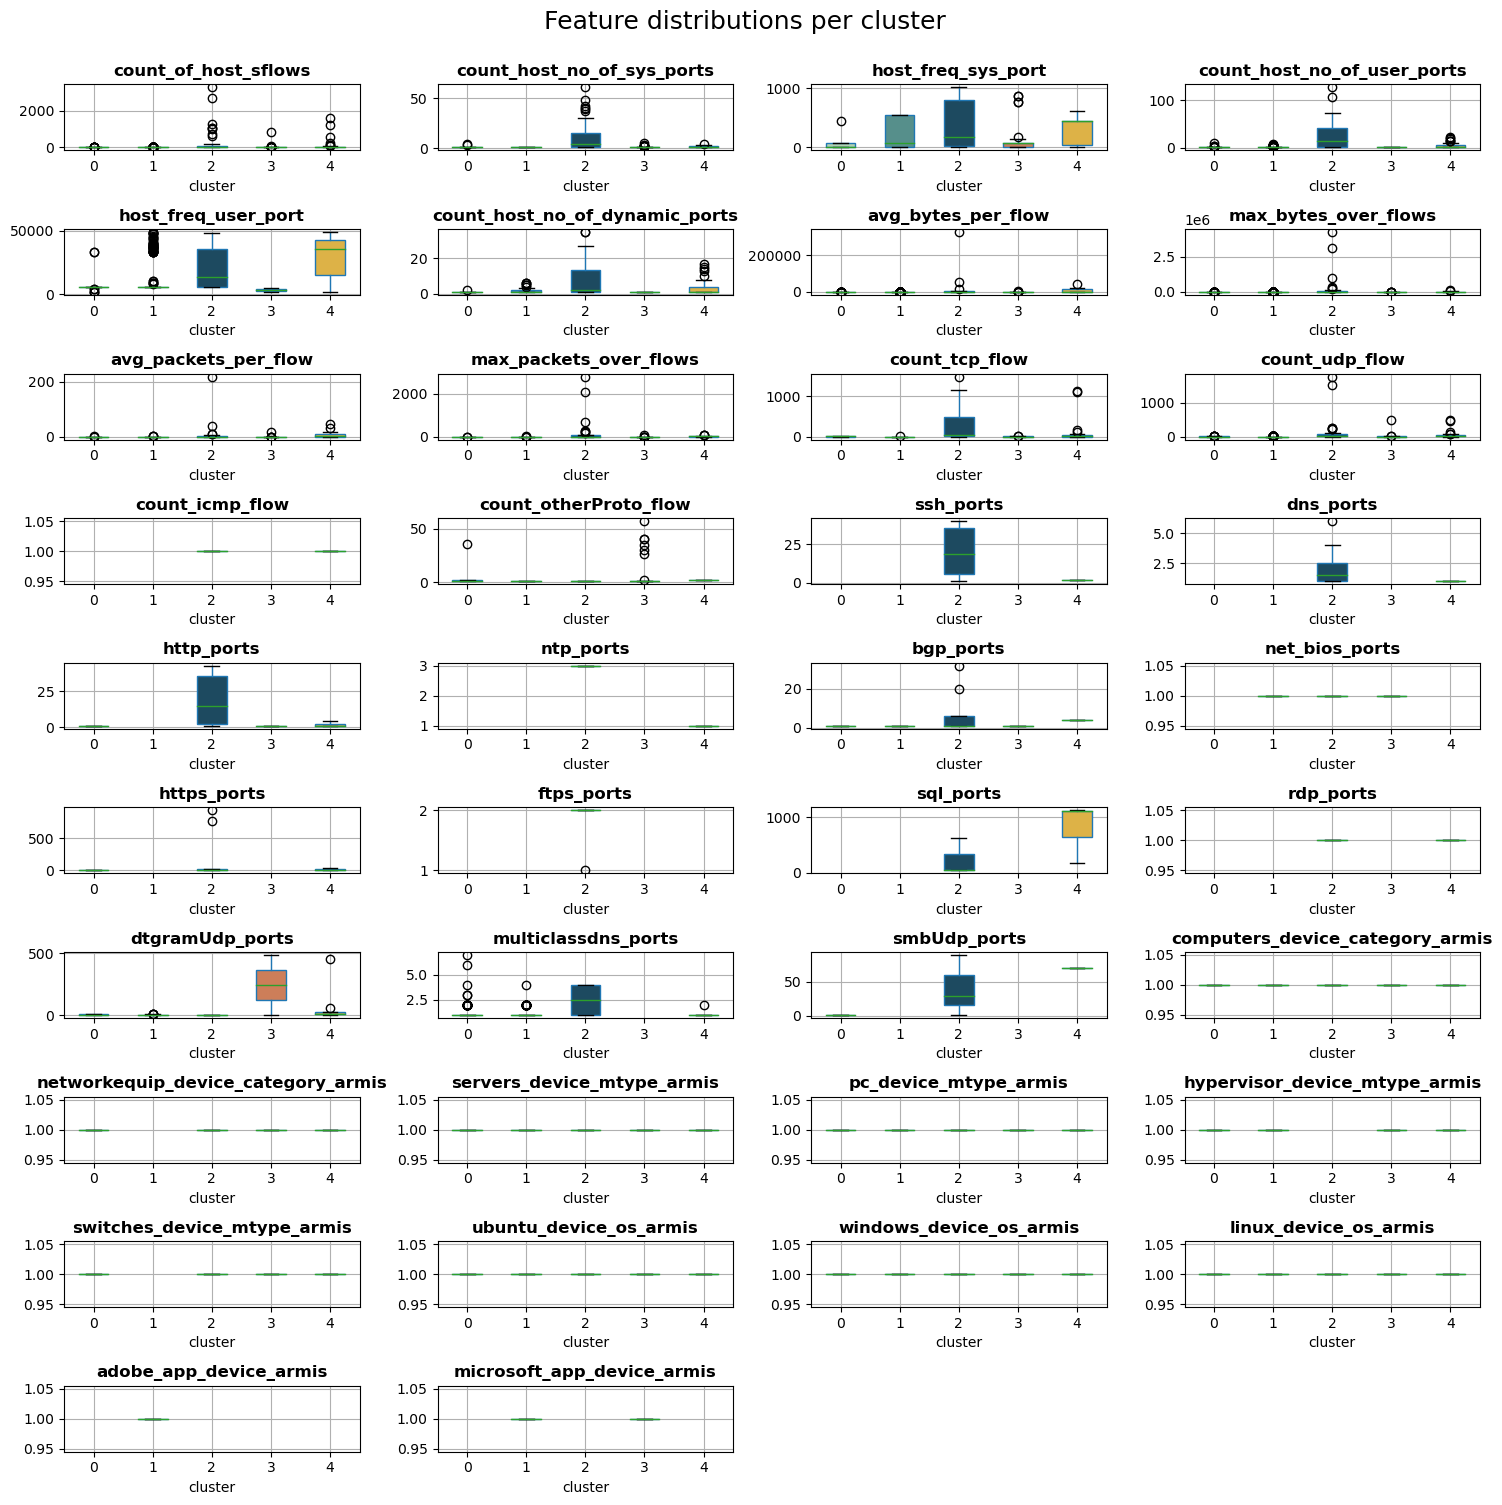

                                   0
cluster category                    
0       Computers          51.322751
        Network Equipment   0.529101
1       Computers          57.219251
2       Computers          10.563380
        Network Equipment   5.633803
3       Computers          33.613445
        Network Equipment   1.680672
4       Computers          26.582278
        Network Equipment   3.797468
                                    0
cluster mtype                        
0       Hypervisor           1.587302
        Personal Computers   2.645503
        Servers             40.740741
        Switches             0.529101
1       Hypervisor           1.604278
        Personal Computers   5.080214
        Servers             48.930481
2       Personal Computers   2.816901
        Servers              7.746479
        Switches             5.633803
3       Hypervisor           2.521008
        Personal Computers   0.840336
        Servers             30.252101
        Switches       

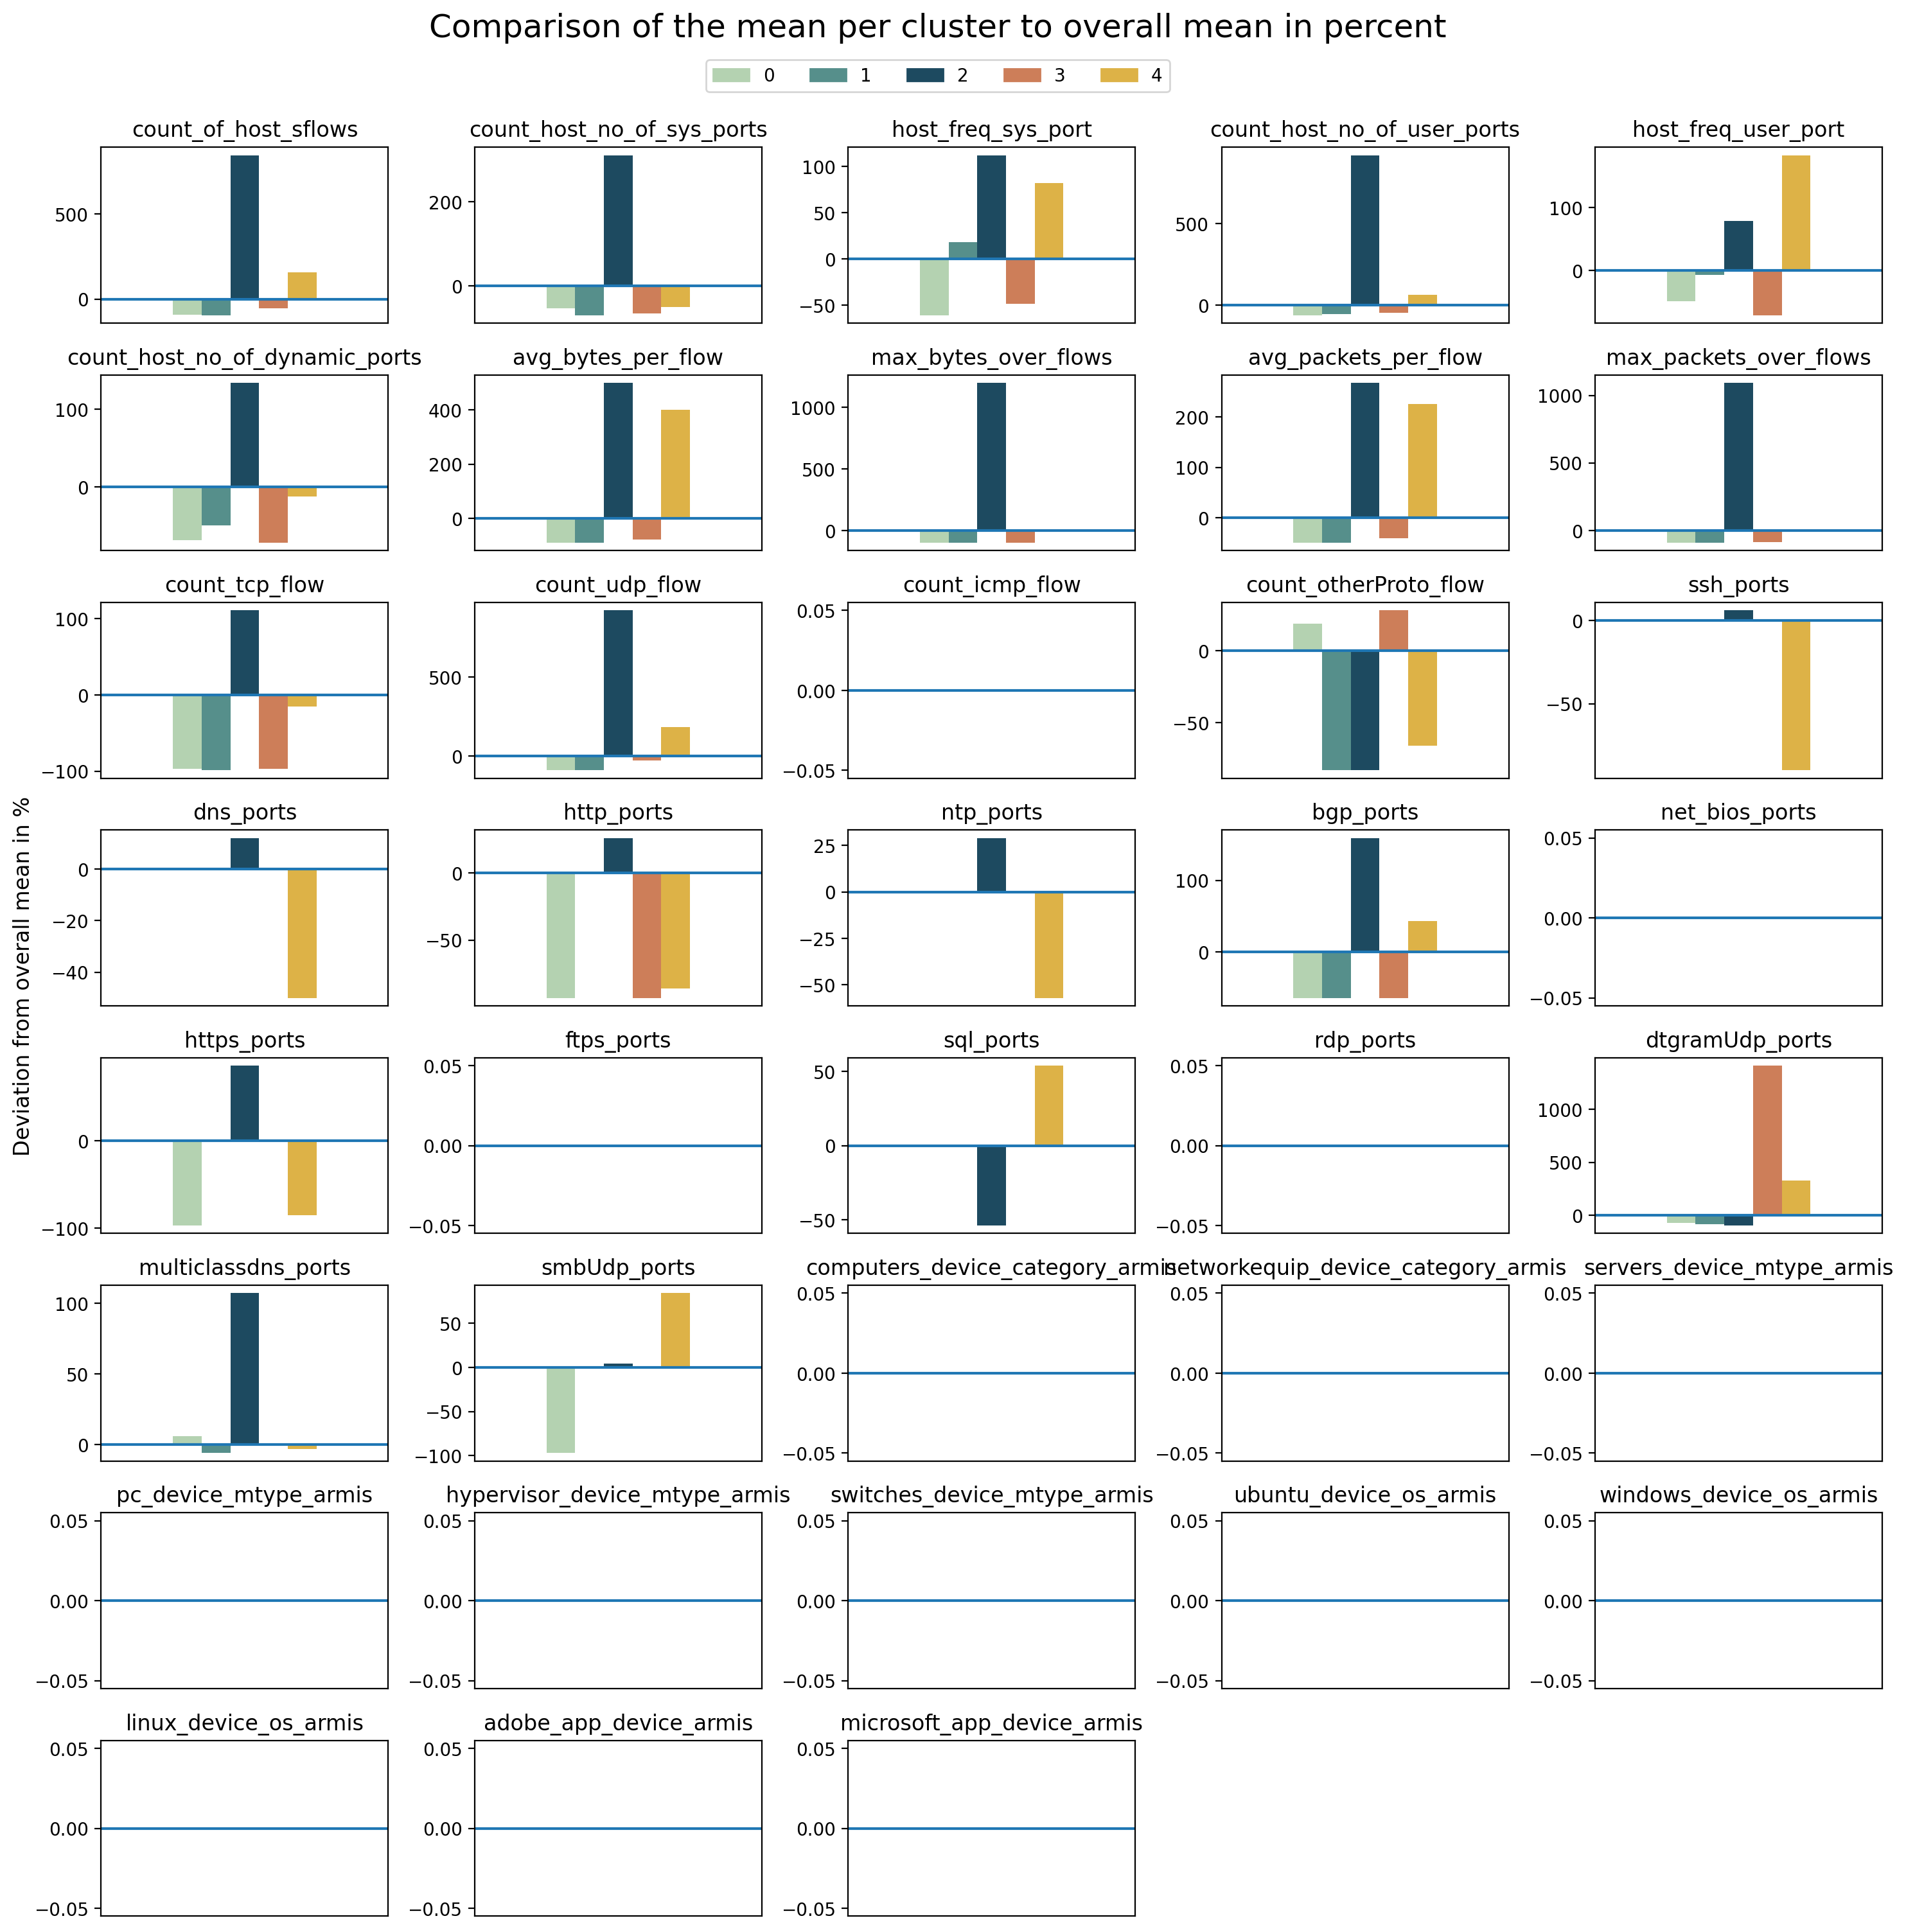

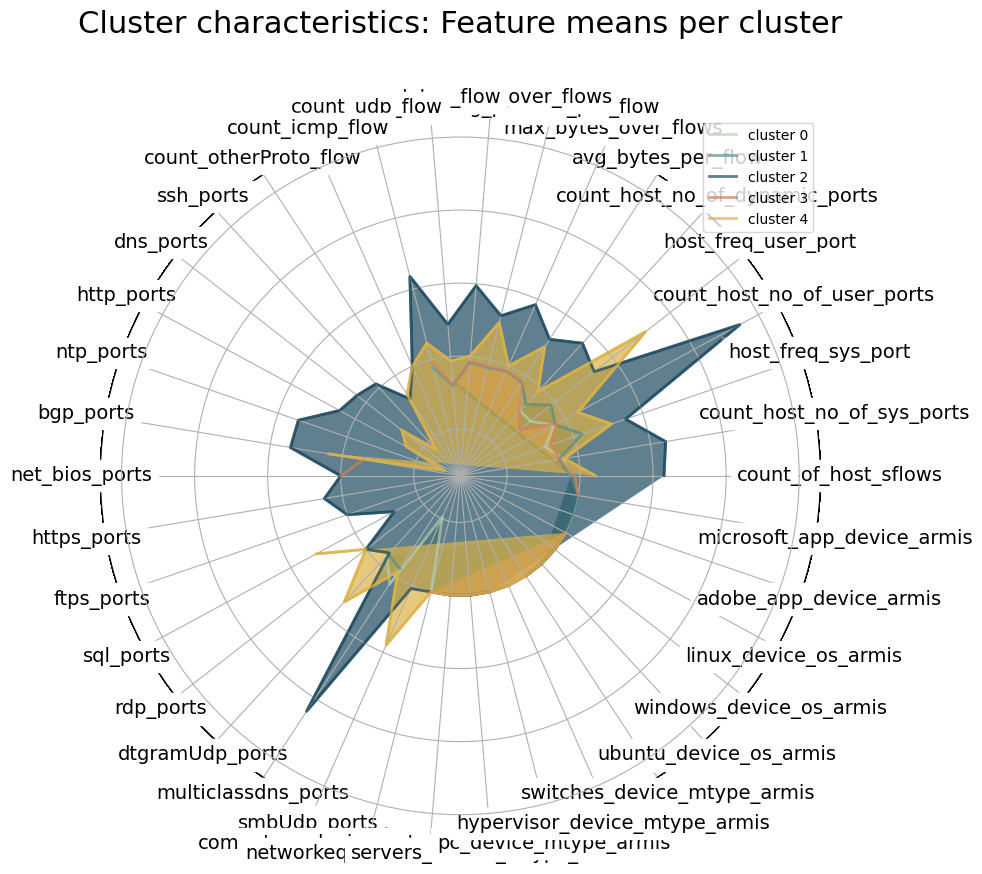

========== alpha=0.1, reg=0.001 ==========
Start pretraining (totally 10 iterations) ......
6.0835676193237305
loss: 5.5699
loss: 5.2285
loss: 4.7864
loss: 4.8280
loss: 4.6433
loss: 4.4918
loss: 4.7028
loss: 4.6577
loss: 4.5700


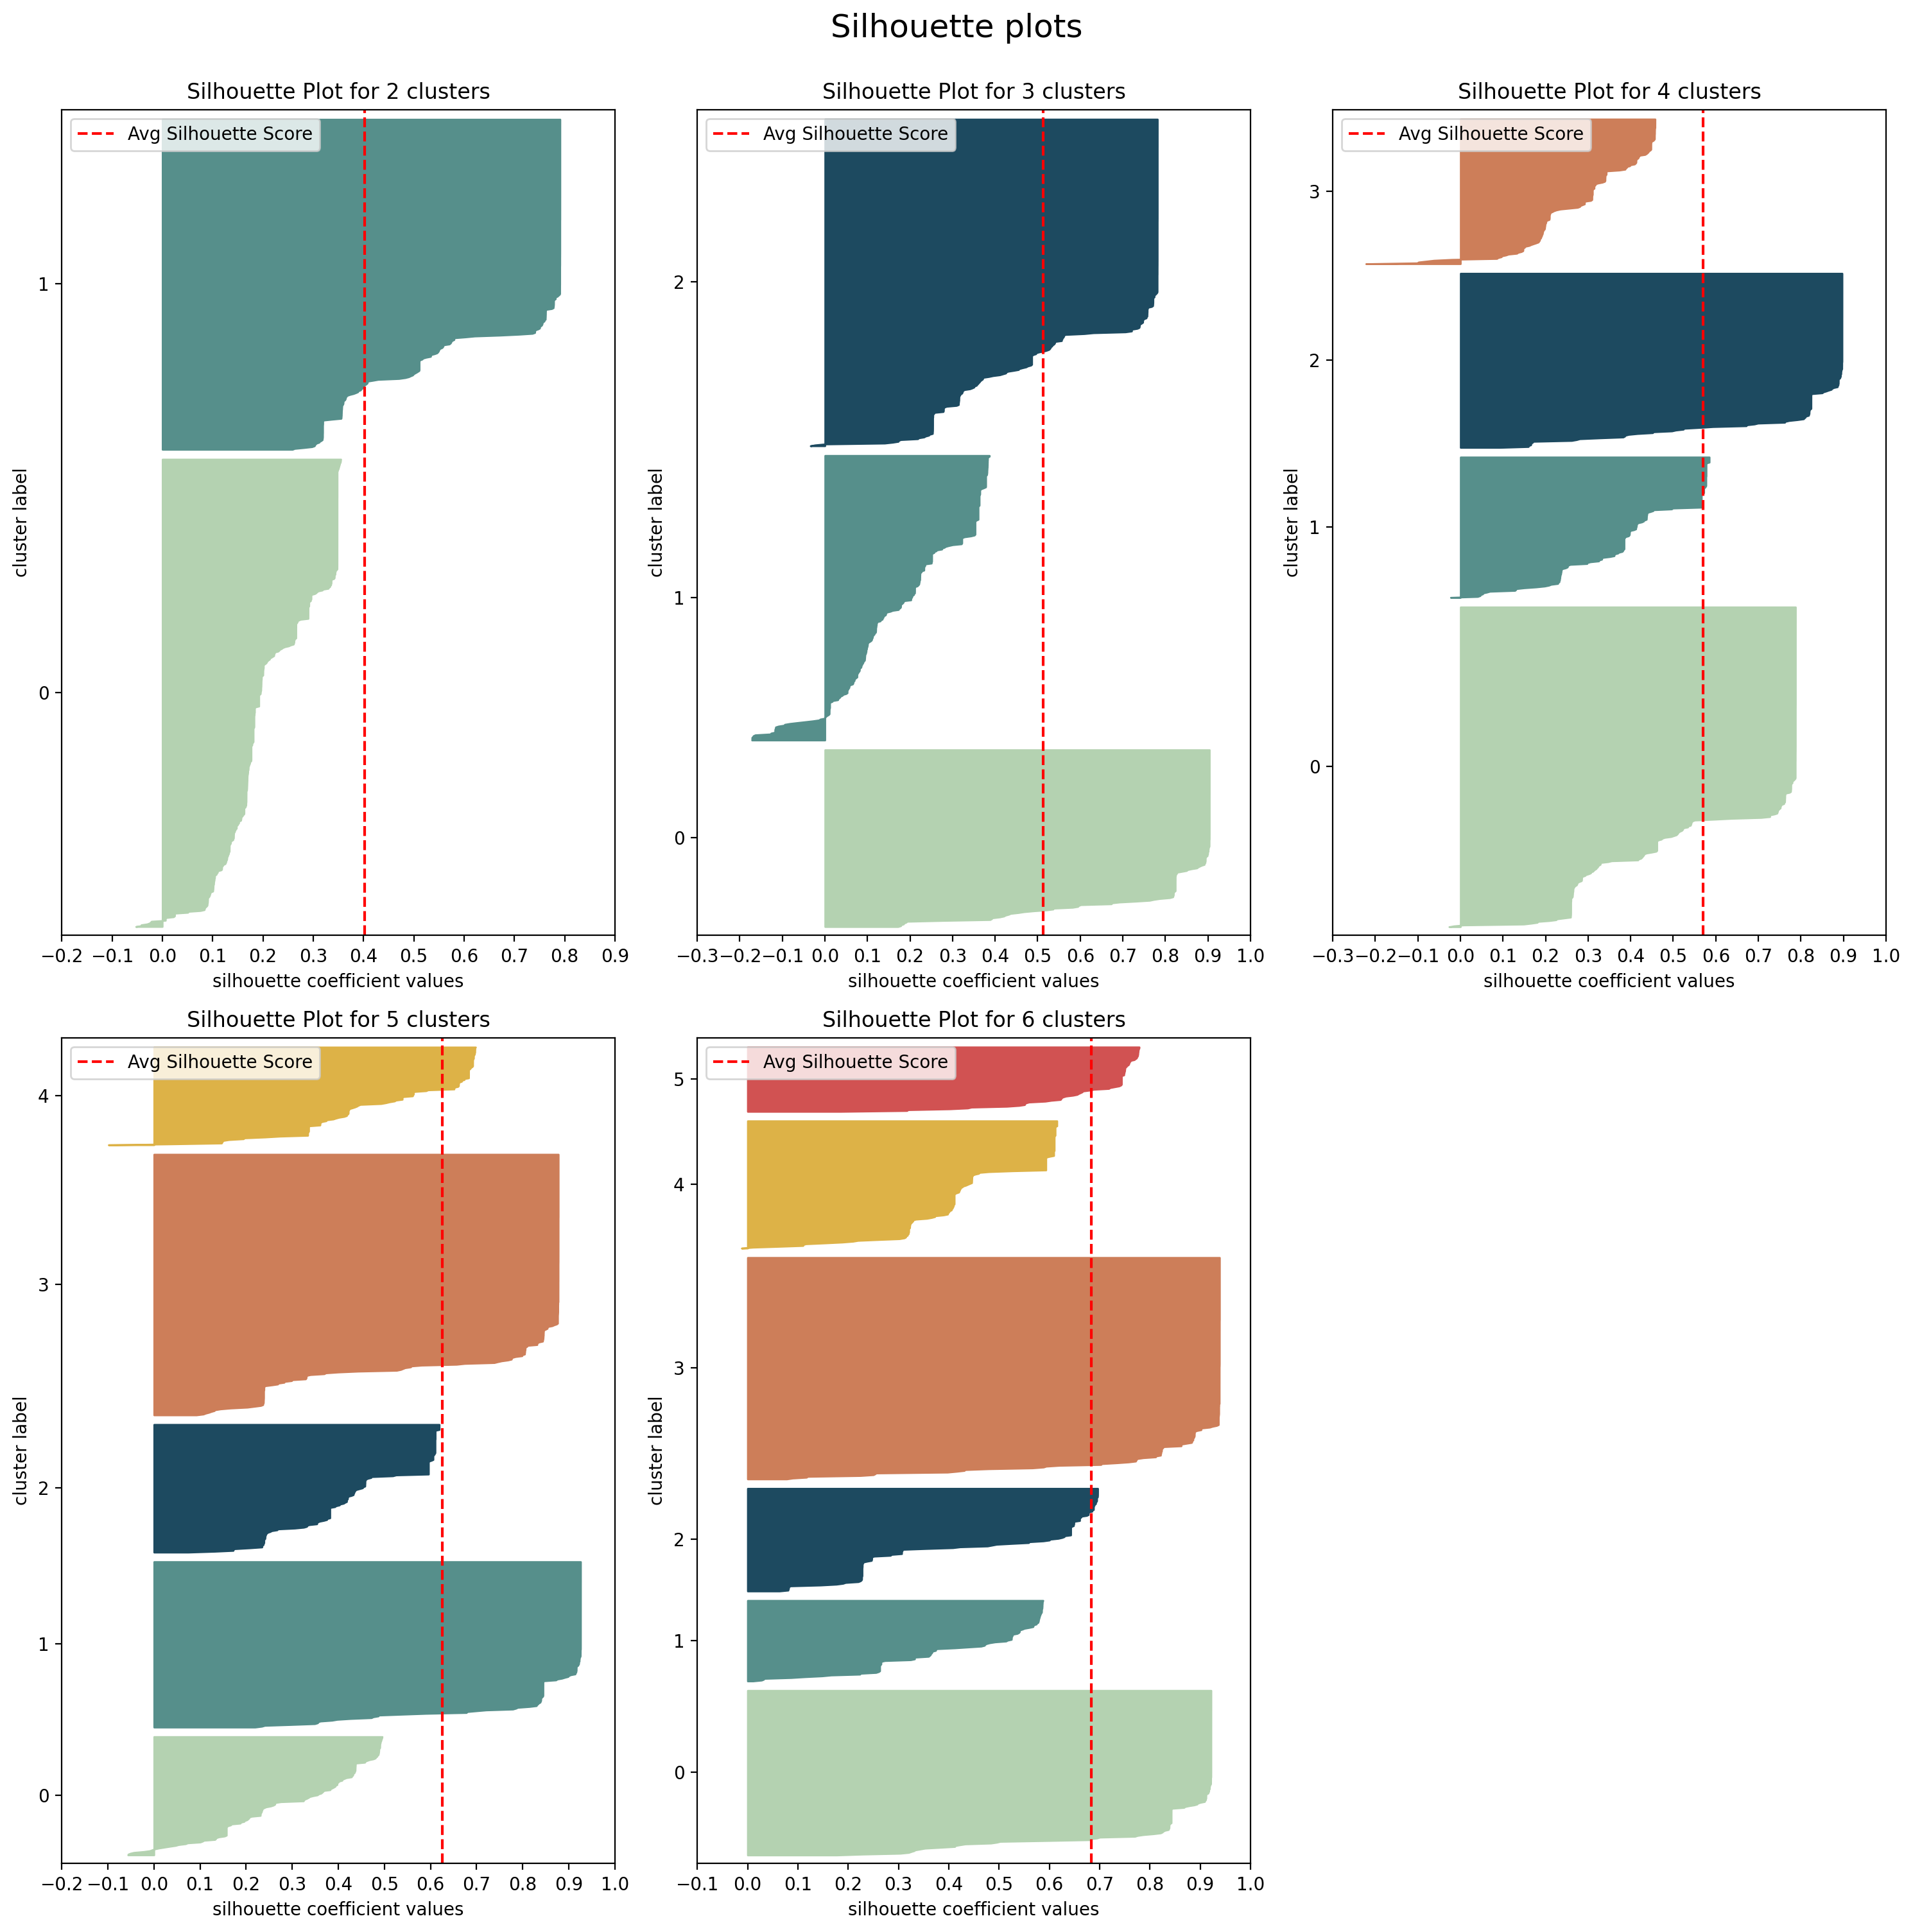

loss: 4.4644
========== reg=0.1 ==========


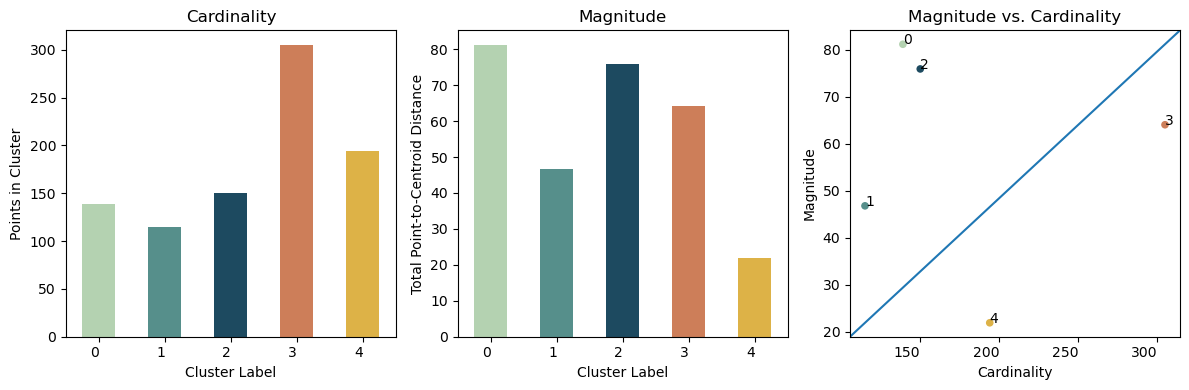

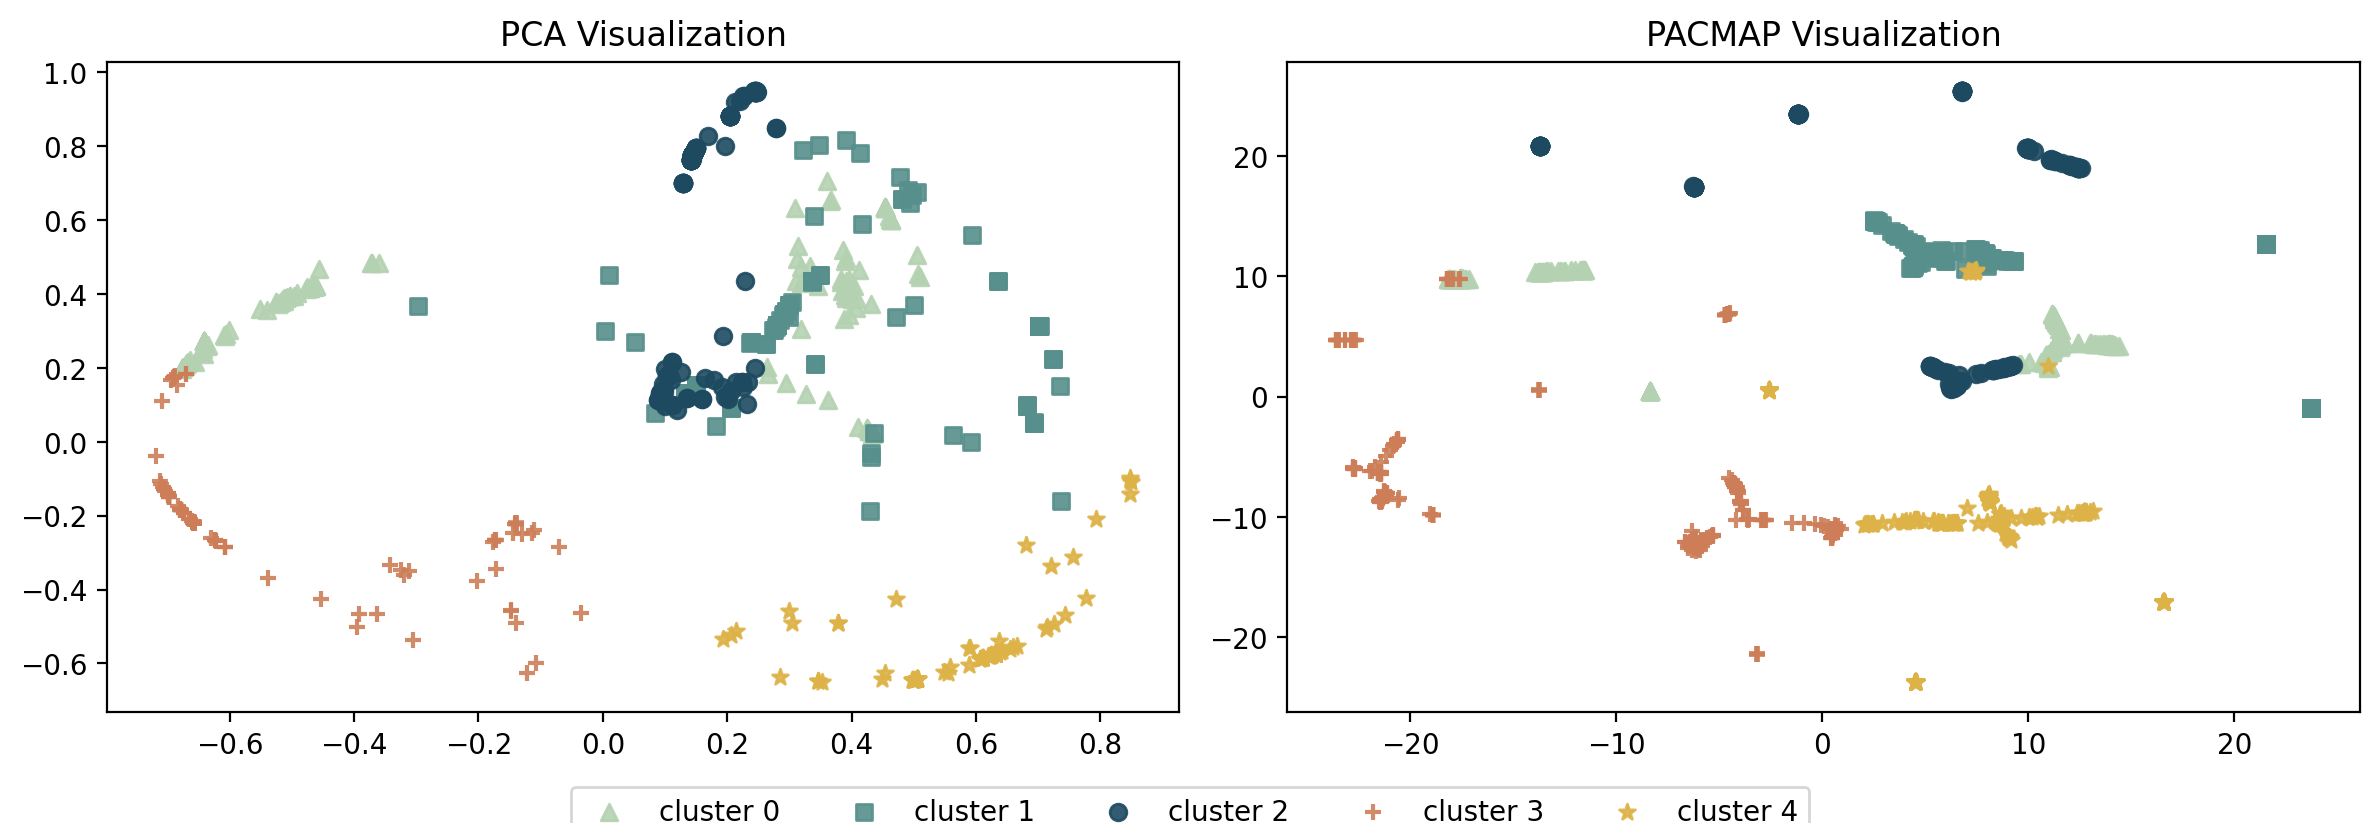

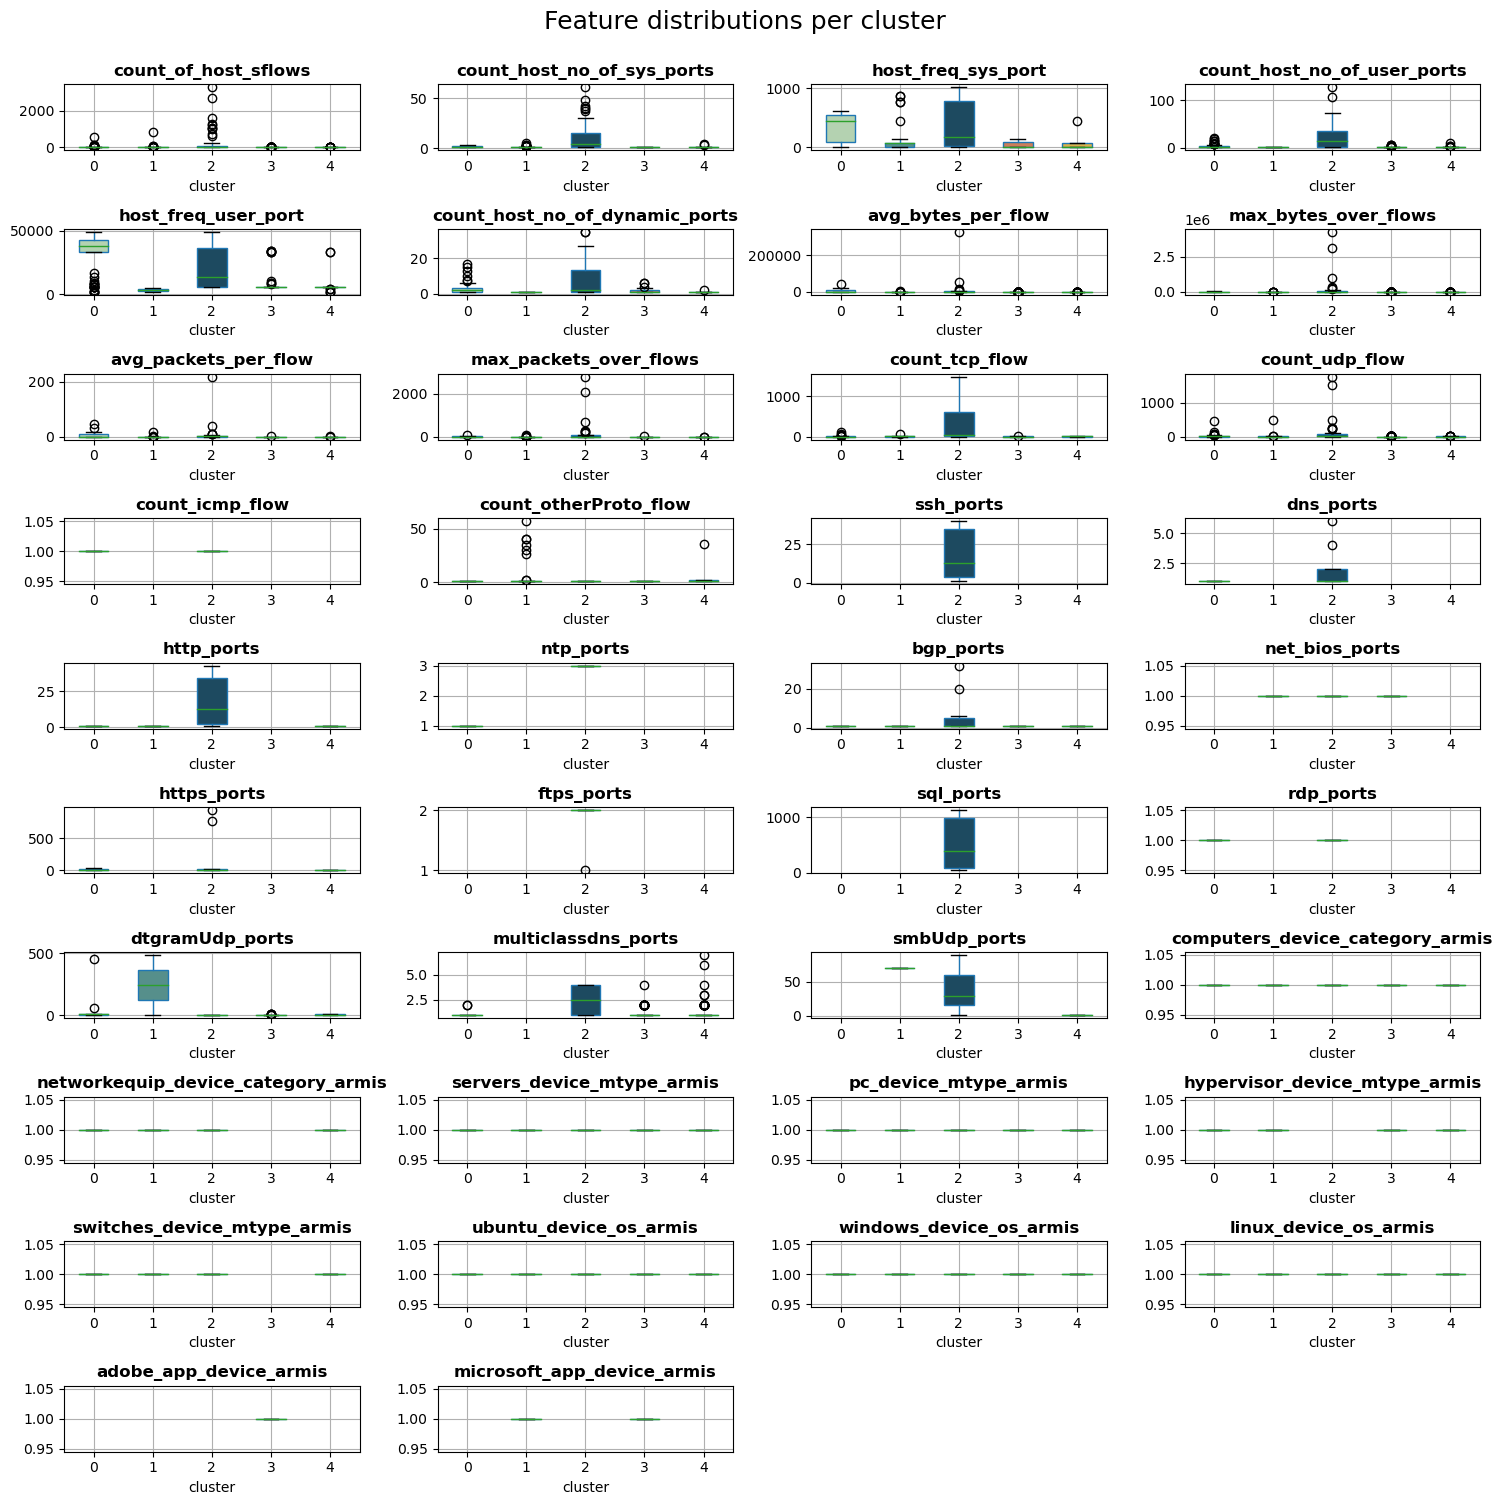

                                   0
cluster category                    
0       Computers          32.374101
        Network Equipment   2.158273
1       Computers          33.913043
        Network Equipment   1.739130
2       Computers          10.666667
        Network Equipment   5.333333
3       Computers          62.295082
4       Computers          50.000000
        Network Equipment   0.515464
                                    0
cluster mtype                        
0       Hypervisor           2.877698
        Personal Computers   4.316547
        Servers             25.179856
        Switches             0.719424
1       Hypervisor           2.608696
        Personal Computers   0.869565
        Servers             30.434783
        Switches             1.739130
2       Personal Computers   2.666667
        Servers              8.000000
        Switches             5.333333
3       Hypervisor           1.639344
        Personal Computers   5.245902
        Servers        

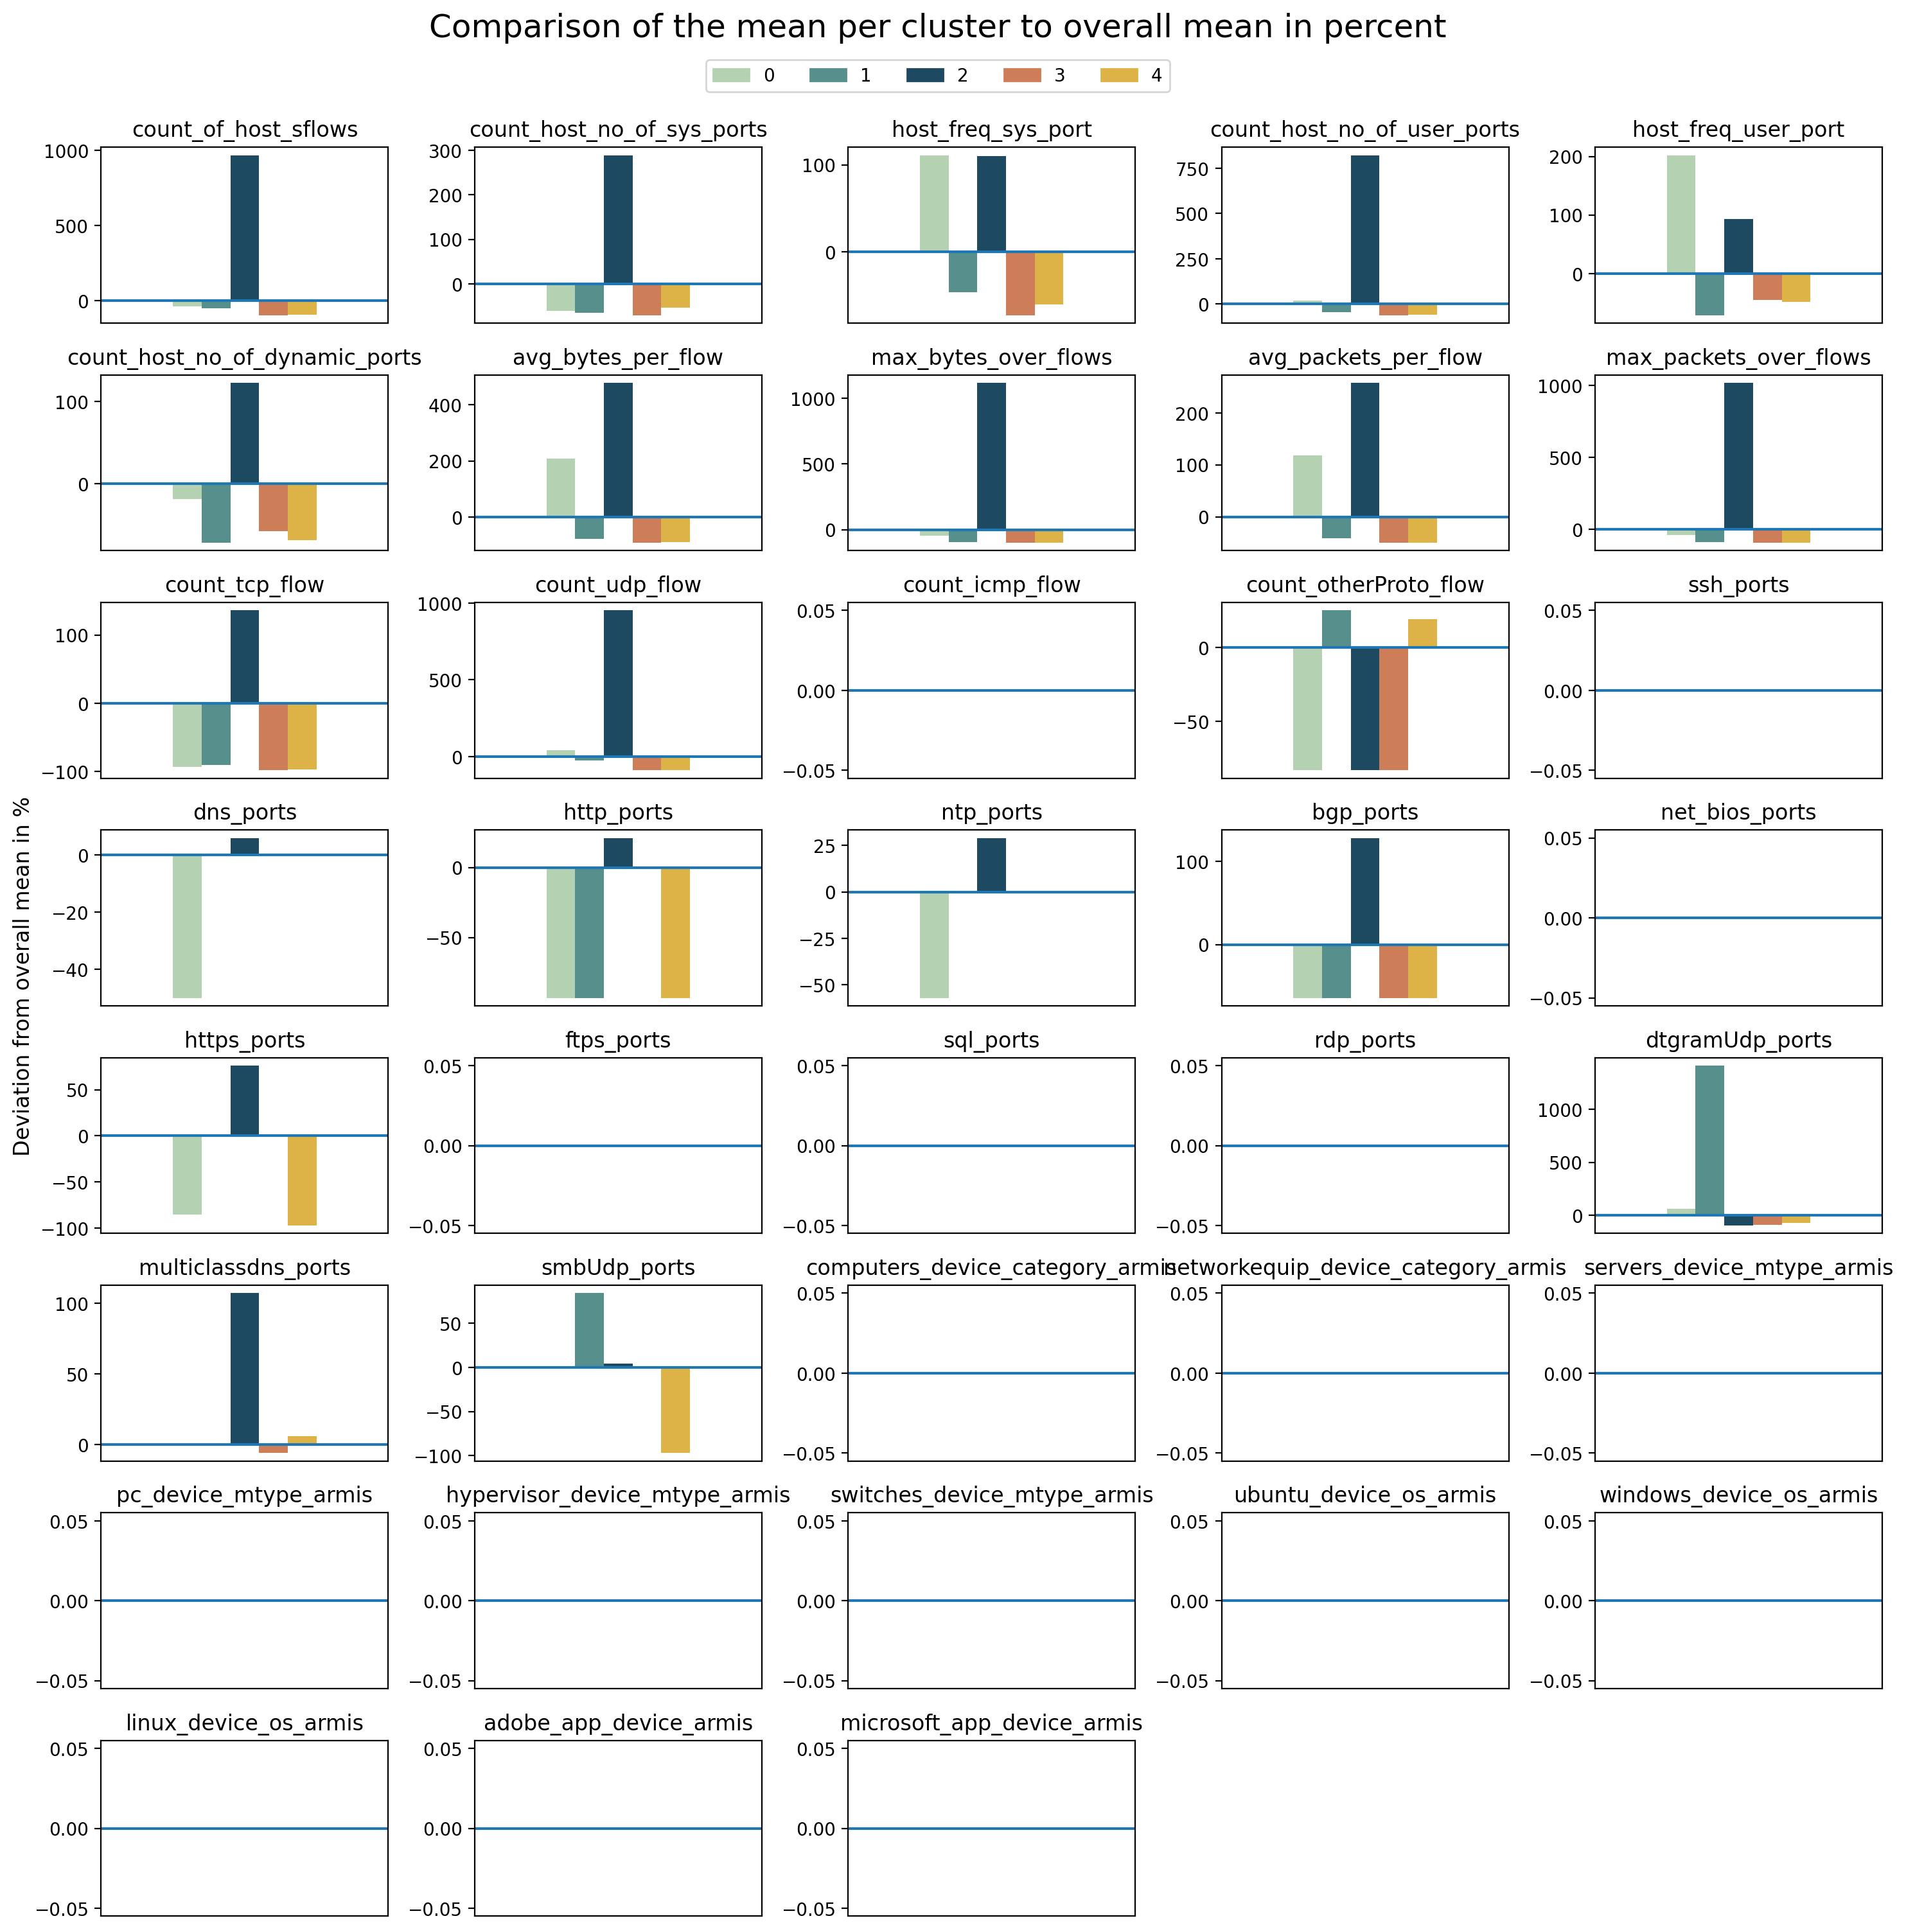

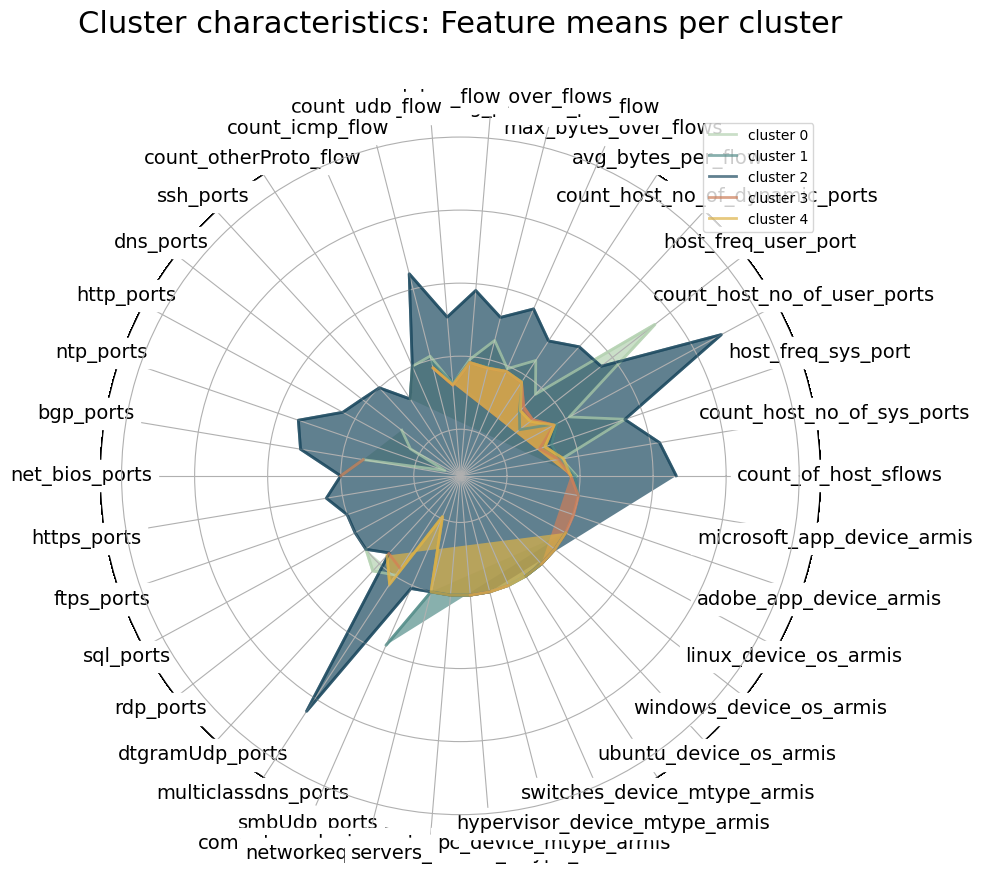

========== alpha=1, reg=0.001 ==========
Start pretraining (totally 10 iterations) ......
6.0386247634887695
loss: 5.5806
loss: 5.2538
loss: 4.9542
loss: 4.6921
loss: 4.4962
loss: 4.2536
loss: 4.2073
loss: 4.1119
loss: 4.0403


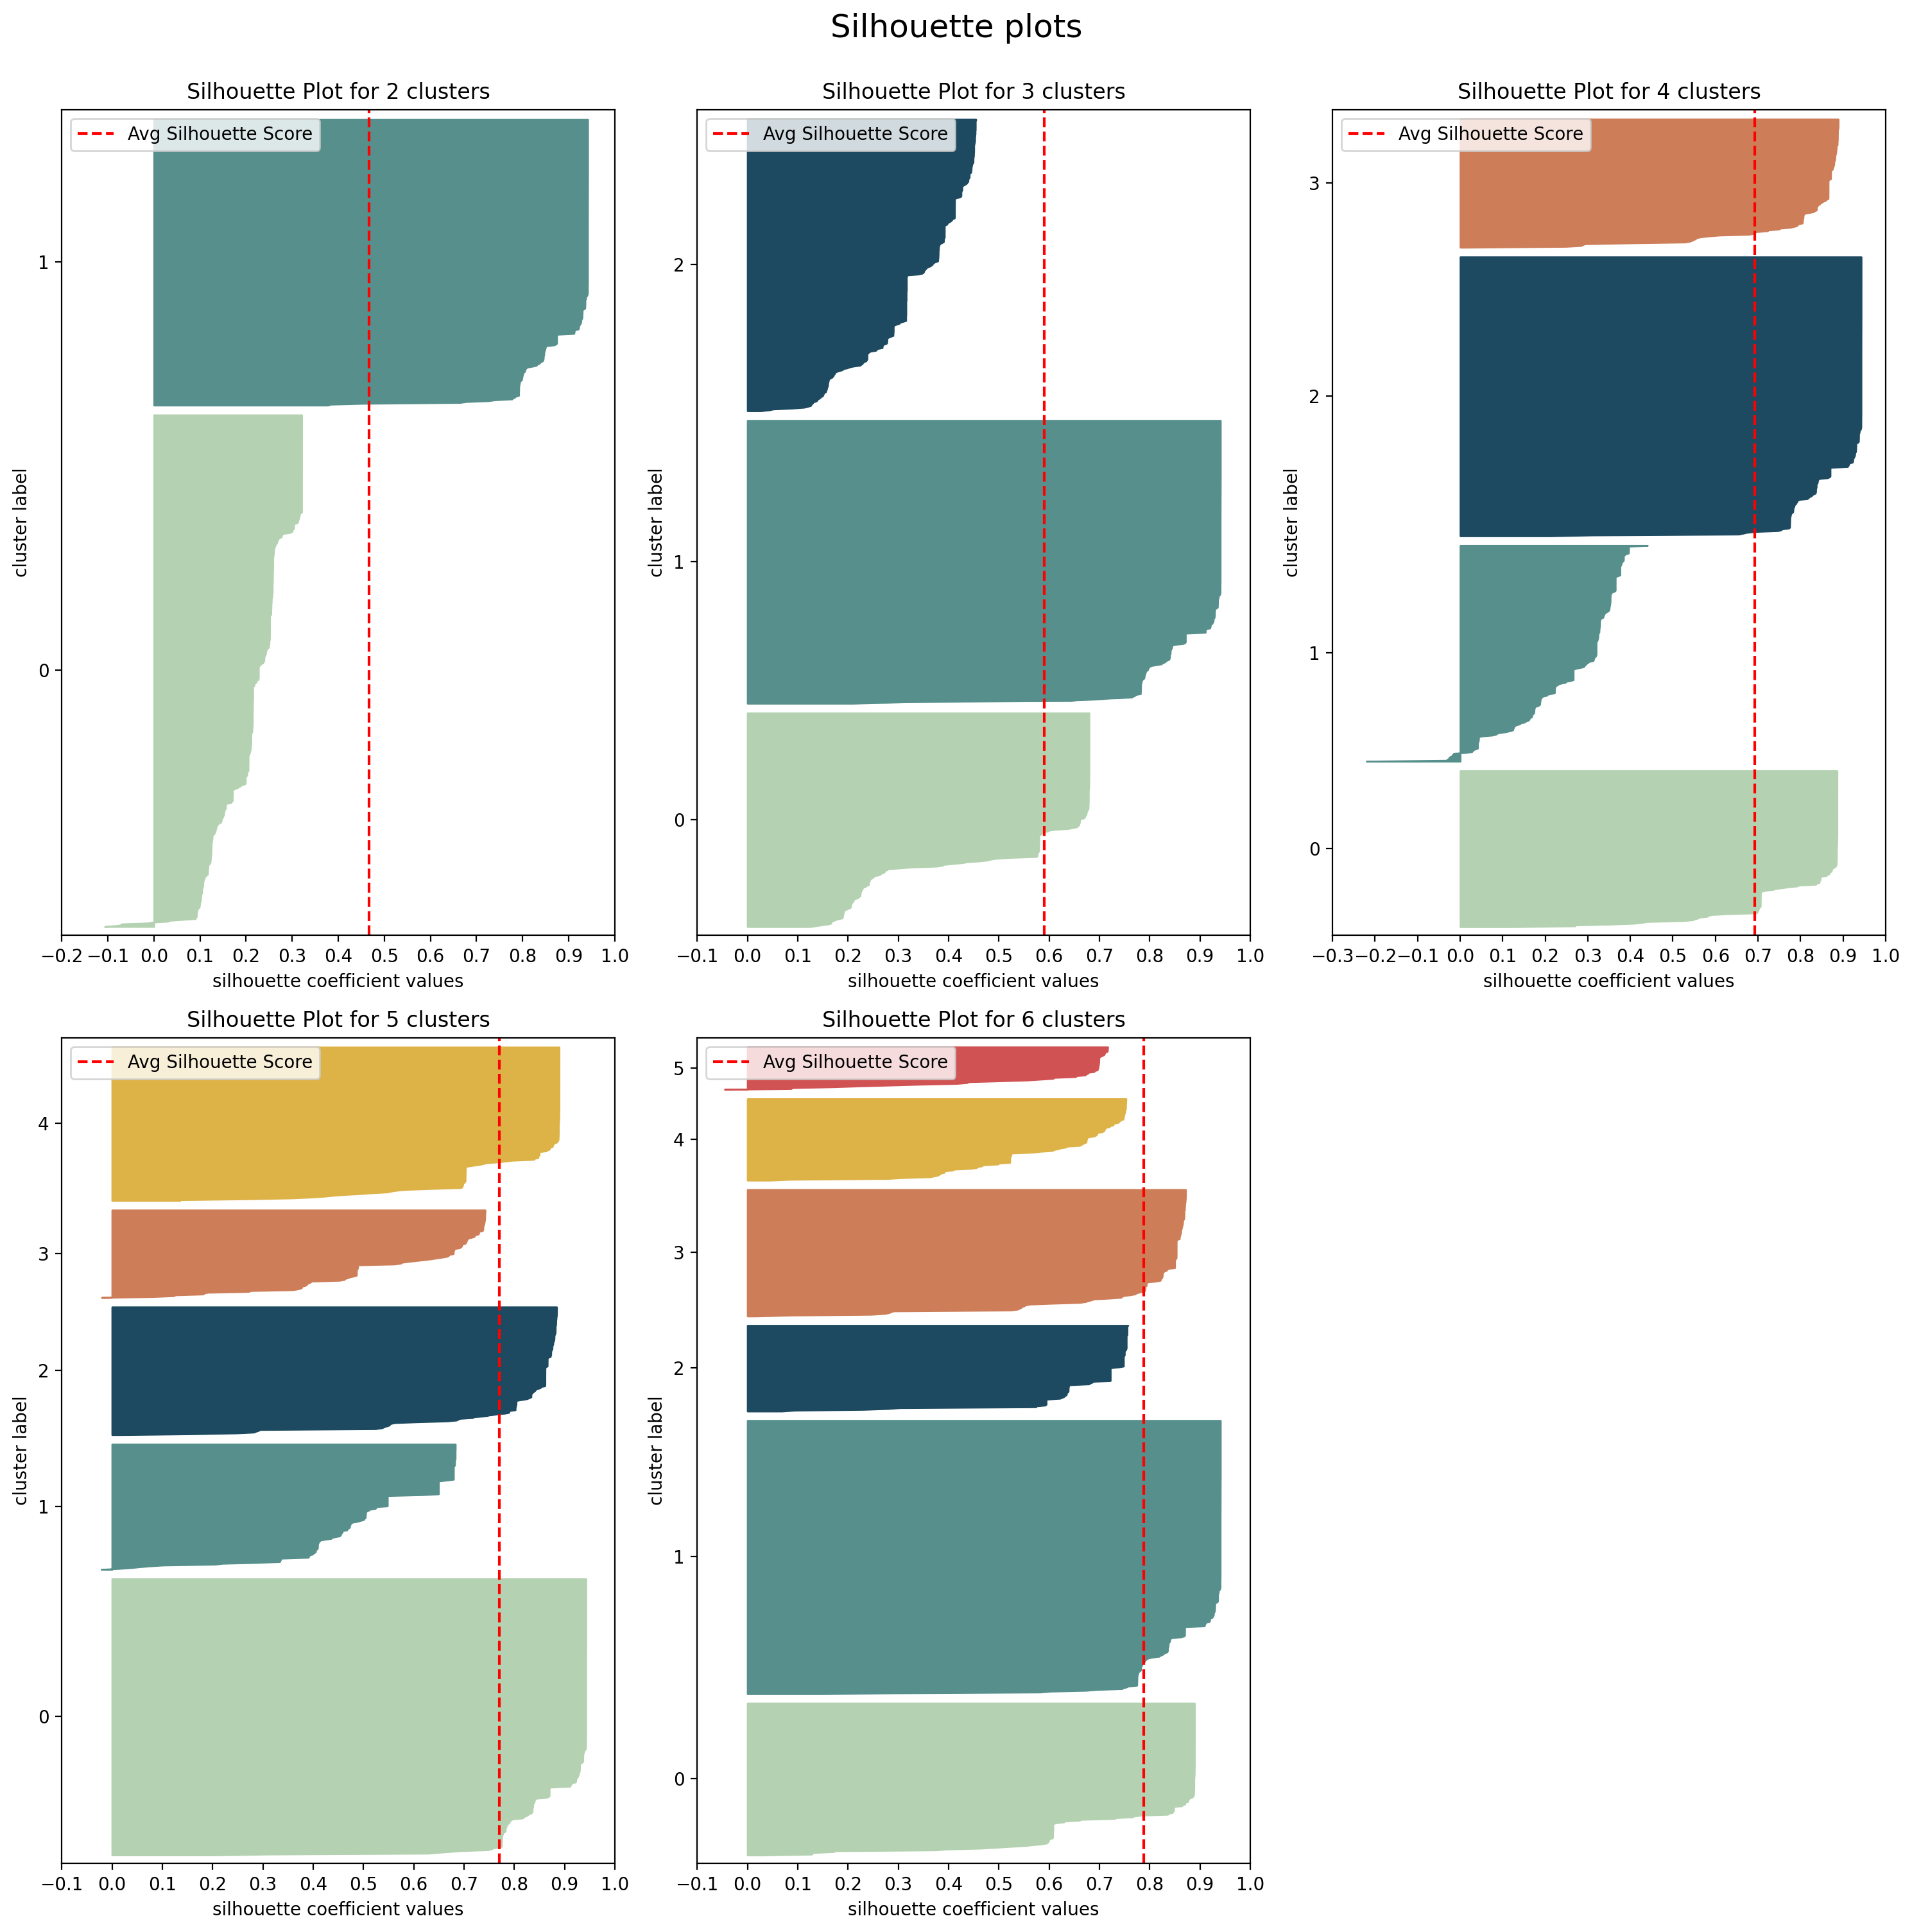

loss: 4.2042
========== reg=1 ==========


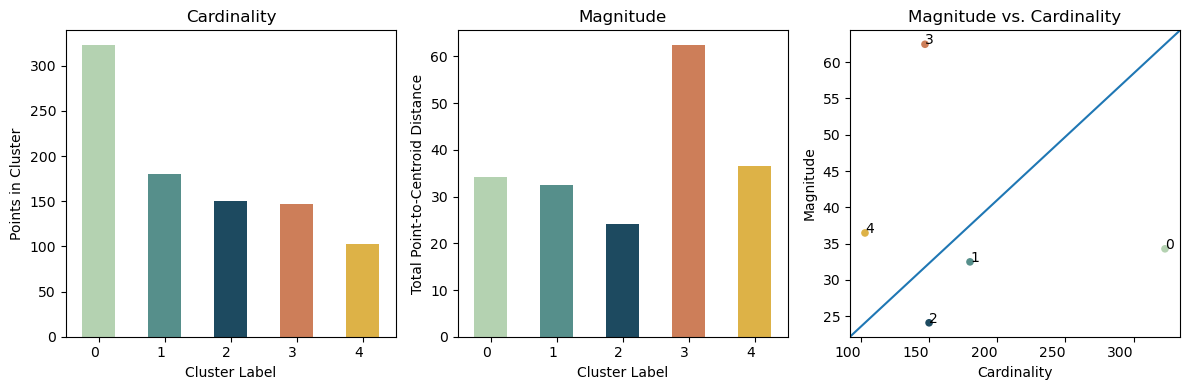

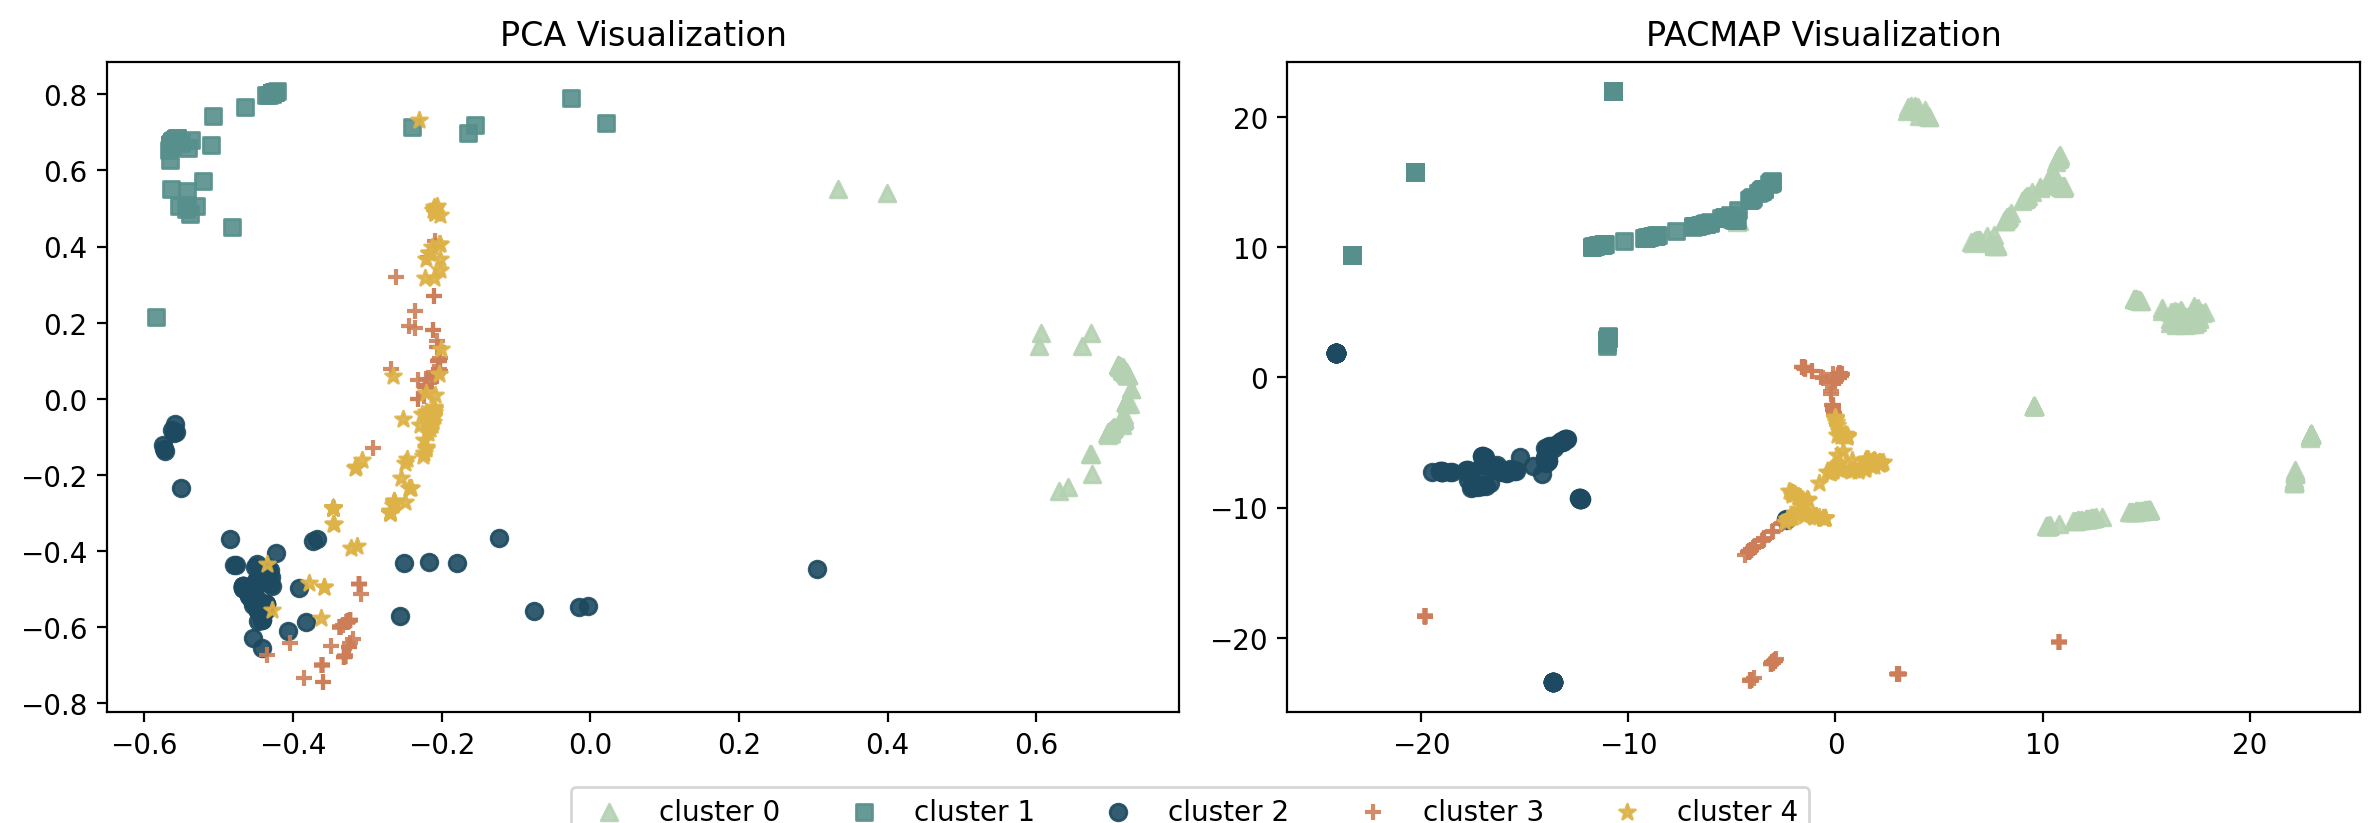

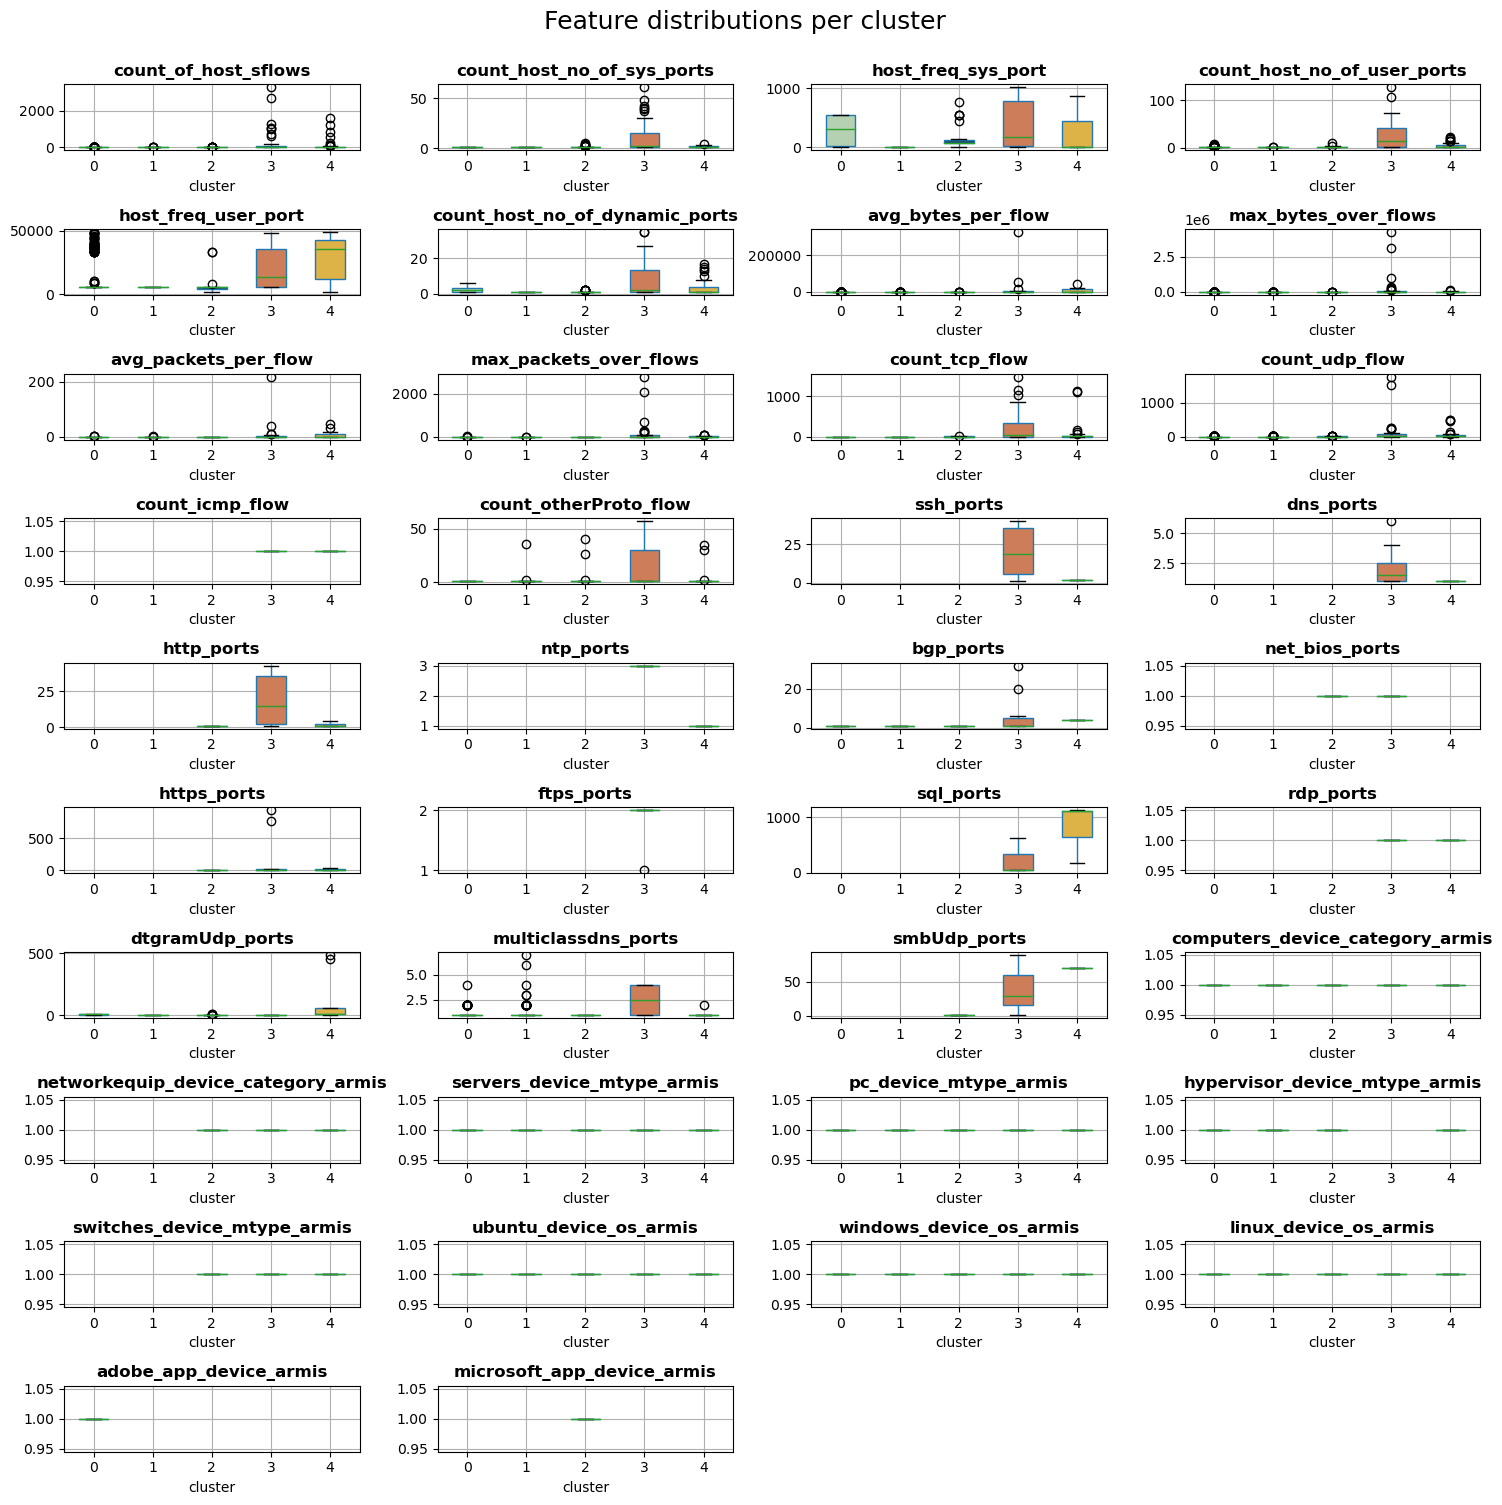

                                   0
cluster category                    
0       Computers          59.133127
1       Computers          53.888889
2       Computers          34.000000
        Network Equipment   1.333333
3       Computers          10.884354
        Network Equipment   5.442177
4       Computers          31.067961
        Network Equipment   3.883495
                                    0
cluster mtype                        
0       Hypervisor           1.547988
        Personal Computers   4.334365
        Servers             51.393189
1       Hypervisor           1.666667
        Personal Computers   2.777778
        Servers             42.777778
2       Hypervisor           2.000000
        Personal Computers   4.000000
        Servers             28.000000
        Switches             1.333333
3       Personal Computers   2.721088
        Servers              8.163265
        Switches             5.442177
4       Hypervisor           3.883495
        Personal Compu

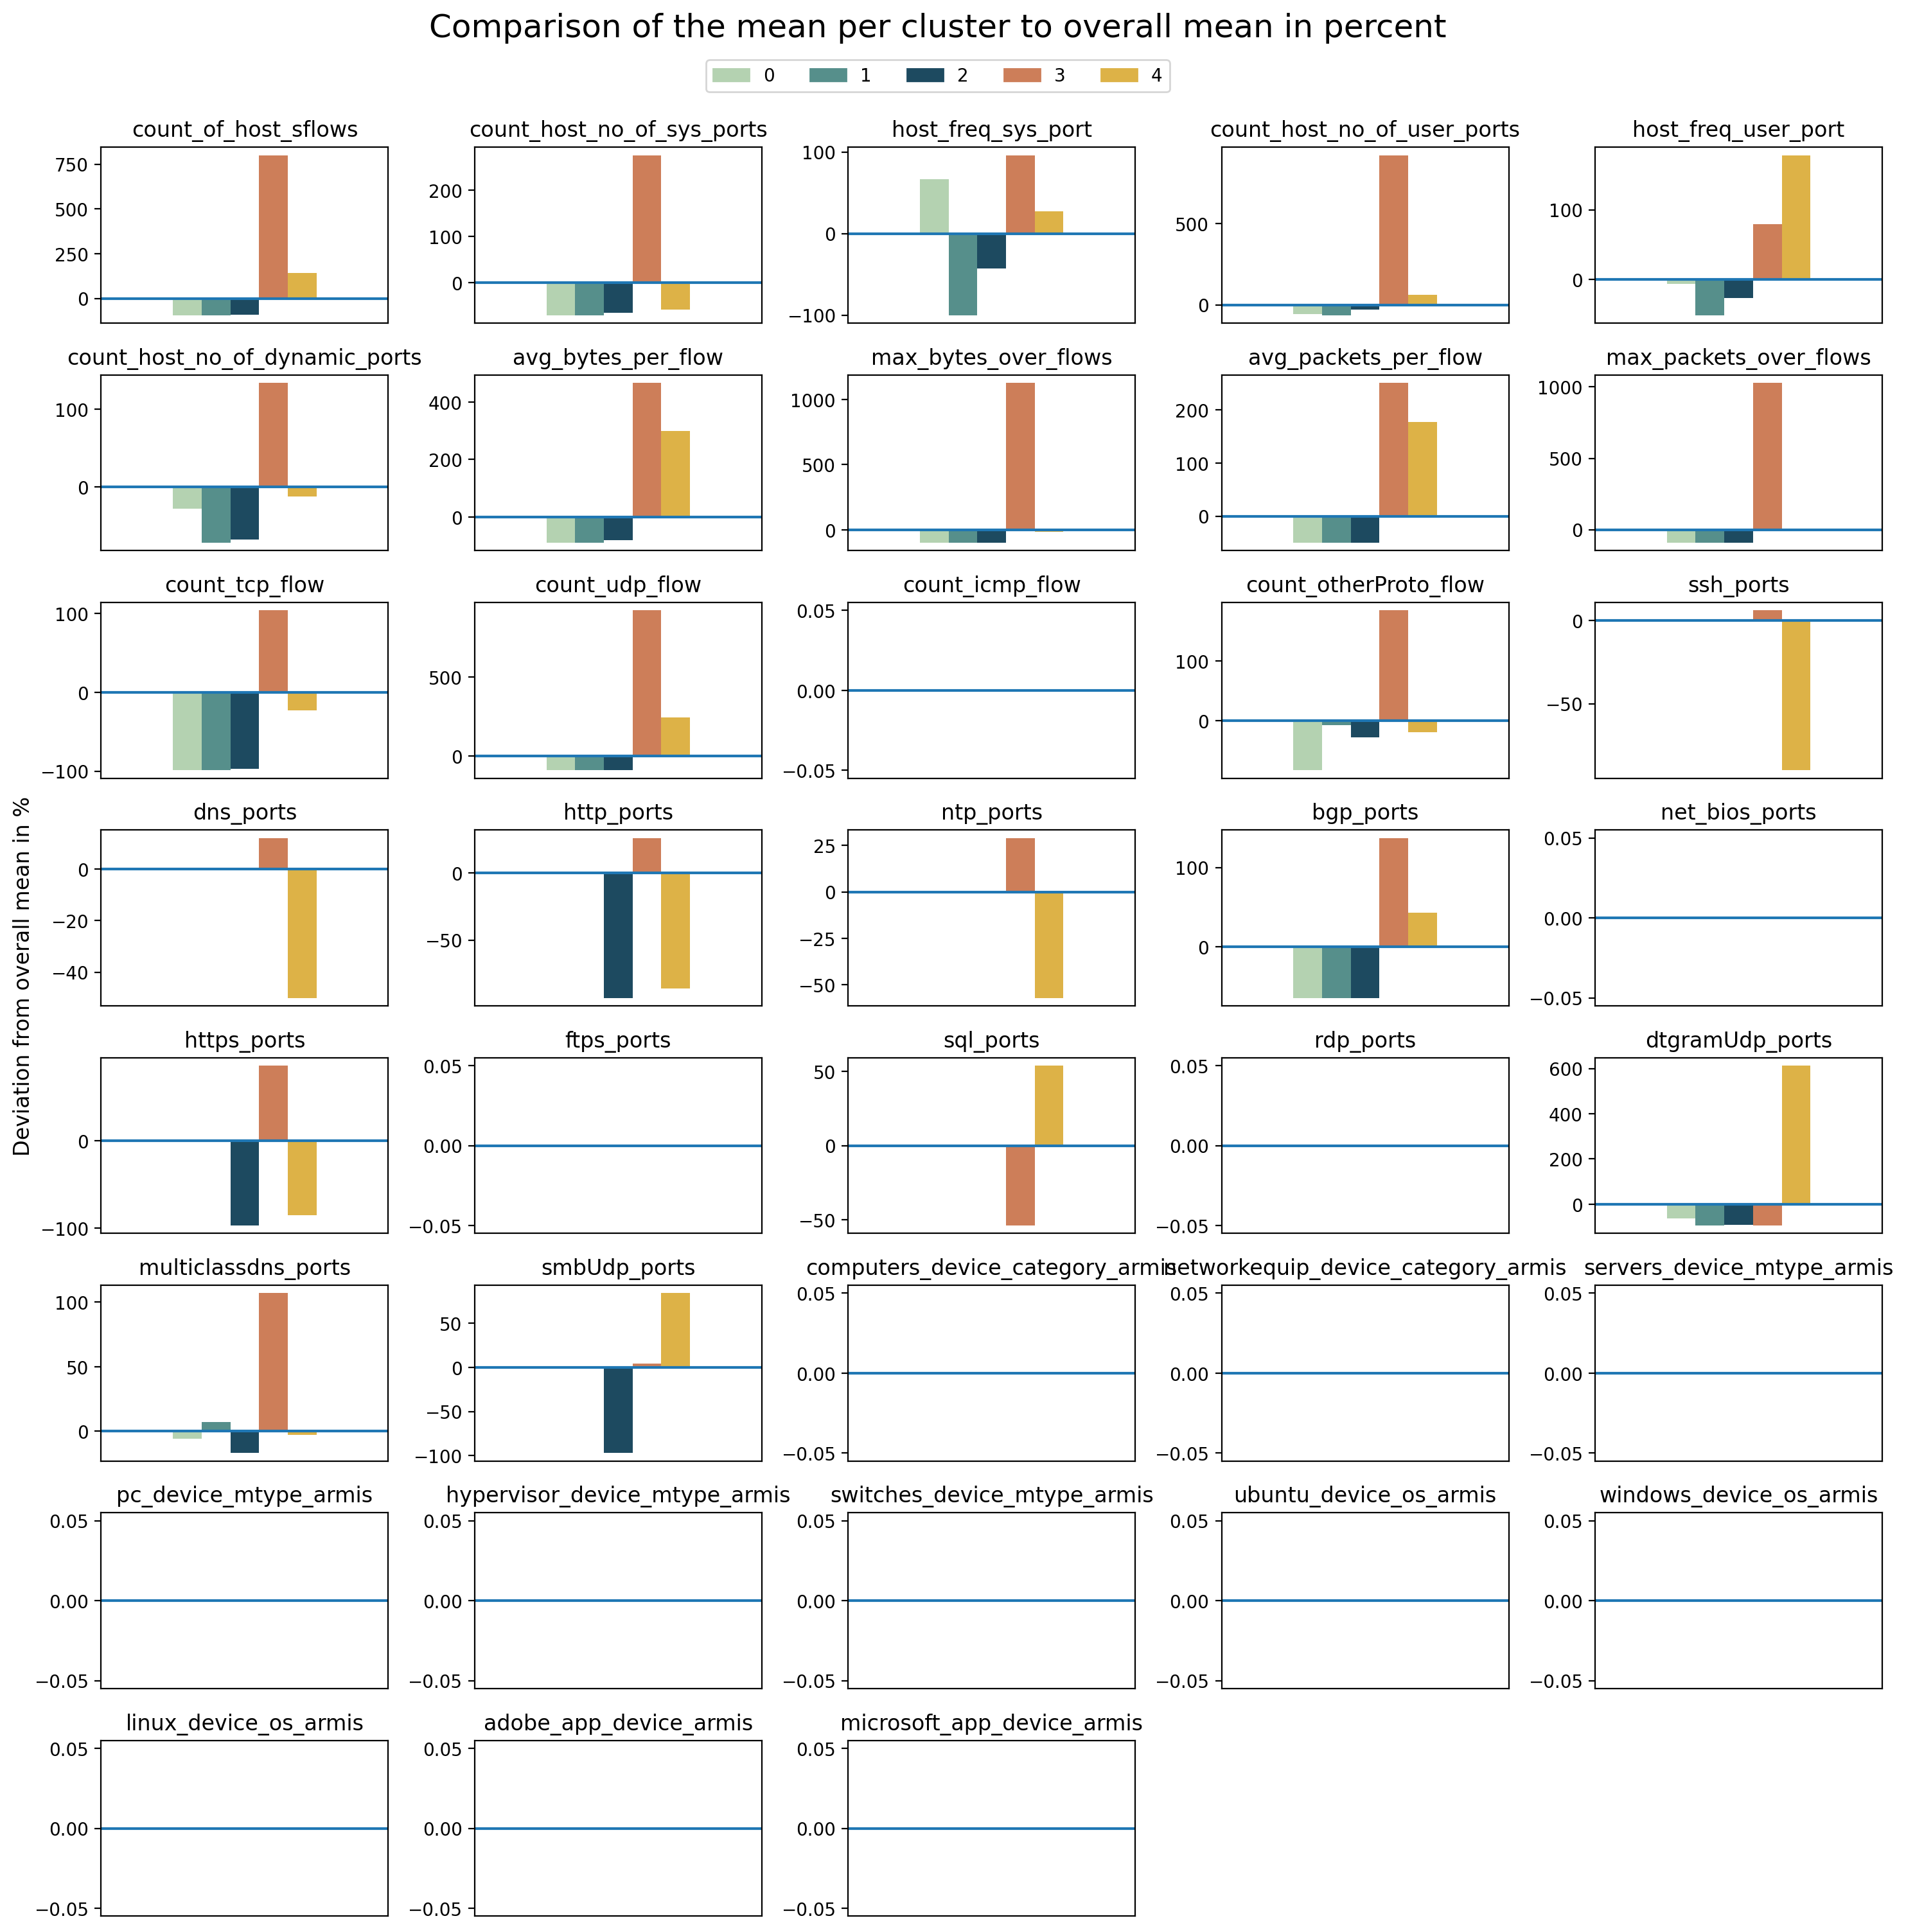

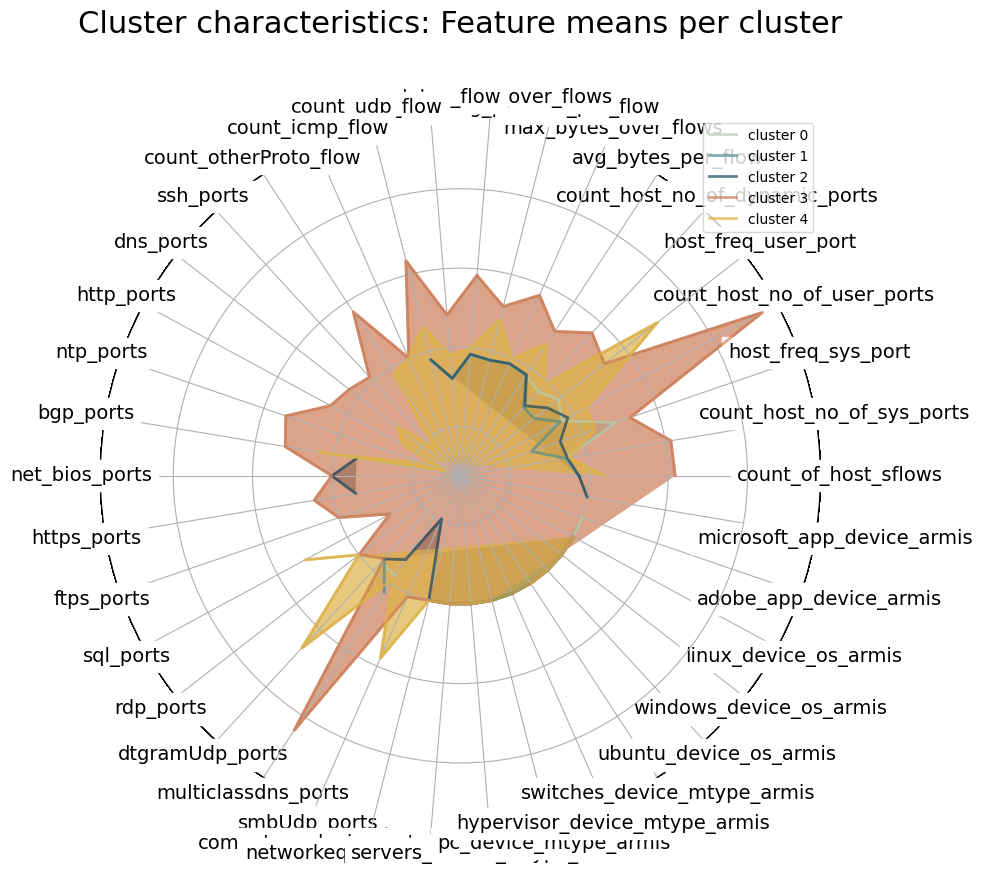

========== alpha=10, reg=0.001 ==========
Start pretraining (totally 10 iterations) ......
5.97959041595459
loss: 5.4841
loss: 5.1553
loss: 4.8368
loss: 4.7313
loss: 4.6060
loss: 4.3577
loss: 5.0753
loss: 4.3258
loss: 4.4785


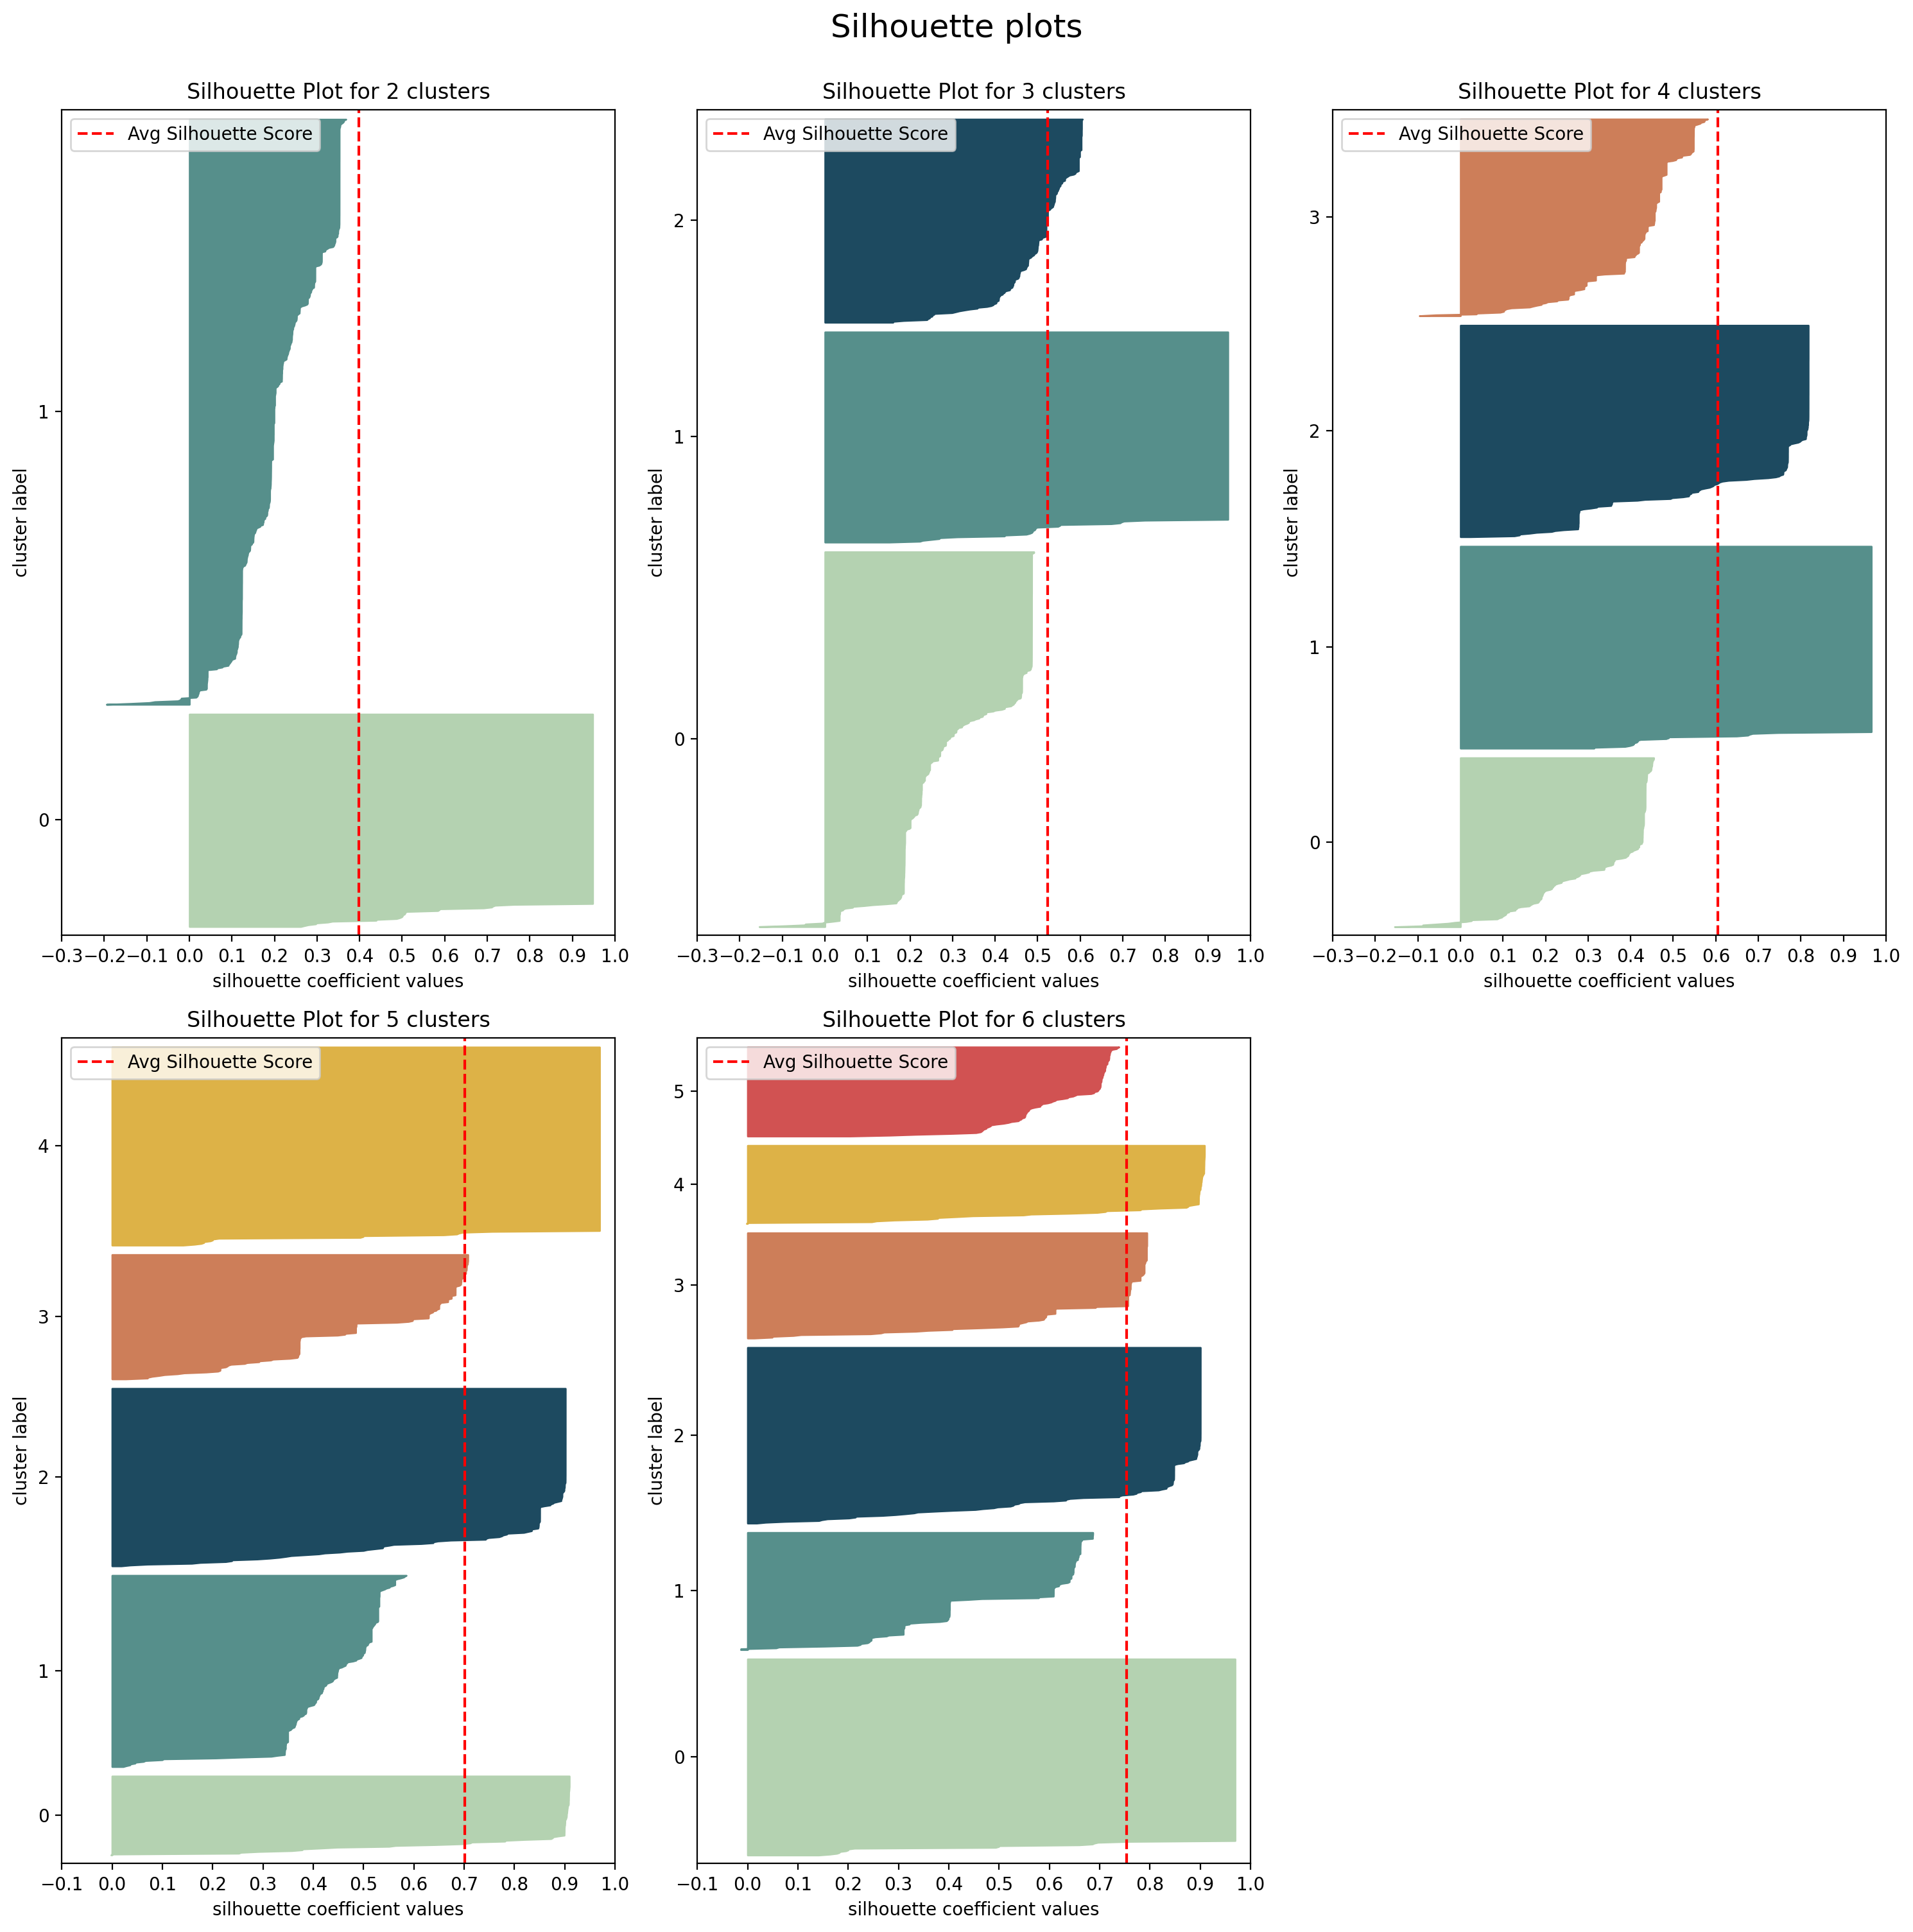

loss: 4.6293
========== reg=10 ==========


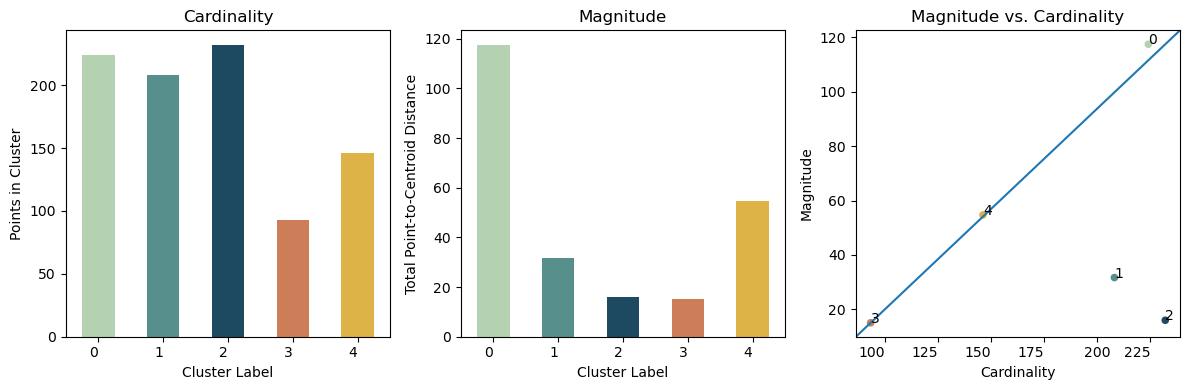

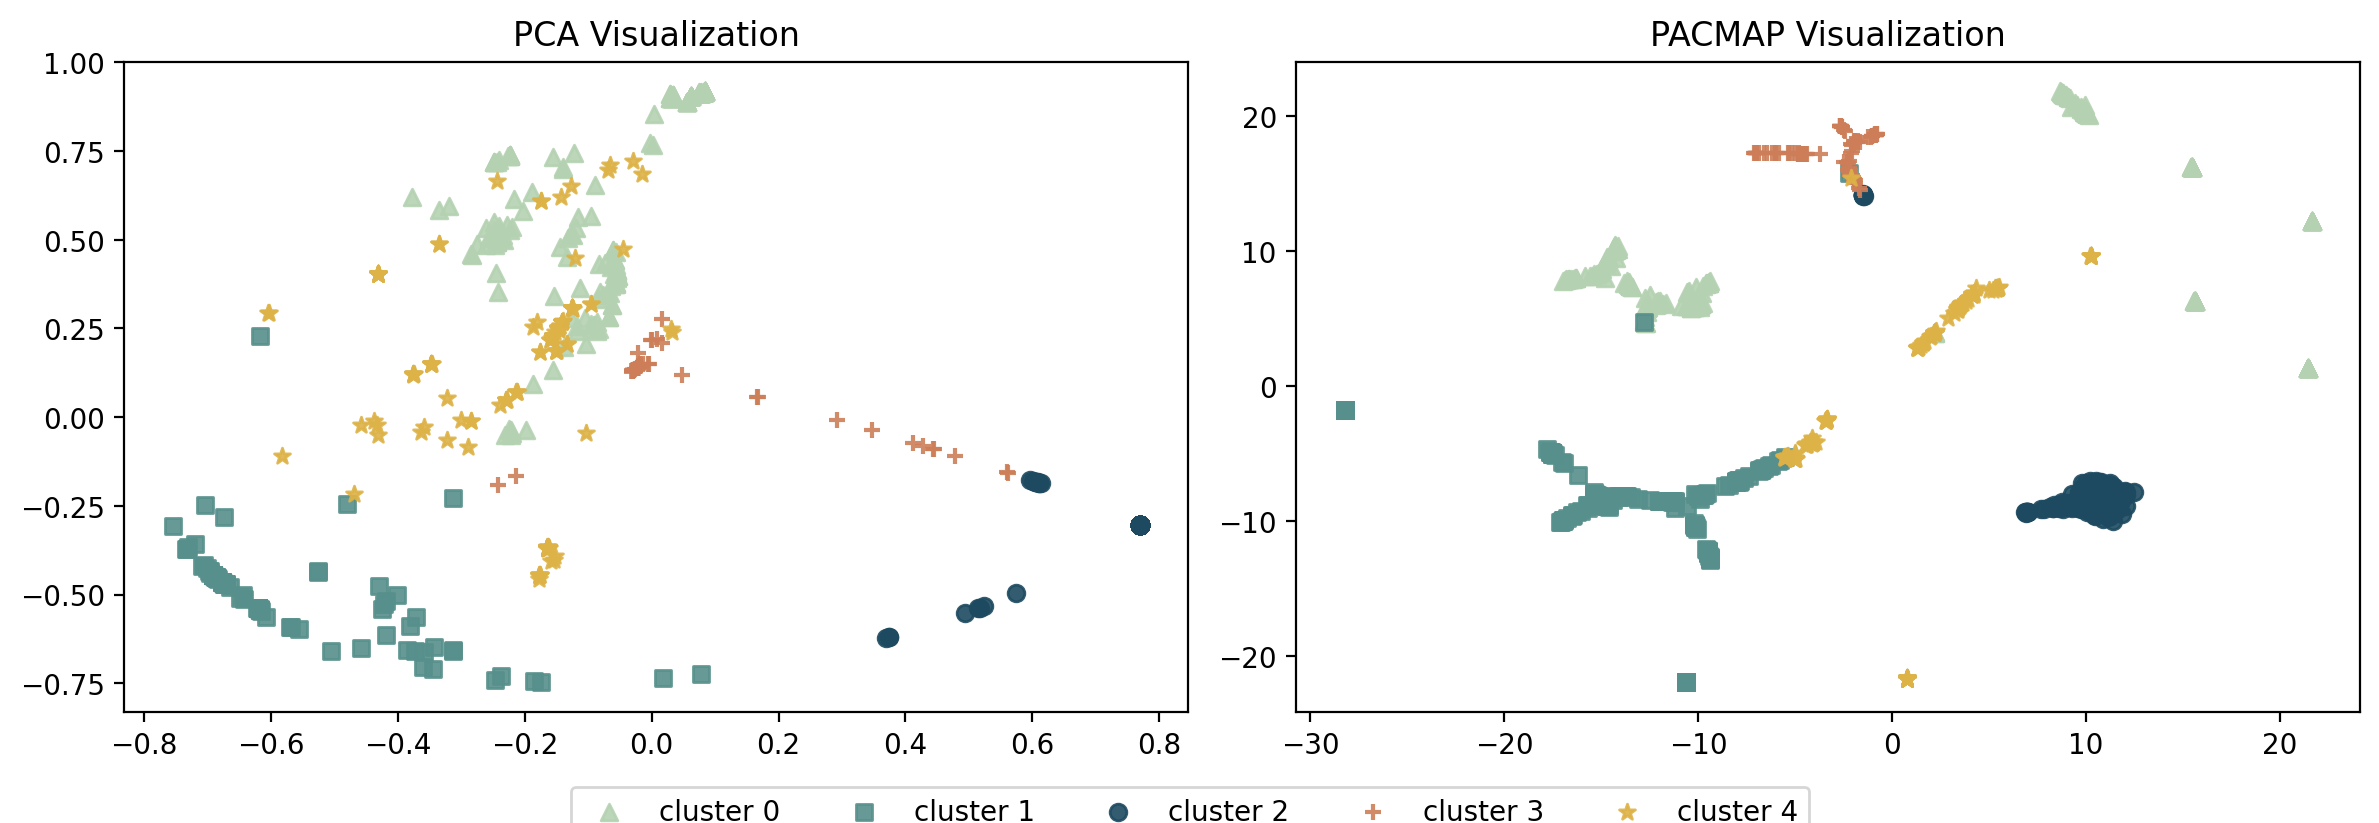

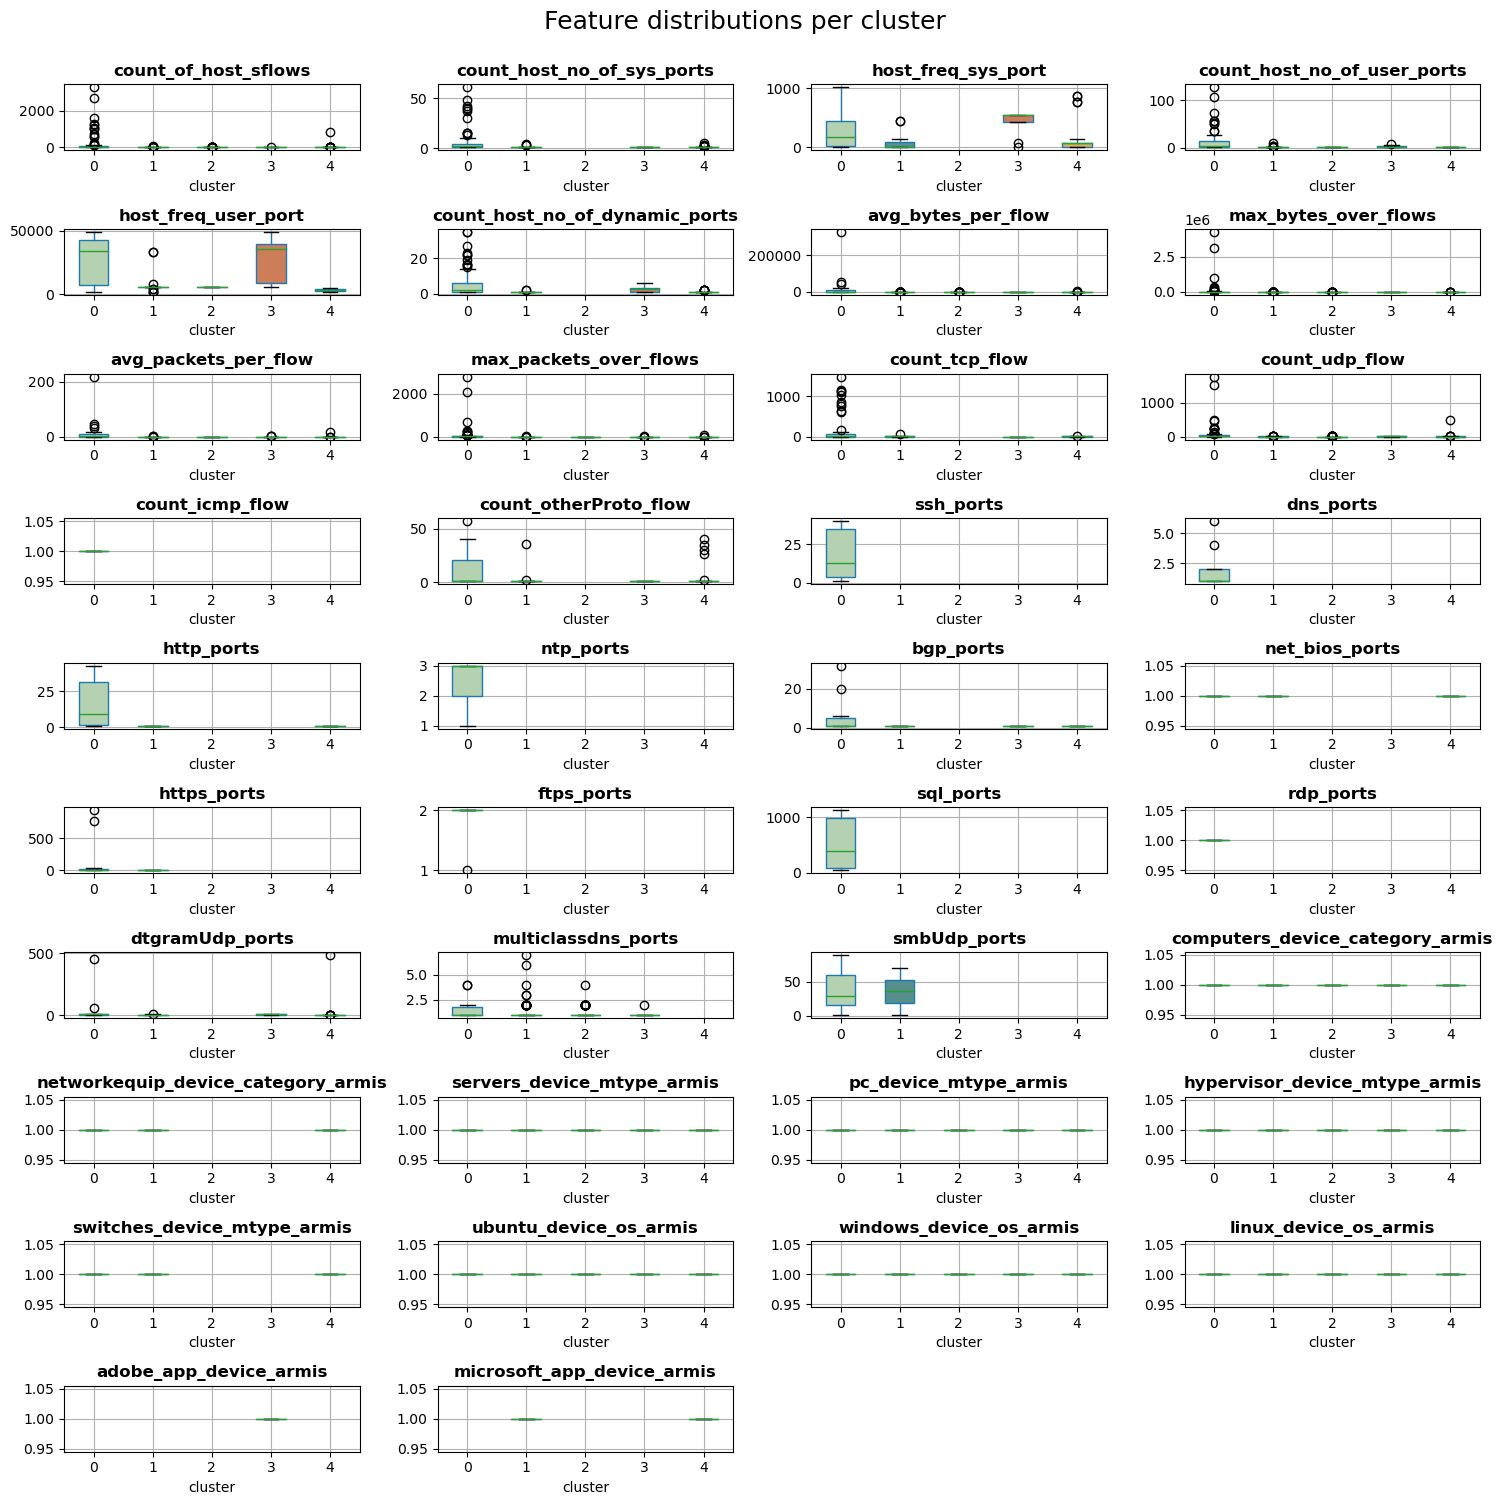

                                   0
cluster category                    
0       Computers          16.517857
        Network Equipment   4.910714
1       Computers          51.923077
        Network Equipment   0.480769
2       Computers          67.672414
3       Computers          34.408602
4       Computers          36.301370
        Network Equipment   1.369863
                                    0
cluster mtype                        
0       Hypervisor           1.339286
        Personal Computers   3.125000
        Servers             12.053571
        Switches             4.017857
1       Hypervisor           1.923077
        Personal Computers   2.403846
        Servers             41.826923
        Switches             0.480769
2       Hypervisor           0.862069
        Personal Computers   4.310345
        Servers             59.913793
3       Hypervisor           2.150538
        Personal Computers   4.301075
        Servers             27.956989
4       Hypervisor    

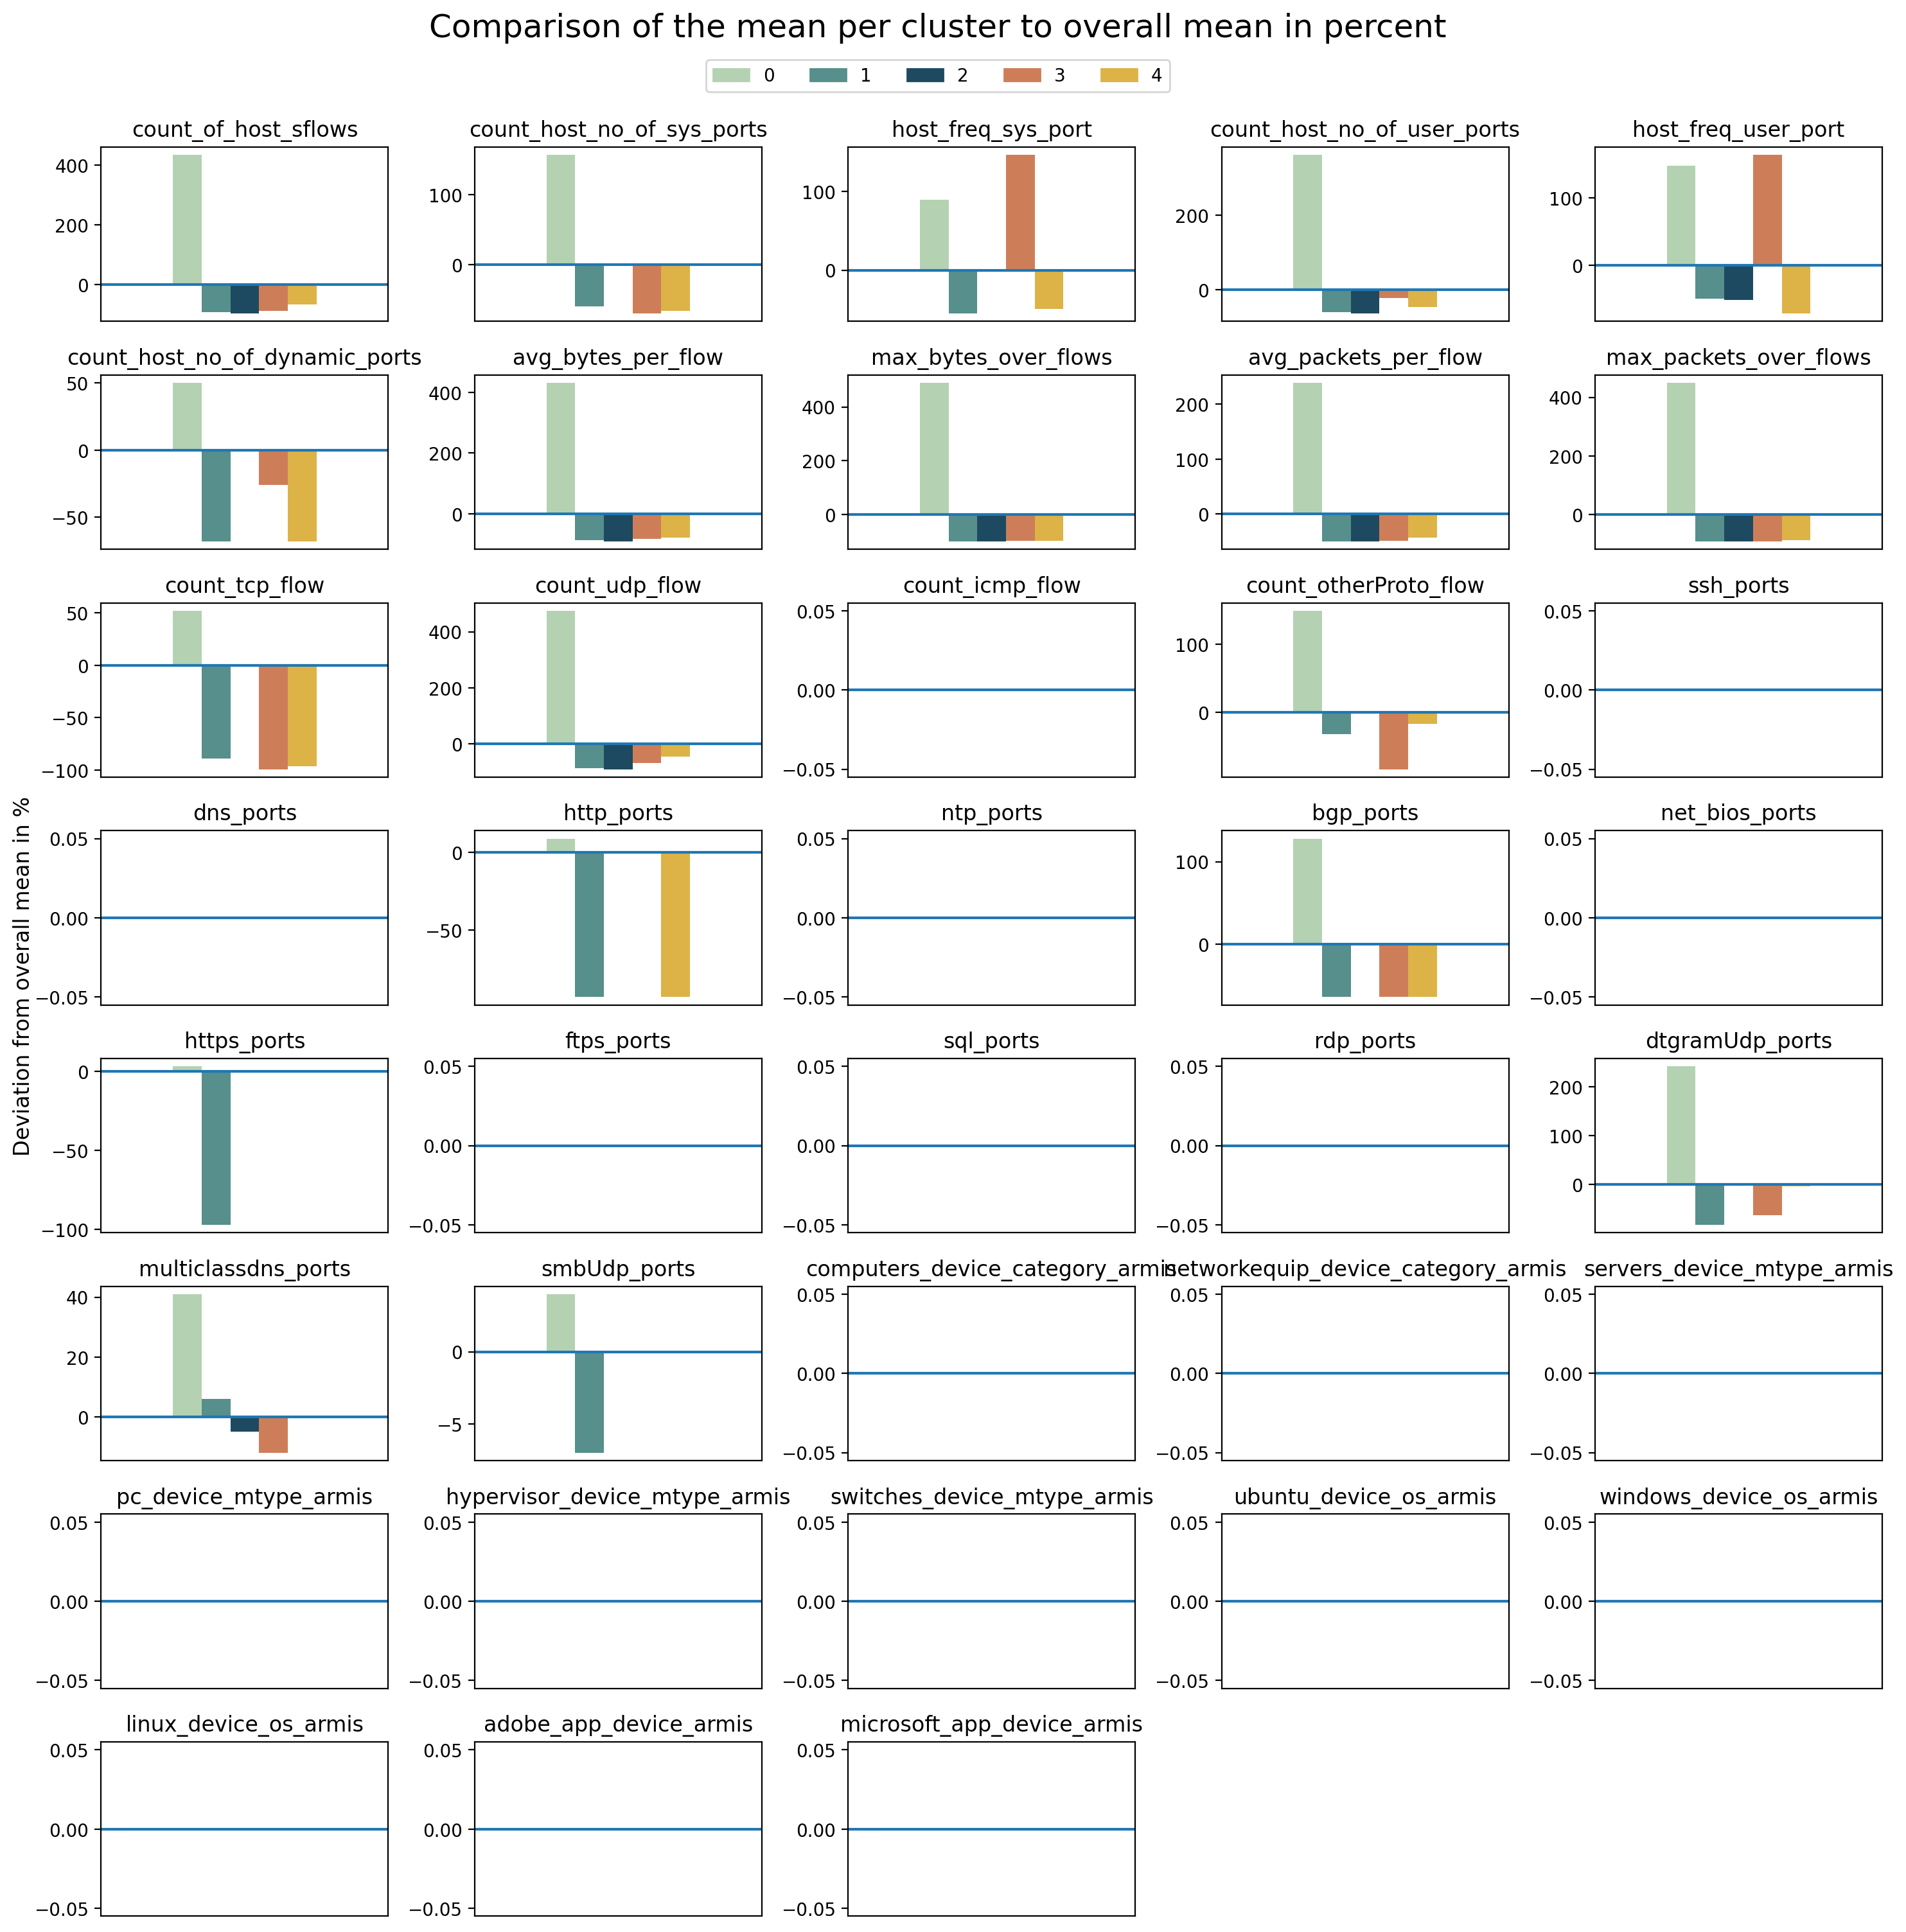

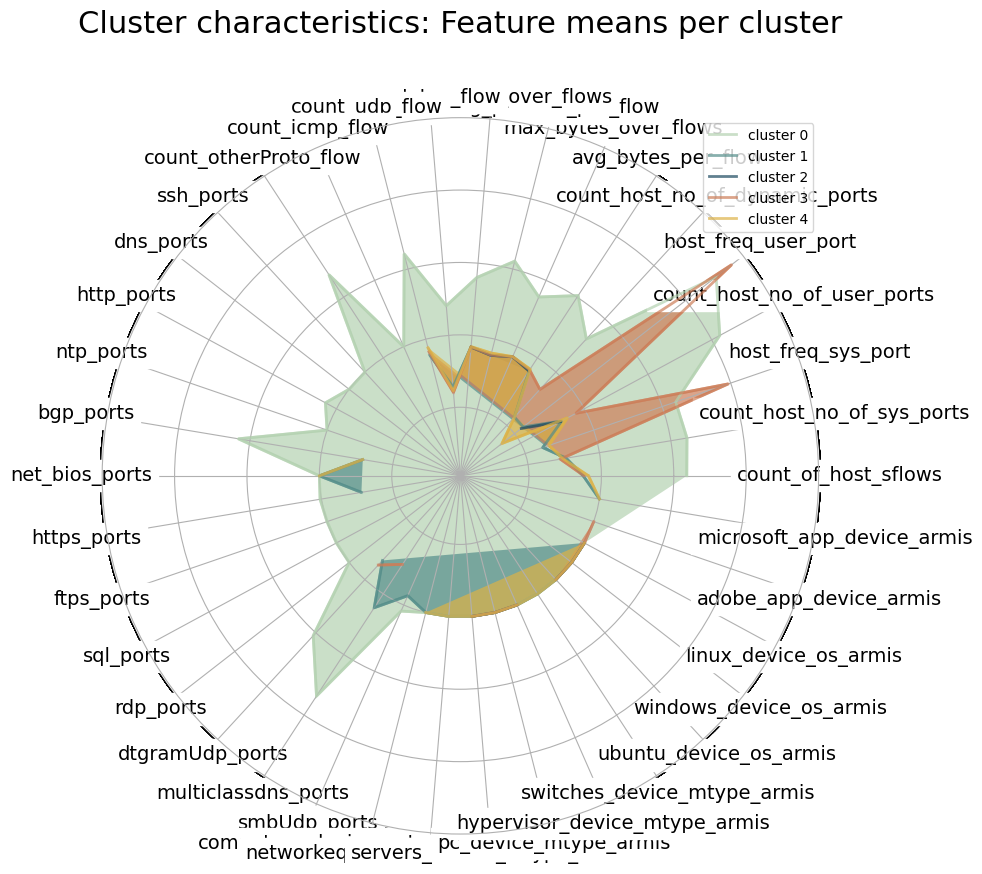

========== alpha=100, reg=0.001 ==========
Start pretraining (totally 10 iterations) ......
5.814568519592285
loss: 5.3269
loss: 4.9794
loss: 4.5246
loss: 4.4645
loss: 4.2991
loss: 4.9493
loss: 4.6875
loss: 4.7754
loss: 4.7704


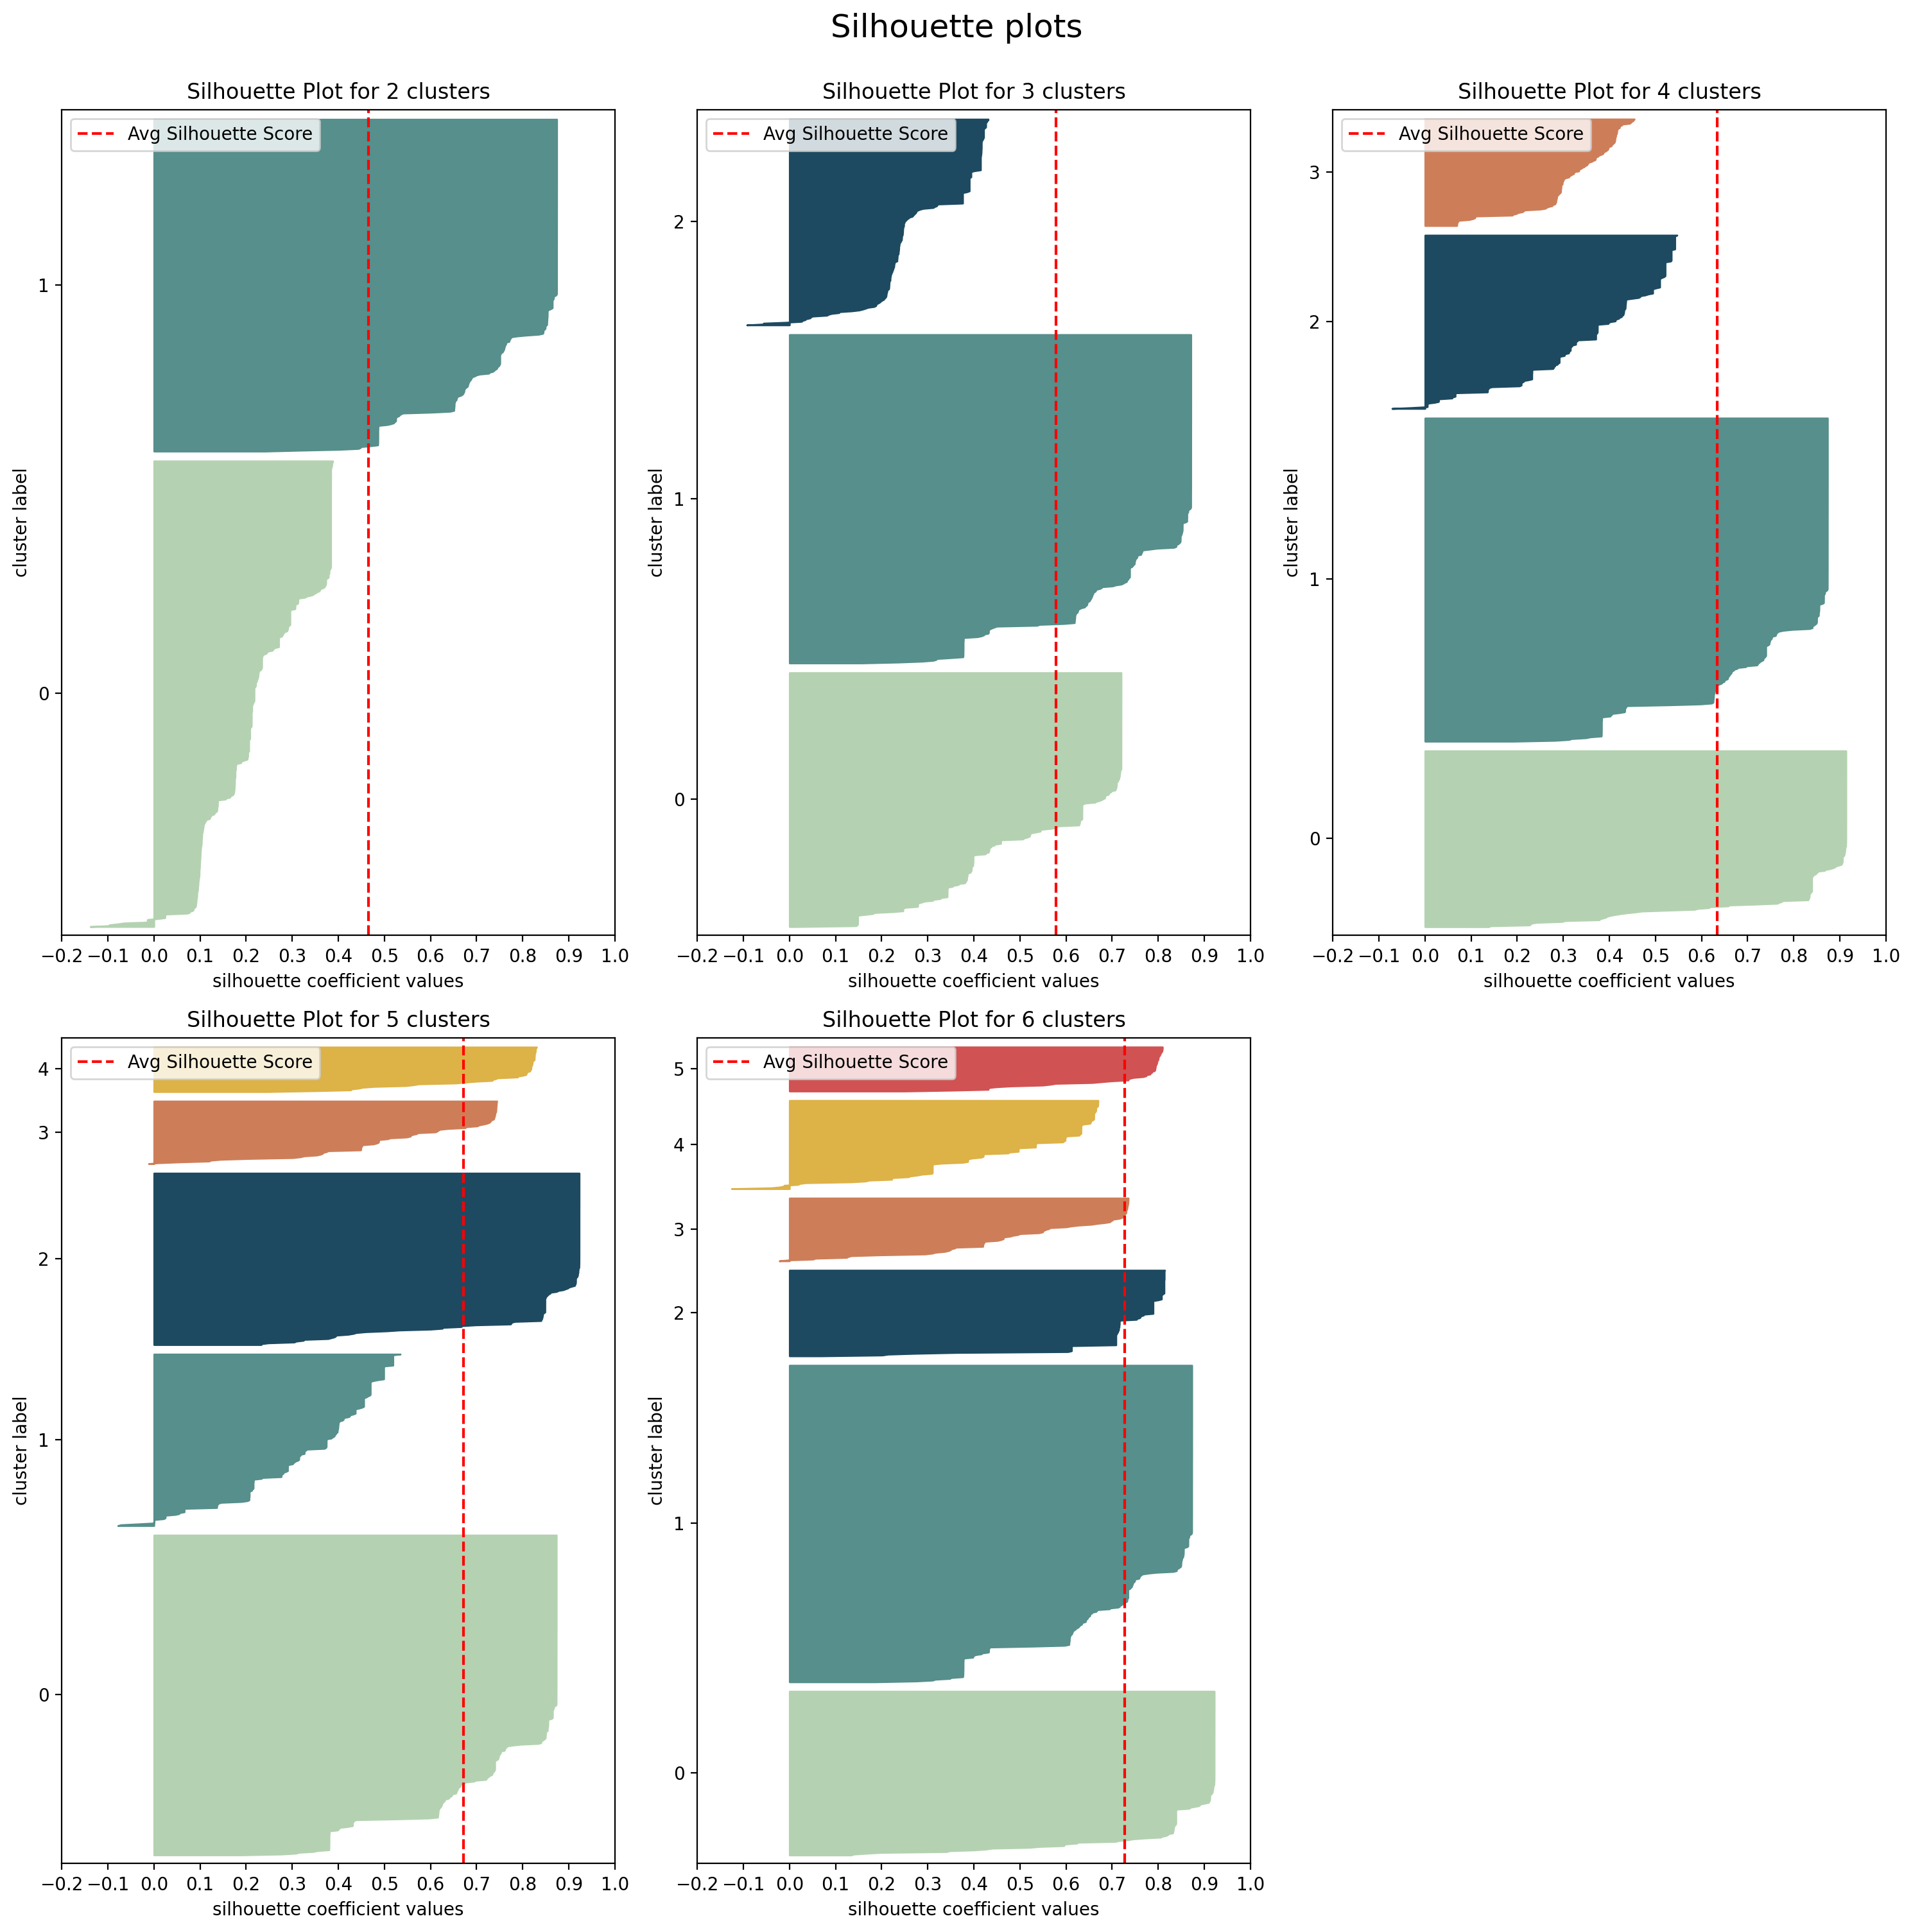

loss: 4.7461
========== reg=100 ==========


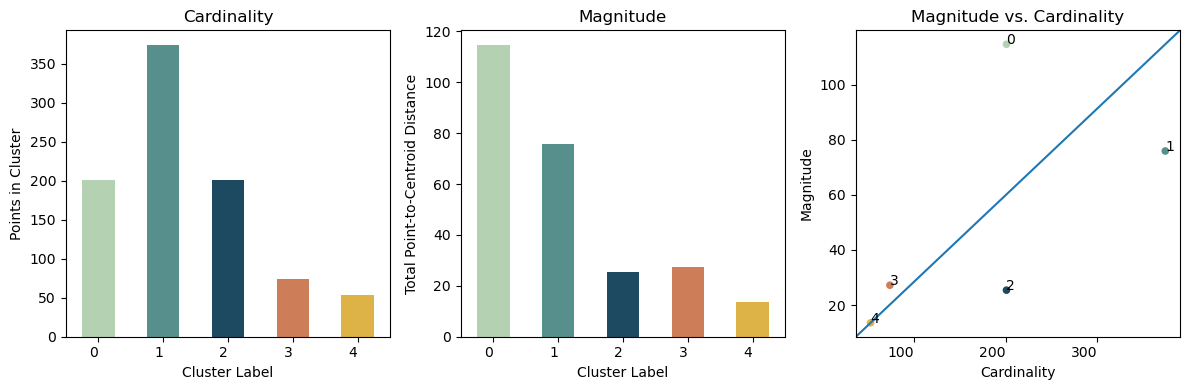

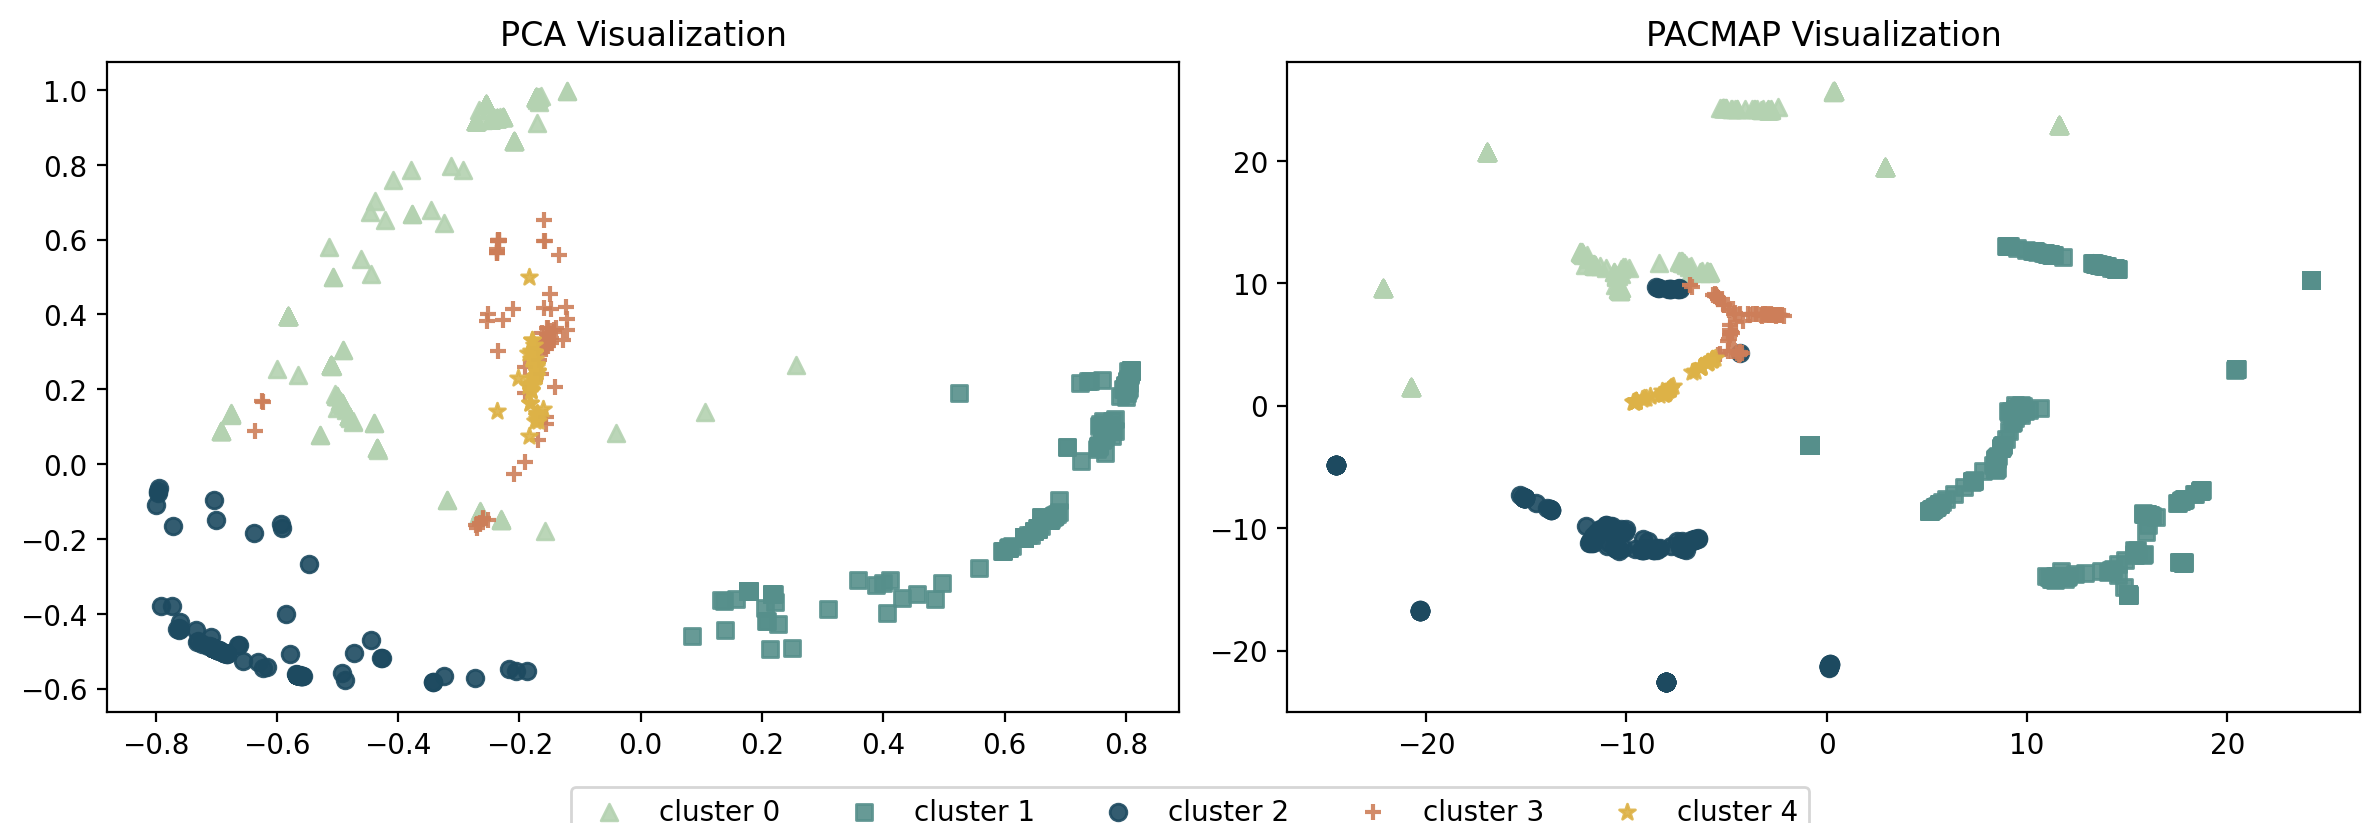

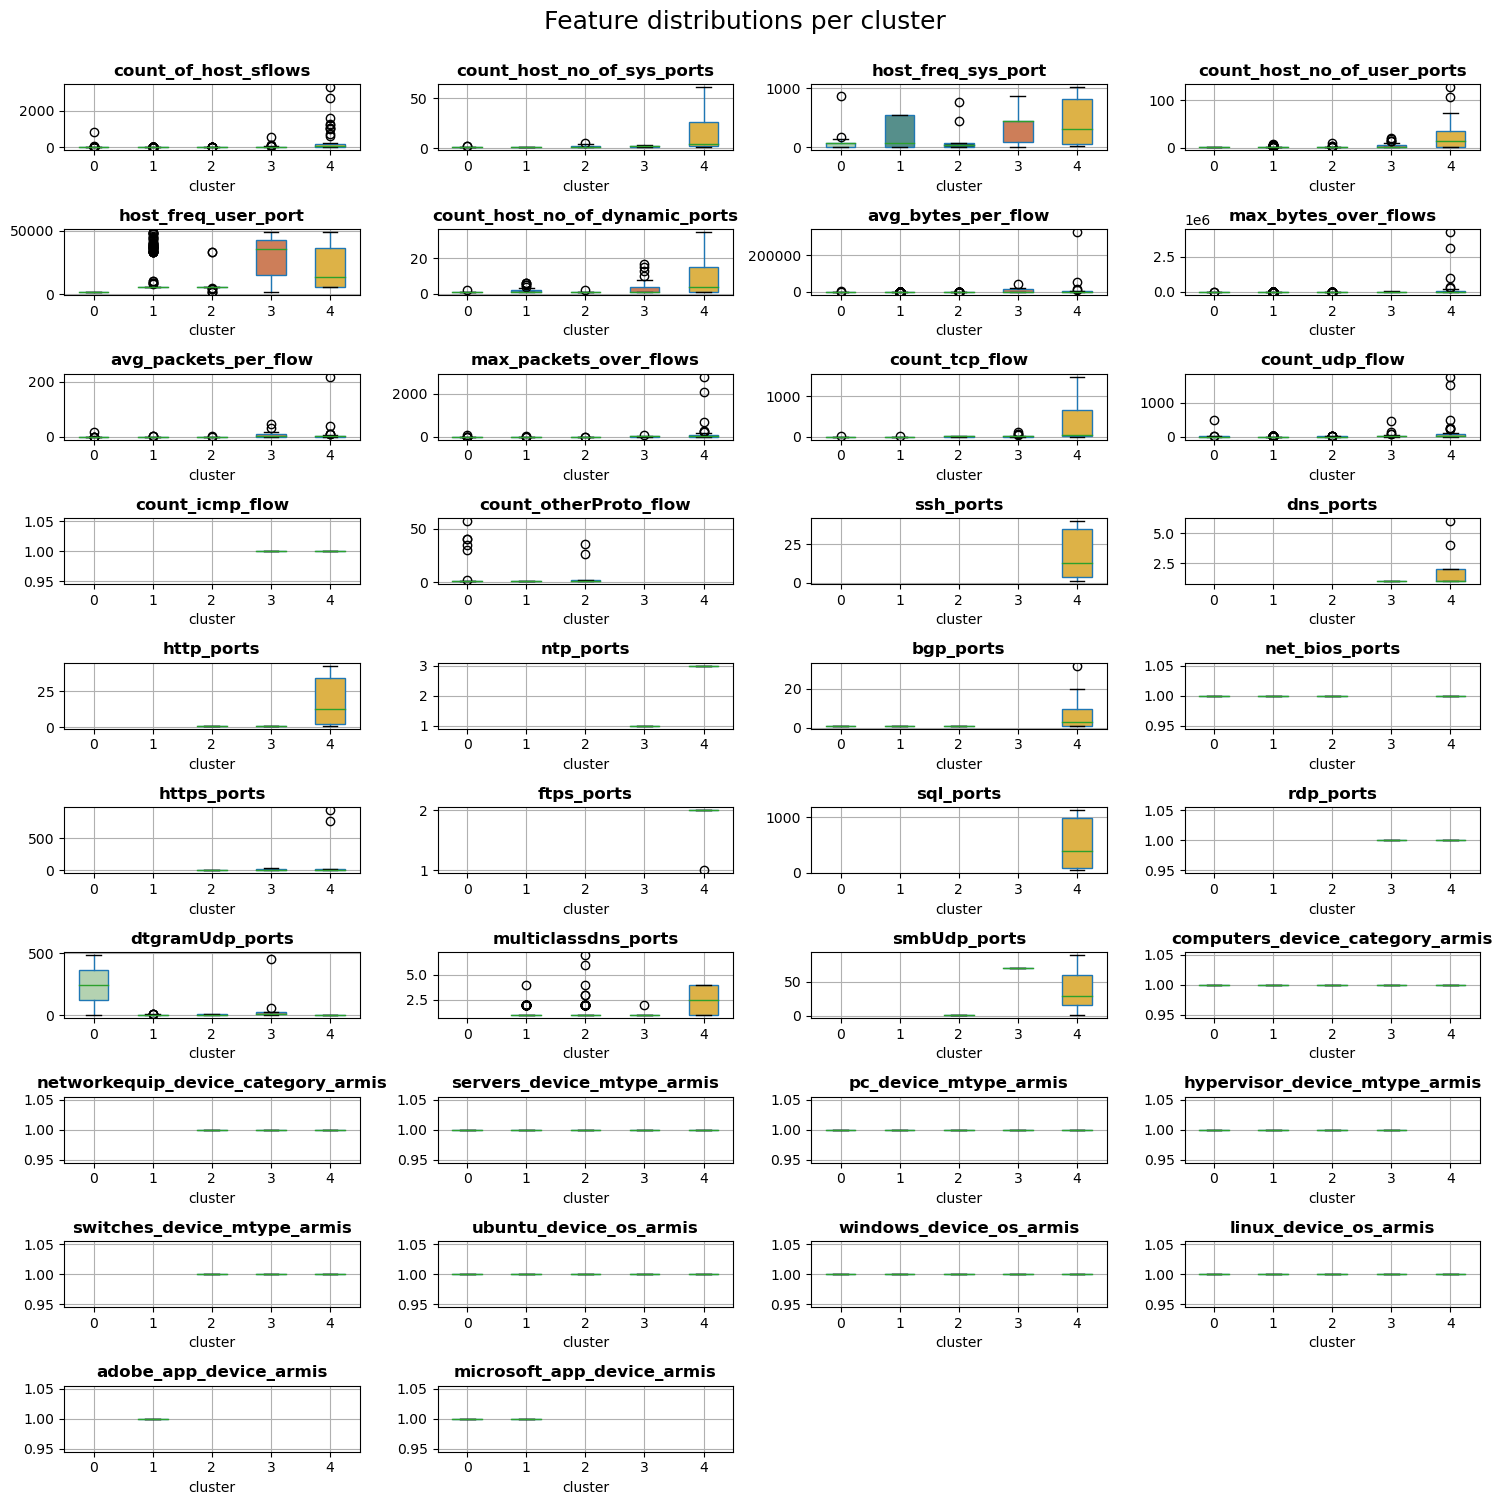

                                   0
cluster category                    
0       Computers          22.885572
1       Computers          57.219251
2       Computers          49.253731
        Network Equipment   0.995025
3       Computers          28.378378
        Network Equipment   5.405405
4       Computers          13.207547
        Network Equipment  15.094340
                                    0
cluster mtype                        
0       Hypervisor           1.492537
        Personal Computers   0.995025
        Servers             20.398010
1       Hypervisor           1.604278
        Personal Computers   5.080214
        Servers             48.930481
2       Hypervisor           1.492537
        Personal Computers   2.487562
        Servers             39.303483
        Switches             0.995025
3       Hypervisor           4.054054
        Personal Computers   4.054054
        Servers             20.270270
        Switches             2.702703
4       Personal Compu

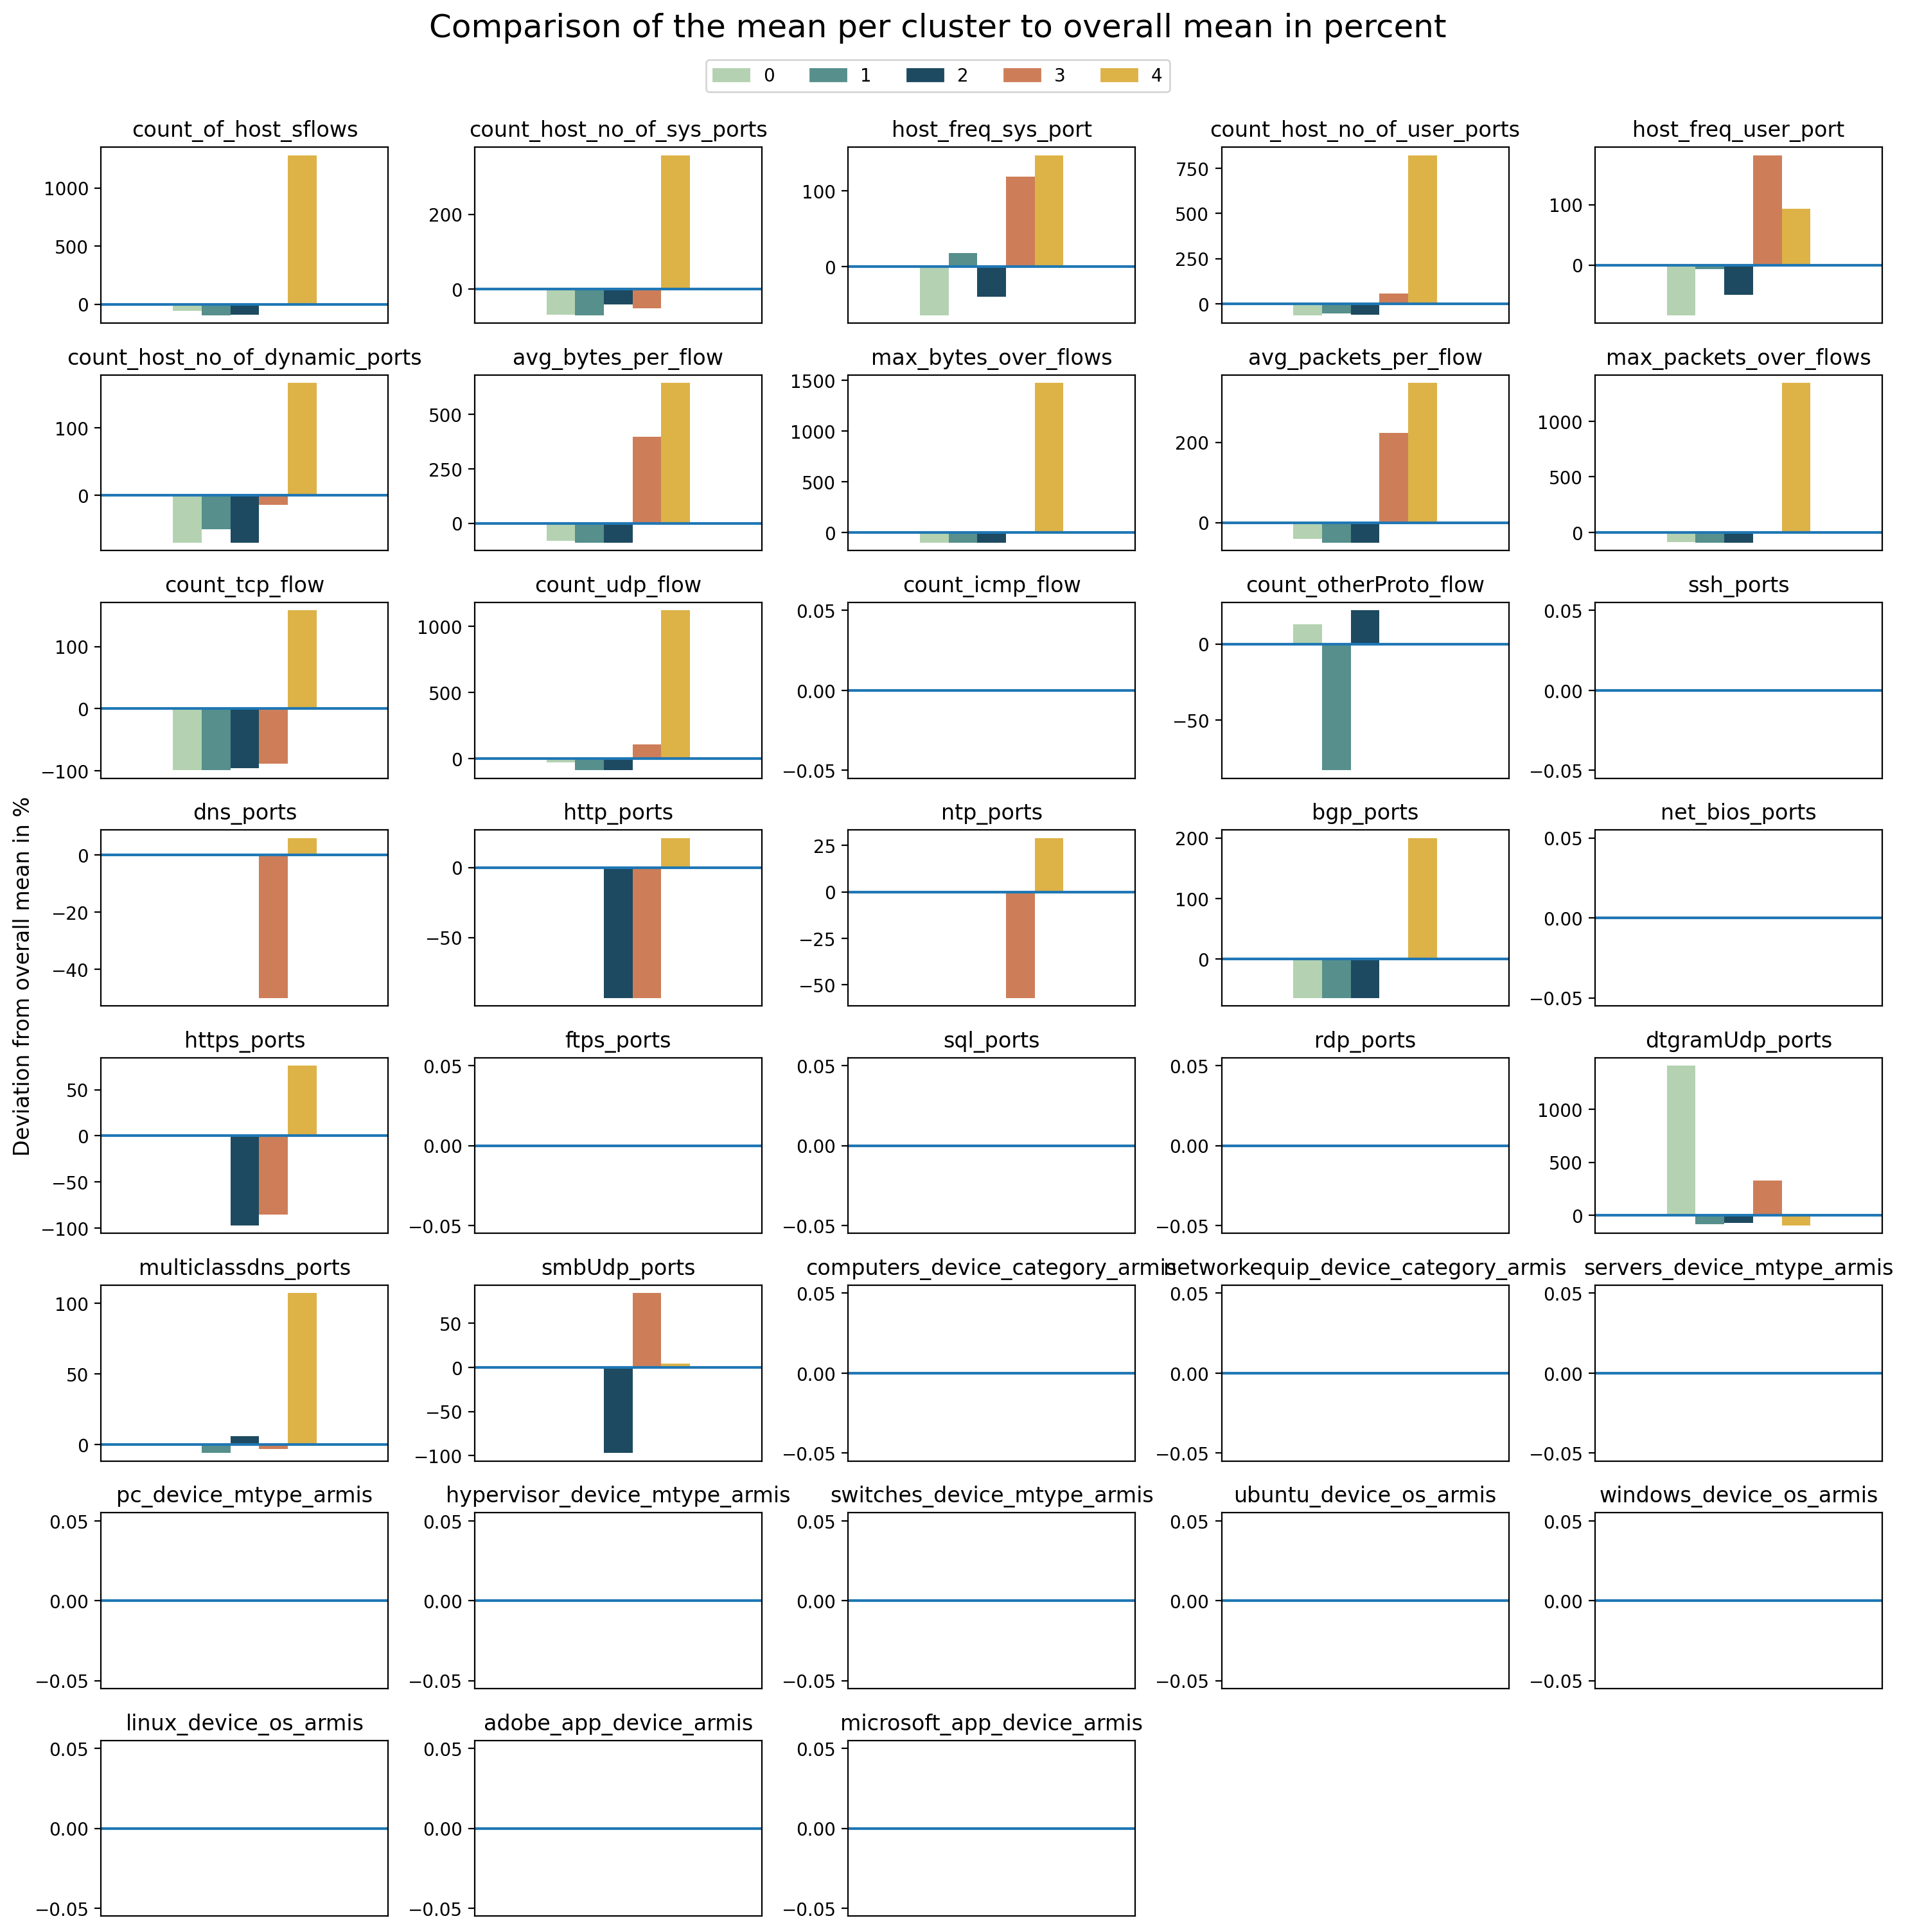

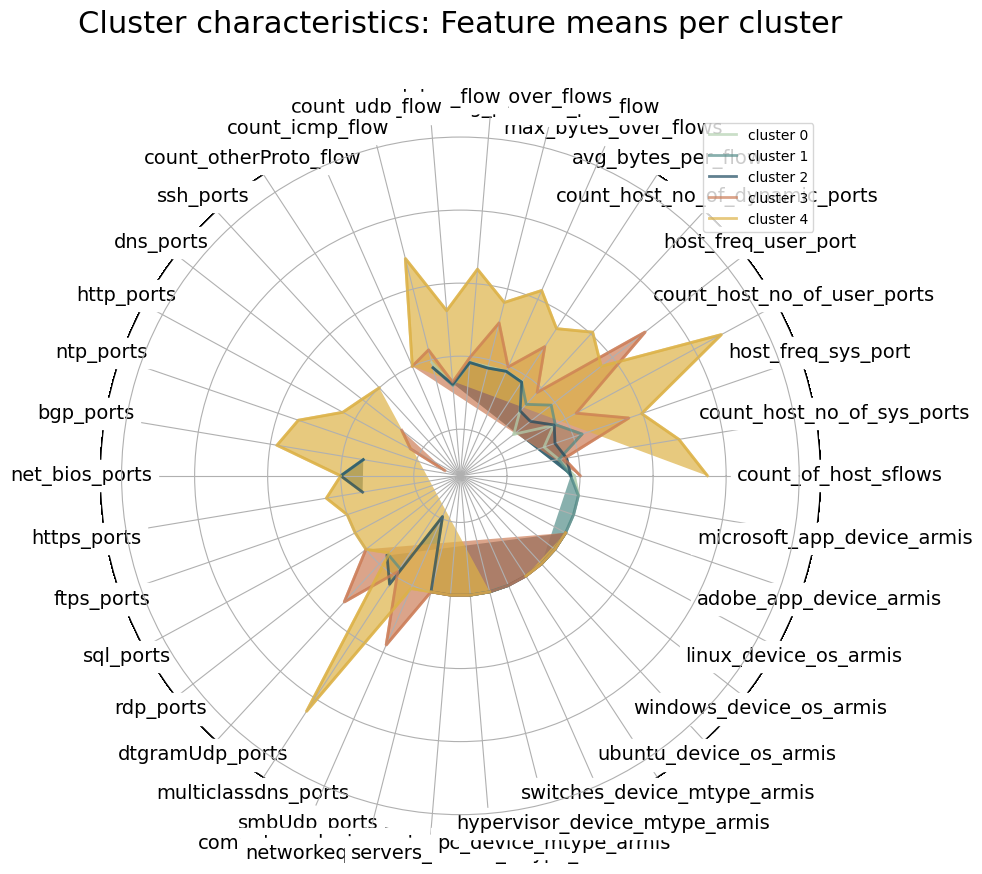

In [22]:

#feats_mat, adj_mat, feat_df, mac_dict = main_s()
#preds, feat_df, mac_dict, adj_mat, sflow_raw, km, X = main_s()
clust_dict = main_s()

### Next steps: 

1. Now that we have evaluated different clusering options, we select the one config where silhouette score is greater or equal than the threshold for all clusters.
2. Extract the updated embedding/indicator for each mac_id (node in the graph). This embedding encapsulates both features (per node) and its connections from the graph (using adjacency matrix)

In [24]:
#clust_dict[0.1]

emb = clust_dict[0.1]['X']
#type(emb)

copy_feat_df = feat_df.copy(deep=True)

emb_df = pd.DataFrame(emb, columns=['emb1','emb2','emb3','emb4','emb5'])
emb_df.shape

feature_emb_df = pd.concat([copy_feat_df, emb_df], axis=1)
feature_emb_df.shape

(903, 46)

In [25]:
feature_emb_df.head()

raw_mac  mac_id  count_of_host_sflows  \
0  a5:bc:6f:8b:43:d4       0                   2.0   
1  60:62:44:81:7d:ff       1                   1.0   
2  c9:aa:ca:e6:a9:98       2                   1.0   
3  23:3c:8e:28:68:63       3                   3.0   
4  30:74:a3:c9:fe:97       4                   1.0   

   count_host_no_of_sys_ports  host_freq_sys_port  \
0                         NaN                 NaN   
1                         NaN                 NaN   
2                         NaN                 NaN   
3                         1.0                 0.0   
4                         NaN                 NaN   

   count_host_no_of_user_ports  host_freq_user_port  \
0                          1.0               5353.0   
1                          1.0               5353.0   
2                          1.0               5353.0   
3                          1.0              16670.0   
4                          1.0               5353.0   

   count_host_no_of_dynamic_ports  avg_bytes_per_flow  max_bytes_over_flows  \
0                             NaN               129.0                 129.0   
1                             NaN               149.0                 149.0   
2                             NaN               109.0                 109.0   
3                             1.0                96.0                 148.0   
4                             NaN               149.0                 149.0   

   avg_packets_per_flow  max_packets_over_flows  count_tcp_flow  \
0                   1.0                     1.0             NaN   
1                   1.0                     1.0             NaN   
2                   1.0                     1.0             NaN   
3                   1.0                     1.0             2.0   
4                   1.0                     1.0             NaN   

   count_udp_flow  count_icmp_flow  count_otherProto_flow  ssh_ports  \
0             2.0              NaN                    NaN        NaN   
1             1.0              NaN                    NaN        NaN   
2             1.0              NaN                    NaN        NaN   
3             NaN              1.0                    NaN        NaN   
4             1.0              NaN                    NaN        NaN   

   dns_ports  http_ports  ntp_ports  bgp_ports  net_bios_ports  https_ports  \
0        NaN         NaN        NaN        NaN             NaN          NaN   
1        NaN         NaN        NaN        NaN             NaN          NaN   
2        NaN         NaN        NaN        NaN             NaN          NaN   
3        NaN         NaN        NaN        NaN             NaN          NaN   
4        NaN         NaN        NaN        NaN             NaN          NaN   

   ftps_ports  sql_ports  rdp_ports  dtgramUdp_ports  multiclassdns_ports  \
0         NaN        NaN        NaN              NaN                  2.0   
1         NaN        NaN        NaN              NaN                  1.0   
2         NaN        NaN        NaN              NaN                  1.0   
3         NaN        NaN        NaN              NaN                  NaN   
4         NaN        NaN        NaN              NaN                  1.0   

   smbUdp_ports  computers_device_category_armis  \
0           NaN                              NaN   
1           NaN                              1.0   
2           NaN                              1.0   
3           NaN                              NaN   
4           NaN                              1.0   

   networkequip_device_category_armis  servers_device_mtype_armis  \
0                                 NaN                         NaN   
1                                 NaN                         1.0   
2                                 NaN                         NaN   
3                                 NaN                         NaN   
4                                 NaN                         NaN   

   pc_device_mtype_armis  hypervisor_device_mtype_armis  \
0 

In [26]:
# Armis data has multiple devices linked to same mac, hence separating and getting them independently

for i in range(0, 5):
    armis_data_device['mac_address_' + str(i)] = None
temp_res = armis_data_device['mac_address'].apply(lambda x : x.split(','))
for index, row in armis_data_device.iterrows():
    for i in range(min(5, len(temp_res[index]))):
        armis_data_device.loc[index,'mac_address_' + str(i)] = temp_res[index][i]
armis_data_device.head()

mac_address   category  \
0  ed:00:72:91:55:4c  Computers   
1  25:c9:2a:3f:3a:6f  Computers   
2  db:32:80:d6:e9:cc  Computers   
3  2b:ac:3f:44:ef:1f  Computers   
4  ab:06:71:9e:ed:11  Computers   

                                      manufacturer  \
0                         Computers Manufacturer 7   
1  Computers and Network Equipment Manufacturer 14   
2  Computers and Network Equipment Manufacturer 14   
3  Computers and Network Equipment Manufacturer 14   
4                         Computers Manufacturer 3   

                                      model            name operatingSystem  \
0                         Computers Model 0  Computers 1709           Linux   
1                         Computers Model 1  Computers 1298          Ubuntu   
2  Computers and Network Equipment Model 28   Computers 754             NaN   
3                         Computers Model 1  Computers 1311          Ubuntu   
4                         Computers Model 4   Computers 669         Windows   

  operatingSystemVersion  riskLevel               mtype      mac_address_0  \
0                    NaN          6             Servers  ed:00:72:91:55:4c   
1                  18.04          4             Servers  25:c9:2a:3f:3a:6f   
2                    NaN          1             Servers  db:32:80:d6:e9:cc   
3                  18.04          4             Servers  2b:ac:3f:44:ef:1f   
4            Server 2022          7  Personal Computers  ab:06:71:9e:ed:11   

  mac_address_1 mac_address_2 mac_address_3 mac_address_4  
0          None          None          None          None  
1          None          None          None          None  
2          None          None          None          None  
3          None          None          None          None  
4          None          None          None          None

### Mapping feature dataframe with category, mtype, manufacturer, device name and risklevel information from armis

In [27]:
feat_df['category'] = None
feat_df['mtype'] = None
feat_df['manufacturer'] = None
feat_df['name'] = None
feat_df['riskLevel'] = None

for index, row in feat_df.iterrows():
    mac = row['raw_mac']
    match_row = armis_data_device.loc[(armis_data_device.mac_address_0==mac) |
                                      (armis_data_device.mac_address_1==mac) |
                                      (armis_data_device.mac_address_2==mac) |
                                      (armis_data_device.mac_address_3==mac) |
                                      (armis_data_device.mac_address_4==mac)
                                     ]
    if match_row.shape[0]>0:
        feat_df.loc[index, 'category'] = match_row['category'].iloc[0]
        feat_df.loc[index, 'mtype'] = match_row['mtype'].iloc[0]
        feat_df.loc[index, 'manufacturer'] = match_row['manufacturer'].iloc[0]
        feat_df.loc[index, 'name'] = match_row['name'].iloc[0]
        feat_df.loc[index, 'riskLevel'] = match_row['riskLevel'].iloc[0]
    else:
        continue

### Cluster visualization


When armis returns no data, mark as unknown for Viz

In [28]:
feat_df['cluster'] = clust_dict[0.1]['predictions']
feat_df['category'].isnull().sum()
feat_df['category'].fillna(value='Unknown', inplace=True)

feat_df['name'].fillna(value='Unknown', inplace=True)


In [29]:
net = Network(filter_menu=True, notebook=True)
#net.toggle_physics(False)
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
attrs = {}
for raw_mac, mac_id in mac_dict.items():
    attrs[mac_id] = {
        #"name":raw_mac,
        "group":int(feat_df.loc[feat_df.mac_id==mac_id,'cluster'].iloc[0]),
        "label":feat_df.loc[feat_df.mac_id==mac_id,'category'].iloc[0],
        #"dev":feat_df.loc[feat_df.mac_id==mac_id,'mtype'].iloc[0],
        "title": feat_df.loc[feat_df.mac_id==mac_id,'name'].iloc[0],
        "color": cluster_colors[feat_df.loc[feat_df.mac_id==mac_id,'cluster'].iloc[0]]
    }
G_2 = G.copy()
nx.set_node_attributes(G_2, attrs)

### The networkX viz used in RSA and other presentations

In [30]:
net.from_nx(G_2)
net.show('ac_v3.html')

ac_v3.html


<font color=#b4d2b1>**Cluster 1**</font>, 
<font color='#568f8b'>**Cluster 2**</font>,
<font color=#1d4a60>**Cluster 3**</font>,
<font color=#cd7e59>**Cluster 4**</font>
and <font color=#ddb247>**Cluster 5**</font>.

### Use cases:

#### Inter group communication

In [31]:
sflow_raw.head(5)

SRC_MAC            DST_MAC           SRC_IP           DST_IP  \
0  88:67:e2:88:87:62  0d:81:34:59:a5:70  192.168.102.133      10.50.49.94   
1  14:08:ec:aa:7c:9d  1b:b5:67:2e:d1:fe    172.28.16.147    172.16.44.115   
2  d2:fe:1a:3d:54:2c  a6:15:ec:b8:af:c6    10.219.76.151   172.23.118.139   
3  88:67:e2:88:87:62  0d:81:34:59:a5:70   172.17.239.190      10.50.49.94   
4  51:f1:7e:33:d1:2c  16:87:ca:d2:3d:f8    172.22.69.109  192.168.207.169   

   SRC_PORT  DST_PORT PROTOCOL  SH_COUNTRY  DH_COUNTRY  SH_LAT  SH_LON  \
0       443     34170      tcp         NaN         NaN     0.0     0.0   
1      8182      8182      udp         NaN         NaN     0.0     0.0   
2     20530      4789      udp         NaN         NaN     0.0     0.0   
3       443     54300      tcp         NaN         NaN     0.0     0.0   
4      5434     53626      tcp         NaN         NaN     0.0     0.0   

   DH_LAT  DH_LON             TIMESTAMP_START  PACKETS  BYTES sflow_type  
0     0.0     0.0  0000-00-00 00:00:00.000000        1   1532    cumulus  
1     0.0     0.0  0000-00-00 00:00:00.000000        1    376    cumulus  
2     0.0     0.0  0000-00-00 00:00:00.000000        1   1582    cumulus  
3     0.0     0.0  0000-00-00 00:00:00.000000        1   1532    cumulus  
4     0.0     0.0  0000-00-00 00:00:00.000000        1    105    cumulus

In [18]:
#inter_group = sflow_raw.loc[sflow_raw.SRC_MAC_cluster!=sflow_raw.DST_MAC_cluster]
#inter_group.shape

# Key takeaway: Only 8.5% devices communicate with devices outside of their cluster

In [21]:
#inter_group.shape[0]*100/sflow_raw.shape[0]

In [20]:
#inter_group.sample()

### Conclusion

### Reference
[1]. H. Zhang, P. Li, R. Zhang and X. Li, "Embedding Graph Auto-Encoder for Graph Clustering," in IEEE Transactions on Neural Networks and Learning Systems, doi: 10.1109/TNNLS.2022.3158654.